# Model Implementation for 3D Cell Tracking


In [2]:
!pip install torchsummary 
!pip install gunpowder
!pip install zarr
!pip install matplotlib

In [9]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
import torch.nn as nn
import numpy as np
import random 
import matplotlib.pyplot as plt
from torchvision import models
from torchsummary import summary

from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import gunpowder as gp
import zarr
import math

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [3]:
# provide path to zarr directory
zarrdir = '/mnt/shared/celltracking/data/cho/01.zarr'

data = zarr.open(zarrdir)
loader = []

In [36]:
# provide path to zarr directory
#zarrdir = '/mnt/shared/celltracking/data/cho/01.zarr'

# pre-selected volumes from cho dataset
coord_paired = ((0,0,80, 175),(1,0,80, 180))
coord_unpaired = ((0,0,80, 175),(1,0,92, 232))

# specify subvolume size and volume source
volSize = (1,5,64, 64)
coord = coord_paired[0]

# declare arrays to use in the pipeline
key ='raw'
raw = gp.ArrayKey(key)

# create "pipeline" consisting only of a data source
source = gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw: key},  # which dataset to associate to the array key
    {raw: gp.ArraySpec(interpolatable=True, voxel_size = (1,1,1,1))}  # meta-information
)
pipeline = source

# specify request 
request_vol1 = gp.BatchRequest()
request_vol2 = gp.BatchRequest()
request_vol1[raw] = gp.Roi(coord_paired[0], volSize)
request_vol2[raw] = gp.Roi(coord_paired[1], volSize)

# build the pipeline
with gp.build(pipeline):
    batch_vol1 = pipeline.request_batch(request_vol1)
    batch_vol2 = pipeline.request_batch(request_vol2)
    
# show the content of the batch
print(f"batch returned: {batch_vol1}")

# plot first slice of volume

# fig, (ax1, ax2) = plt.subplots(1, 2)
# ax1.imshow(np.flipud(batch_vol1[raw].data[0,1,:,:]))
# ax2.imshow(np.flipud(batch_vol2[raw].data[0,1,:,:]))

# load volume into napari
# viewer = napari.Viewer()
# viewer.add_image(batch[raw].data, name="volume 1");

batch returned: 
	raw: ROI: [0:1, 0:5, 80:144, 175:239] (1, 5, 64, 64), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



In [ ]:
vol1 = batch_vol1[raw].data
vol2 = batch_vol2[raw].data

vol1 = np.reshape(vol1, (1,64, 64, 5))
vol2 = np.reshape(vol2, (1,64, 64, 5))
y = 1

vol1 = np.expand_dims(vol1, axis =0)
vol2 = np.expand_dims(vol2, axis=0)

loader.append((vol1, vol2, y))
np.shape(loader)

# Augmentations

In [72]:
#Augmentations=

# chose a random source (i.e., sample) from the above
#random_location = gp.RandomLocation()

# elastically deform the batch
Elastic_augment=gp.ElasticAugment(
    [2,10,10],
    [0,2,2],
    [0,0*math.pi/2.0],
    prob_slip=0.05,
    prob_shift=0.05,
    max_misalign=25)

# apply transpose and mirror augmentations
# Simple_augment=gp.SimpleAugment(transpose_only=[2, 3], mirror_only=[]) 
Simple_augment=gp.SimpleAugment(transpose_only=[], mirror_only=[])

# scale and shift the intensity of the raw array
Intensity_augment=gp.IntensityAugment(
    raw,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1,
    )

Noise_augment = gp.NoiseAugment(raw, mode="gaussian")

pipeline = (
    source + gp.Normalize(raw)+
            Intensity_augment+Elastic_augment + Simple_augment + Noise_augment
           )


Text(0.5, 1.0, 'aug vol2')

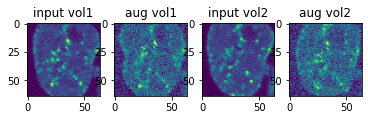

In [76]:
# specify request 
#plt.imshow(np.flipud(batch_vol1[raw].data[0,0,:,:]))

request = gp.BatchRequest()
request[raw] = gp.Roi(coord, volSize)

with gp.build(pipeline):
    batch_vol1_aug = pipeline.request_batch(request)
    batch_vol2_aug = pipeline.request_batch(request)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(np.flipud(batch_vol1[raw].data[0,0,:,:]))
ax1.set_title('input vol1')
ax2.imshow(np.flipud(batch_vol1_aug[raw].data[0,0,:,:]))
ax2.set_title('aug vol1')
ax3.imshow(np.flipud(batch_vol2[raw].data[0,0,:,:]))
ax3.set_title('input vol2')
ax4.imshow(np.flipud(batch_vol2_aug[raw].data[0,0,:,:]))
ax4.set_title('aug vol2')

Add augmentations to loader

In [ ]:
vol1 = batch_vol1_aug[raw].data
vol2 = batch_vol2_aug[raw].data

vol1 = np.reshape(vol1, (1,64, 64, 5))
vol2 = np.reshape(vol2, (1,64, 64, 5))
y = 1

vol1 = np.expand_dims(vol1, axis =0)
vol2 = np.expand_dims(vol2, axis=0)

loader.append((vol1, vol2, y))
np.shape(loader)

In [44]:
loader[2][2]

1

# Define the Model

In [11]:
class Vgg3D(torch.nn.Module):

    def __init__(self, input_size, output_classes, downsample_factors, fmaps=12):

        super(Vgg3D, self).__init__()

        self.input_size = input_size
        self.downsample_factors = downsample_factors
        self.output_classes = 2

        current_fmaps, h, w, d = tuple(input_size)
        current_size = (h, w,d)

        features = []
        for i in range(len(downsample_factors)):

            features += [
                torch.nn.Conv3d(current_fmaps,fmaps,kernel_size=3,padding=1),
                torch.nn.BatchNorm3d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv3d(fmaps,fmaps,kernel_size=3,padding=1),
                torch.nn.BatchNorm3d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.MaxPool3d(downsample_factors[i])
            ]

            current_fmaps = fmaps
            fmaps *= 2

            size = tuple(
                int(c/d)
                for c, d in zip(current_size, downsample_factors[i]))
            check = (
                s*d == c
                for s, d, c in zip(size, downsample_factors[i], current_size))
            assert all(check), \
                "Can not downsample %s by chosen downsample factor" % \
                (current_size,)
            current_size = size

        self.features = torch.nn.Sequential(*features)

        classifier = [
            torch.nn.Linear(current_size[0] *current_size[1]*current_size[2] *current_fmaps,4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096,4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096,output_classes)
        ]

        self.classifier = torch.nn.Sequential(*classifier)
    
    def forward(self, raw):

        # add a channel dimension to raw
        # shape = tuple(raw.shape)
        # raw = raw.reshape(shape[0], 1, shape[1], shape[2])
        
        # compute features
        f = self.features(raw)
        f = f.view(f.size(0), -1)
        
        # classify
        y = self.classifier(f)

        return y

# Training and Evaluation

# Loss Functions

We'll probably need to test some different loss functions. List some here:
Contrastive loss
cosine similarity
triplet loss



In [41]:
class ContrastiveLoss(nn.Module):
    "Contrastive loss function"

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + (label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

In [16]:
input_size = (1, 64, 64, 5)
downsample_factors =[(2, 2, 1), (2, 2, 1), (2, 2, 1), (2, 2, 1)];
output_classes = 12

# create the model to train
model = Vgg3D(input_size, output_classes,  downsample_factors = downsample_factors)
model = model.to(device)

summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 12, 64, 64, 5]             336
       BatchNorm3d-2        [-1, 12, 64, 64, 5]              24
              ReLU-3        [-1, 12, 64, 64, 5]               0
            Conv3d-4        [-1, 12, 64, 64, 5]           3,900
       BatchNorm3d-5        [-1, 12, 64, 64, 5]              24
              ReLU-6        [-1, 12, 64, 64, 5]               0
         MaxPool3d-7        [-1, 12, 32, 32, 5]               0
            Conv3d-8        [-1, 24, 32, 32, 5]           7,800
       BatchNorm3d-9        [-1, 24, 32, 32, 5]              48
             ReLU-10        [-1, 24, 32, 32, 5]               0
           Conv3d-11        [-1, 24, 32, 32, 5]          15,576
      BatchNorm3d-12        [-1, 24, 32, 32, 5]              48
             ReLU-13        [-1, 24, 32, 32, 5]               0
        MaxPool3d-14        [-1, 24, 16

In [45]:
#Training length
epochs = 2000

#loss_function = torch.nn.BCELoss()
loss_function = torch.nn.CosineEmbeddingLoss()
#loss_function = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

# Training Test

# Implementing the Siamese Network

The above training is just to test if the VGG model works for 3D data. Here, the training will take two pairs of images and calculate the loss from both pairs of images.

In [59]:
vol1 = batch_vol1[raw].data
vol2 = batch_vol2[raw].data

vol1 = np.reshape(vol1, (1,64, 64, 5))
vol2 = np.reshape(vol2, (1,64, 64, 5))
y = 1

vol1 = np.expand_dims(vol1, axis =0)
vol2 = np.expand_dims(vol2, axis=0)


In [60]:
type(vol1)

numpy.ndarray

In [63]:
vol_test = np.random.randint(20,30, (1,1,64,64,5))
print(type(vol_test))
print(vol_test.dtype)
#vol_test = torch.from_numpy(vol_test)
#print(type(vol_test))
#vol_test = vol_test.float()

<class 'numpy.ndarray'>
int64


In [112]:
from tqdm import tqdm

def train():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
        
    loss=[] 
    counter=[]
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        for i, (x, y, isMatch) in enumerate(loader):
            
            # x = torch.from_numpy(x).to(device).float()
            # y = torch.from_numpy(np.array([y])).to(device).float()
            #print(type(vol1))
            img1 = torch.from_numpy(vol1).float()
            img2 = torch.from_numpy(vol2).float()
            y = torch.from_numpy(np.array([y])).float()

            #vol1, vol2 
            img1, img2 , y = img1.to(device), img2.to(device), y.to(device)

            optimizer.zero_grad()

            output1 = model(img1)
            output2 = model(img2)

            isMatch = torch.from_numpy(np.array([isMatch])).float() 
            isMatch = isMatch.to(device)

            loss = loss_function(output1, output2, isMatch)

            loss.backward()
            optimizer.step()    
            epoch_loss += loss
            
        print(f"epoch {epoch}, training loss={epoch_loss}")
    
    return model

def validate():    
    model.eval()
    #dataloader = DataLoader(validation_dataset, batch_size=32)
    
    return evaluate(dataloader, 'validate')

def test():    
    model.eval()
    dataloader = DataLoader(test_dataset, batch_size=32)
    
    return evaluate(dataloader, 'test')

print(type(vol1))
#model = train(vol1, vol2, y)
model = train()

<class 'numpy.ndarray'>


  0%|          | 1/2000 [00:00<06:30,  5.12it/s]

epoch 0, training loss=0.0008545517921447754


  0%|          | 2/2000 [00:00<05:02,  6.60it/s]

epoch 1, training loss=0.0012387633323669434


  0%|          | 3/2000 [00:00<04:33,  7.30it/s]

epoch 2, training loss=0.0014437437057495117


  0%|          | 4/2000 [00:00<04:14,  7.86it/s]

epoch 3, training loss=0.0005494952201843262


  0%|          | 5/2000 [00:00<04:08,  8.02it/s]

epoch 4, training loss=0.0012996792793273926


  0%|          | 6/2000 [00:00<04:04,  8.16it/s]

epoch 5, training loss=0.0011402368545532227


  0%|          | 7/2000 [00:00<03:58,  8.37it/s]

epoch 6, training loss=0.0015814900398254395


  0%|          | 8/2000 [00:01<03:53,  8.52it/s]

epoch 7, training loss=0.0007132887840270996


  0%|          | 9/2000 [00:01<03:51,  8.59it/s]

epoch 8, training loss=0.0016555190086364746


  0%|          | 10/2000 [00:01<03:49,  8.68it/s]

epoch 9, training loss=0.0010920166969299316


  1%|          | 11/2000 [00:01<03:48,  8.70it/s]

epoch 10, training loss=0.0006080865859985352


  1%|          | 12/2000 [00:01<03:47,  8.73it/s]

epoch 11, training loss=0.001230478286743164


  1%|          | 13/2000 [00:01<03:49,  8.65it/s]

epoch 12, training loss=0.0010202527046203613


  1%|          | 14/2000 [00:01<03:48,  8.70it/s]

epoch 13, training loss=0.0012667179107666016


  1%|          | 15/2000 [00:01<03:47,  8.73it/s]

epoch 14, training loss=0.0019916296005249023


  1%|          | 16/2000 [00:01<03:46,  8.75it/s]

epoch 15, training loss=0.0012102723121643066


  1%|          | 17/2000 [00:02<03:45,  8.78it/s]

epoch 16, training loss=0.0020446181297302246


  1%|          | 18/2000 [00:02<03:48,  8.69it/s]

epoch 17, training loss=0.0008415579795837402


  1%|          | 19/2000 [00:02<03:48,  8.69it/s]

epoch 18, training loss=0.0013207197189331055


  1%|          | 20/2000 [00:02<03:46,  8.73it/s]

epoch 19, training loss=0.001282036304473877


  1%|          | 21/2000 [00:02<03:45,  8.77it/s]

epoch 20, training loss=0.000867009162902832


  1%|          | 22/2000 [00:02<03:44,  8.81it/s]

epoch 21, training loss=0.0017113685607910156


  1%|          | 23/2000 [00:02<03:43,  8.84it/s]

epoch 22, training loss=0.0027933716773986816


  1%|          | 24/2000 [00:02<03:43,  8.85it/s]

epoch 23, training loss=0.0009613633155822754


  1%|▏         | 25/2000 [00:02<03:43,  8.85it/s]

epoch 24, training loss=0.0008702874183654785


  1%|▏         | 26/2000 [00:03<03:43,  8.81it/s]

epoch 25, training loss=0.0008983016014099121


  1%|▏         | 27/2000 [00:03<03:44,  8.79it/s]

epoch 26, training loss=0.0009493827819824219


  1%|▏         | 28/2000 [00:03<03:43,  8.80it/s]

epoch 27, training loss=0.0009611845016479492


  1%|▏         | 29/2000 [00:03<03:43,  8.81it/s]

epoch 28, training loss=0.0009166598320007324


  2%|▏         | 30/2000 [00:03<03:43,  8.81it/s]

epoch 29, training loss=0.000957190990447998


  2%|▏         | 31/2000 [00:03<03:43,  8.82it/s]

epoch 30, training loss=0.001154482364654541


  2%|▏         | 32/2000 [00:03<03:42,  8.85it/s]

epoch 31, training loss=0.0009608864784240723


  2%|▏         | 33/2000 [00:03<03:44,  8.75it/s]

epoch 32, training loss=0.001035153865814209


  2%|▏         | 34/2000 [00:03<03:43,  8.79it/s]

epoch 33, training loss=0.001200556755065918


  2%|▏         | 35/2000 [00:04<03:44,  8.74it/s]

epoch 34, training loss=0.001085519790649414


  2%|▏         | 36/2000 [00:04<03:44,  8.76it/s]

epoch 35, training loss=0.0011650919914245605


  2%|▏         | 37/2000 [00:04<03:43,  8.80it/s]

epoch 36, training loss=0.0008196830749511719


  2%|▏         | 38/2000 [00:04<03:42,  8.82it/s]

epoch 37, training loss=0.0015950202941894531


  2%|▏         | 39/2000 [00:04<03:43,  8.79it/s]

epoch 38, training loss=0.0012788176536560059


  2%|▏         | 40/2000 [00:04<03:43,  8.77it/s]

epoch 39, training loss=0.001295924186706543


  2%|▏         | 41/2000 [00:04<03:43,  8.77it/s]

epoch 40, training loss=0.0010363459587097168


  2%|▏         | 42/2000 [00:04<03:44,  8.73it/s]

epoch 41, training loss=0.001277148723602295


  2%|▏         | 43/2000 [00:04<03:43,  8.76it/s]

epoch 42, training loss=0.0013129711151123047


  2%|▏         | 44/2000 [00:05<03:43,  8.77it/s]

epoch 43, training loss=0.0010946393013000488


  2%|▏         | 45/2000 [00:05<03:42,  8.80it/s]

epoch 44, training loss=0.001680612564086914


  2%|▏         | 46/2000 [00:05<03:43,  8.74it/s]

epoch 45, training loss=0.0008914470672607422


  2%|▏         | 47/2000 [00:05<03:42,  8.78it/s]

epoch 46, training loss=0.0004686713218688965


  2%|▏         | 48/2000 [00:05<03:45,  8.64it/s]

epoch 47, training loss=0.0013024210929870605


  2%|▏         | 49/2000 [00:05<03:44,  8.70it/s]

epoch 48, training loss=0.0008301138877868652


  2%|▎         | 50/2000 [00:05<03:43,  8.73it/s]

epoch 49, training loss=0.0009984970092773438


  3%|▎         | 51/2000 [00:05<03:42,  8.77it/s]

epoch 50, training loss=0.0010895729064941406


  3%|▎         | 52/2000 [00:06<03:41,  8.80it/s]

epoch 51, training loss=0.0009749531745910645


  3%|▎         | 53/2000 [00:06<03:41,  8.79it/s]

epoch 52, training loss=0.0008752942085266113


  3%|▎         | 54/2000 [00:06<03:41,  8.79it/s]

epoch 53, training loss=0.0012415051460266113


  3%|▎         | 55/2000 [00:06<03:45,  8.61it/s]

epoch 54, training loss=0.00041359663009643555


  3%|▎         | 56/2000 [00:06<03:44,  8.66it/s]

epoch 55, training loss=0.0008916854858398438


  3%|▎         | 57/2000 [00:06<03:43,  8.70it/s]

epoch 56, training loss=0.0009665489196777344


  3%|▎         | 58/2000 [00:06<03:41,  8.76it/s]

epoch 57, training loss=0.0009875893592834473


  3%|▎         | 59/2000 [00:06<03:41,  8.78it/s]

epoch 58, training loss=0.0009331703186035156


  3%|▎         | 60/2000 [00:06<03:42,  8.73it/s]

epoch 59, training loss=0.0010162591934204102


  3%|▎         | 61/2000 [00:07<03:40,  8.77it/s]

epoch 60, training loss=0.001489102840423584


  3%|▎         | 62/2000 [00:07<03:42,  8.73it/s]

epoch 61, training loss=0.0004951953887939453


  3%|▎         | 63/2000 [00:07<03:41,  8.76it/s]

epoch 62, training loss=0.0010986328125


  3%|▎         | 64/2000 [00:07<03:40,  8.77it/s]

epoch 63, training loss=0.001064002513885498


  3%|▎         | 65/2000 [00:07<03:40,  8.78it/s]

epoch 64, training loss=0.0007134079933166504


  3%|▎         | 66/2000 [00:07<03:39,  8.81it/s]

epoch 65, training loss=0.0012417435646057129


  3%|▎         | 67/2000 [00:07<03:40,  8.76it/s]

epoch 66, training loss=0.0009402036666870117


  3%|▎         | 68/2000 [00:07<03:40,  8.77it/s]

epoch 67, training loss=0.0010276436805725098


  3%|▎         | 69/2000 [00:07<03:39,  8.81it/s]

epoch 68, training loss=0.0005355477333068848


  4%|▎         | 70/2000 [00:08<03:39,  8.80it/s]

epoch 69, training loss=0.00158768892288208


  4%|▎         | 71/2000 [00:08<03:38,  8.81it/s]

epoch 70, training loss=0.0009761452674865723


  4%|▎         | 72/2000 [00:08<03:38,  8.83it/s]

epoch 71, training loss=0.0012912154197692871


  4%|▎         | 73/2000 [00:08<03:40,  8.74it/s]

epoch 72, training loss=0.000868380069732666


  4%|▎         | 74/2000 [00:08<03:40,  8.75it/s]

epoch 73, training loss=0.0006250739097595215


  4%|▍         | 75/2000 [00:08<03:39,  8.77it/s]

epoch 74, training loss=0.0010066032409667969


  4%|▍         | 76/2000 [00:08<03:38,  8.81it/s]

epoch 75, training loss=0.0008929967880249023


  4%|▍         | 77/2000 [00:08<03:39,  8.77it/s]

epoch 76, training loss=0.0011093616485595703


  4%|▍         | 78/2000 [00:08<03:39,  8.78it/s]

epoch 77, training loss=0.001019299030303955


  4%|▍         | 79/2000 [00:09<03:38,  8.80it/s]

epoch 78, training loss=0.0006884336471557617


  4%|▍         | 80/2000 [00:09<03:37,  8.83it/s]

epoch 79, training loss=0.0009562373161315918


  4%|▍         | 81/2000 [00:09<03:37,  8.83it/s]

epoch 80, training loss=0.001905202865600586


  4%|▍         | 82/2000 [00:09<03:36,  8.84it/s]

epoch 81, training loss=0.0016947388648986816


  4%|▍         | 83/2000 [00:09<03:36,  8.86it/s]

epoch 82, training loss=0.0015842914581298828


  4%|▍         | 84/2000 [00:09<03:36,  8.85it/s]

epoch 83, training loss=0.0018329024314880371


  4%|▍         | 85/2000 [00:09<03:36,  8.86it/s]

epoch 84, training loss=0.0016169548034667969


  4%|▍         | 86/2000 [00:09<03:35,  8.86it/s]

epoch 85, training loss=0.0017334818840026855


  4%|▍         | 87/2000 [00:10<03:36,  8.83it/s]

epoch 86, training loss=0.0012829303741455078


  4%|▍         | 88/2000 [00:10<03:36,  8.81it/s]

epoch 87, training loss=0.0015125274658203125


  4%|▍         | 89/2000 [00:10<03:35,  8.85it/s]

epoch 88, training loss=0.0008836984634399414


  4%|▍         | 90/2000 [00:10<03:36,  8.81it/s]

epoch 89, training loss=0.0005919337272644043


  5%|▍         | 91/2000 [00:10<03:37,  8.79it/s]

epoch 90, training loss=0.0011011958122253418


  5%|▍         | 92/2000 [00:10<03:37,  8.79it/s]

epoch 91, training loss=0.0008456707000732422


  5%|▍         | 93/2000 [00:10<03:37,  8.79it/s]

epoch 92, training loss=0.0012359023094177246


  5%|▍         | 94/2000 [00:10<03:37,  8.78it/s]

epoch 93, training loss=0.0009255409240722656


  5%|▍         | 95/2000 [00:10<03:36,  8.82it/s]

epoch 94, training loss=0.0011385679244995117


  5%|▍         | 96/2000 [00:11<03:36,  8.81it/s]

epoch 95, training loss=0.0010861754417419434


  5%|▍         | 97/2000 [00:11<03:35,  8.81it/s]

epoch 96, training loss=0.001013636589050293


  5%|▍         | 98/2000 [00:11<03:35,  8.82it/s]

epoch 97, training loss=0.0012895464897155762


  5%|▍         | 99/2000 [00:11<03:37,  8.75it/s]

epoch 98, training loss=0.0011914372444152832


  5%|▌         | 100/2000 [00:11<03:38,  8.68it/s]

epoch 99, training loss=0.0011654496192932129


  5%|▌         | 101/2000 [00:11<03:37,  8.75it/s]

epoch 100, training loss=0.00028765201568603516


  5%|▌         | 102/2000 [00:11<03:35,  8.82it/s]

epoch 101, training loss=0.0006895065307617188


  5%|▌         | 103/2000 [00:11<03:34,  8.85it/s]

epoch 102, training loss=0.00213015079498291


  5%|▌         | 104/2000 [00:11<03:33,  8.87it/s]

epoch 103, training loss=0.0015976428985595703


  5%|▌         | 105/2000 [00:12<03:33,  8.89it/s]

epoch 104, training loss=0.0008666515350341797


  5%|▌         | 106/2000 [00:12<03:33,  8.88it/s]

epoch 105, training loss=0.0013731718063354492


  5%|▌         | 107/2000 [00:12<03:33,  8.88it/s]

epoch 106, training loss=0.000813603401184082


  5%|▌         | 108/2000 [00:12<03:33,  8.85it/s]

epoch 107, training loss=0.0010482072830200195


  5%|▌         | 109/2000 [00:12<03:34,  8.82it/s]

epoch 108, training loss=0.0007163882255554199


  6%|▌         | 110/2000 [00:12<03:33,  8.85it/s]

epoch 109, training loss=0.0007125735282897949


  6%|▌         | 111/2000 [00:12<03:35,  8.77it/s]

epoch 110, training loss=0.0007477402687072754


  6%|▌         | 112/2000 [00:12<03:34,  8.82it/s]

epoch 111, training loss=0.0008636116981506348


  6%|▌         | 113/2000 [00:12<03:32,  8.87it/s]

epoch 112, training loss=0.0008105039596557617


  6%|▌         | 114/2000 [00:13<03:35,  8.77it/s]

epoch 113, training loss=0.0010418891906738281


  6%|▌         | 115/2000 [00:13<03:36,  8.69it/s]

epoch 114, training loss=0.0008291006088256836


  6%|▌         | 116/2000 [00:13<03:34,  8.78it/s]

epoch 115, training loss=0.0008115172386169434


  6%|▌         | 117/2000 [00:13<03:33,  8.84it/s]

epoch 116, training loss=0.00029402971267700195


  6%|▌         | 118/2000 [00:13<03:35,  8.74it/s]

epoch 117, training loss=0.0005782246589660645


  6%|▌         | 119/2000 [00:13<03:34,  8.76it/s]

epoch 118, training loss=0.0014111995697021484


  6%|▌         | 120/2000 [00:13<03:36,  8.67it/s]

epoch 119, training loss=0.0009058117866516113


  6%|▌         | 121/2000 [00:13<03:35,  8.72it/s]

epoch 120, training loss=0.001317143440246582


  6%|▌         | 122/2000 [00:13<03:34,  8.74it/s]

epoch 121, training loss=0.0009409189224243164


  6%|▌         | 123/2000 [00:14<03:34,  8.75it/s]

epoch 122, training loss=0.0011882781982421875


  6%|▌         | 124/2000 [00:14<03:34,  8.76it/s]

epoch 123, training loss=0.0009028911590576172


  6%|▋         | 125/2000 [00:14<03:33,  8.77it/s]

epoch 124, training loss=0.001903235912322998


  6%|▋         | 126/2000 [00:14<03:33,  8.77it/s]

epoch 125, training loss=0.0007143616676330566


  6%|▋         | 127/2000 [00:14<03:32,  8.80it/s]

epoch 126, training loss=0.0007224082946777344


  6%|▋         | 128/2000 [00:14<03:31,  8.85it/s]

epoch 127, training loss=0.0007519125938415527


  6%|▋         | 129/2000 [00:14<03:30,  8.89it/s]

epoch 128, training loss=0.0016287565231323242


  6%|▋         | 130/2000 [00:14<03:31,  8.84it/s]

epoch 129, training loss=0.0008881688117980957


  7%|▋         | 131/2000 [00:15<03:30,  8.88it/s]

epoch 130, training loss=0.0008667111396789551


  7%|▋         | 132/2000 [00:15<03:33,  8.76it/s]

epoch 131, training loss=0.0014060735702514648


  7%|▋         | 133/2000 [00:15<03:31,  8.83it/s]

epoch 132, training loss=0.0010072588920593262


  7%|▋         | 134/2000 [00:15<03:30,  8.87it/s]

epoch 133, training loss=0.0012257695198059082


  7%|▋         | 135/2000 [00:15<03:30,  8.88it/s]

epoch 134, training loss=0.0012463927268981934


  7%|▋         | 136/2000 [00:15<03:29,  8.88it/s]

epoch 135, training loss=0.0006530880928039551


  7%|▋         | 137/2000 [00:15<03:29,  8.90it/s]

epoch 136, training loss=0.0008944869041442871


  7%|▋         | 138/2000 [00:15<03:28,  8.92it/s]

epoch 137, training loss=0.0005705952644348145


  7%|▋         | 139/2000 [00:15<03:28,  8.92it/s]

epoch 138, training loss=0.0007194280624389648


  7%|▋         | 140/2000 [00:16<03:28,  8.91it/s]

epoch 139, training loss=0.0009202957153320312


  7%|▋         | 141/2000 [00:16<03:29,  8.86it/s]

epoch 140, training loss=0.000842750072479248


  7%|▋         | 142/2000 [00:16<03:32,  8.75it/s]

epoch 141, training loss=0.0012716054916381836


  7%|▋         | 143/2000 [00:16<03:32,  8.75it/s]

epoch 142, training loss=0.0012715458869934082


  7%|▋         | 144/2000 [00:16<03:34,  8.66it/s]

epoch 143, training loss=0.001282334327697754


  7%|▋         | 145/2000 [00:16<03:34,  8.66it/s]

epoch 144, training loss=0.0006607770919799805


  7%|▋         | 146/2000 [00:16<03:33,  8.68it/s]

epoch 145, training loss=0.0007852911949157715


  7%|▋         | 147/2000 [00:16<03:32,  8.73it/s]

epoch 146, training loss=0.0013734698295593262


  7%|▋         | 148/2000 [00:16<03:34,  8.63it/s]

epoch 147, training loss=0.00034940242767333984


  7%|▋         | 149/2000 [00:17<03:32,  8.71it/s]

epoch 148, training loss=0.0009801983833312988


  8%|▊         | 150/2000 [00:17<03:30,  8.78it/s]

epoch 149, training loss=0.0013382434844970703


  8%|▊         | 151/2000 [00:17<03:29,  8.83it/s]

epoch 150, training loss=0.0006098747253417969


  8%|▊         | 152/2000 [00:17<03:28,  8.87it/s]

epoch 151, training loss=0.0006244182586669922


  8%|▊         | 153/2000 [00:17<03:29,  8.81it/s]

epoch 152, training loss=0.0009613037109375


  8%|▊         | 154/2000 [00:17<03:28,  8.84it/s]

epoch 153, training loss=0.0007871389389038086


  8%|▊         | 155/2000 [00:17<03:31,  8.74it/s]

epoch 154, training loss=0.0011140108108520508


  8%|▊         | 156/2000 [00:17<03:33,  8.63it/s]

epoch 155, training loss=0.0012304186820983887


  8%|▊         | 157/2000 [00:17<03:31,  8.72it/s]

epoch 156, training loss=0.0008096098899841309


  8%|▊         | 158/2000 [00:18<03:30,  8.74it/s]

epoch 157, training loss=0.0012549161911010742


  8%|▊         | 159/2000 [00:18<03:31,  8.69it/s]

epoch 158, training loss=0.001025557518005371


  8%|▊         | 160/2000 [00:18<03:32,  8.64it/s]

epoch 159, training loss=0.0015608668327331543


  8%|▊         | 161/2000 [00:18<03:33,  8.62it/s]

epoch 160, training loss=0.001482248306274414


  8%|▊         | 162/2000 [00:18<03:32,  8.67it/s]

epoch 161, training loss=0.0012287497520446777


  8%|▊         | 163/2000 [00:18<03:31,  8.68it/s]

epoch 162, training loss=0.001104891300201416


  8%|▊         | 164/2000 [00:18<03:31,  8.67it/s]

epoch 163, training loss=0.0006188154220581055


  8%|▊         | 165/2000 [00:18<03:31,  8.69it/s]

epoch 164, training loss=0.0004544854164123535


  8%|▊         | 166/2000 [00:19<03:31,  8.69it/s]

epoch 165, training loss=0.0010097026824951172


  8%|▊         | 167/2000 [00:19<03:31,  8.68it/s]

epoch 166, training loss=0.0011606812477111816


  8%|▊         | 168/2000 [00:19<03:30,  8.69it/s]

epoch 167, training loss=0.0008209943771362305


  8%|▊         | 169/2000 [00:19<03:31,  8.66it/s]

epoch 168, training loss=0.0007969141006469727


  8%|▊         | 170/2000 [00:19<03:31,  8.67it/s]

epoch 169, training loss=0.0007392764091491699


  9%|▊         | 171/2000 [00:19<03:31,  8.66it/s]

epoch 170, training loss=0.0006722211837768555


  9%|▊         | 172/2000 [00:19<03:31,  8.66it/s]

epoch 171, training loss=0.0011563897132873535


  9%|▊         | 173/2000 [00:19<03:32,  8.59it/s]

epoch 172, training loss=0.0005740523338317871


  9%|▊         | 174/2000 [00:19<03:32,  8.61it/s]

epoch 173, training loss=0.0005450844764709473


  9%|▉         | 175/2000 [00:20<03:32,  8.60it/s]

epoch 174, training loss=0.0005512237548828125


  9%|▉         | 176/2000 [00:20<03:31,  8.61it/s]

epoch 175, training loss=0.0004735589027404785


  9%|▉         | 177/2000 [00:20<03:31,  8.62it/s]

epoch 176, training loss=0.0006052851676940918


  9%|▉         | 178/2000 [00:20<03:31,  8.61it/s]

epoch 177, training loss=0.0005958676338195801


  9%|▉         | 179/2000 [00:20<03:31,  8.61it/s]

epoch 178, training loss=0.0006886124610900879


  9%|▉         | 180/2000 [00:20<03:30,  8.66it/s]

epoch 179, training loss=0.001558840274810791


  9%|▉         | 181/2000 [00:20<03:28,  8.74it/s]

epoch 180, training loss=0.0006806254386901855


  9%|▉         | 182/2000 [00:20<03:29,  8.68it/s]

epoch 181, training loss=0.0013516545295715332


  9%|▉         | 183/2000 [00:20<03:31,  8.59it/s]

epoch 182, training loss=0.001612842082977295


  9%|▉         | 184/2000 [00:21<03:28,  8.69it/s]

epoch 183, training loss=0.0013535618782043457


  9%|▉         | 185/2000 [00:21<03:27,  8.76it/s]

epoch 184, training loss=0.0006453394889831543


  9%|▉         | 186/2000 [00:21<03:27,  8.76it/s]

epoch 185, training loss=0.0014549493789672852


  9%|▉         | 187/2000 [00:21<03:29,  8.67it/s]

epoch 186, training loss=0.0005866885185241699


  9%|▉         | 188/2000 [00:21<03:27,  8.74it/s]

epoch 187, training loss=0.0008756518363952637


  9%|▉         | 189/2000 [00:21<03:26,  8.78it/s]

epoch 188, training loss=0.0014794468879699707


 10%|▉         | 190/2000 [00:21<03:25,  8.79it/s]

epoch 189, training loss=0.0013920068740844727


 10%|▉         | 191/2000 [00:21<03:24,  8.83it/s]

epoch 190, training loss=0.0004564523696899414


 10%|▉         | 192/2000 [00:22<03:26,  8.74it/s]

epoch 191, training loss=0.0008029341697692871


 10%|▉         | 193/2000 [00:22<03:25,  8.79it/s]

epoch 192, training loss=0.000584721565246582


 10%|▉         | 194/2000 [00:22<03:24,  8.84it/s]

epoch 193, training loss=0.0005689263343811035


 10%|▉         | 195/2000 [00:22<03:23,  8.85it/s]

epoch 194, training loss=0.0011143088340759277


 10%|▉         | 196/2000 [00:22<03:27,  8.68it/s]

epoch 195, training loss=0.0015752911567687988


 10%|▉         | 197/2000 [00:22<03:26,  8.75it/s]

epoch 196, training loss=0.0009810924530029297


 10%|▉         | 198/2000 [00:22<03:25,  8.77it/s]

epoch 197, training loss=0.0010068416595458984


 10%|▉         | 199/2000 [00:22<03:23,  8.84it/s]

epoch 198, training loss=0.0006893277168273926


 10%|█         | 200/2000 [00:22<03:25,  8.78it/s]

epoch 199, training loss=0.0008689165115356445


 10%|█         | 201/2000 [00:23<03:25,  8.77it/s]

epoch 200, training loss=0.0007013678550720215


 10%|█         | 202/2000 [00:23<03:24,  8.81it/s]

epoch 201, training loss=0.0008428692817687988


 10%|█         | 203/2000 [00:23<03:26,  8.69it/s]

epoch 202, training loss=0.0006372332572937012


 10%|█         | 204/2000 [00:23<03:24,  8.78it/s]

epoch 203, training loss=0.0007541179656982422


 10%|█         | 205/2000 [00:23<03:23,  8.82it/s]

epoch 204, training loss=0.0006760358810424805


 10%|█         | 206/2000 [00:23<03:24,  8.78it/s]

epoch 205, training loss=0.0005221962928771973


 10%|█         | 207/2000 [00:23<03:22,  8.83it/s]

epoch 206, training loss=0.0006066560745239258


 10%|█         | 208/2000 [00:23<03:26,  8.70it/s]

epoch 207, training loss=0.0007703304290771484


 10%|█         | 209/2000 [00:23<03:28,  8.59it/s]

epoch 208, training loss=0.0008679032325744629


 10%|█         | 210/2000 [00:24<03:25,  8.70it/s]

epoch 209, training loss=0.0006916522979736328


 11%|█         | 211/2000 [00:24<03:24,  8.75it/s]

epoch 210, training loss=0.0010241866111755371


 11%|█         | 212/2000 [00:24<03:25,  8.70it/s]

epoch 211, training loss=0.0009163022041320801


 11%|█         | 213/2000 [00:24<03:23,  8.77it/s]

epoch 212, training loss=0.0005792975425720215


 11%|█         | 214/2000 [00:24<03:23,  8.80it/s]

epoch 213, training loss=0.0008108615875244141


 11%|█         | 215/2000 [00:24<03:22,  8.81it/s]

epoch 214, training loss=0.0006511211395263672


 11%|█         | 216/2000 [00:24<03:24,  8.74it/s]

epoch 215, training loss=0.0008068084716796875


 11%|█         | 217/2000 [00:24<03:24,  8.72it/s]

epoch 216, training loss=0.0009307265281677246


 11%|█         | 218/2000 [00:24<03:22,  8.80it/s]

epoch 217, training loss=0.0006017088890075684


 11%|█         | 219/2000 [00:25<03:21,  8.82it/s]

epoch 218, training loss=0.0008271336555480957


 11%|█         | 220/2000 [00:25<03:21,  8.86it/s]

epoch 219, training loss=0.0008495450019836426


 11%|█         | 221/2000 [00:25<03:20,  8.86it/s]

epoch 220, training loss=0.0008192062377929688


 11%|█         | 222/2000 [00:25<03:20,  8.86it/s]

epoch 221, training loss=0.0005906820297241211


 11%|█         | 223/2000 [00:25<03:20,  8.86it/s]

epoch 222, training loss=0.0010107159614562988


 11%|█         | 224/2000 [00:25<03:24,  8.69it/s]

epoch 223, training loss=0.0006946921348571777


 11%|█▏        | 225/2000 [00:25<03:22,  8.75it/s]

epoch 224, training loss=0.000797569751739502


 11%|█▏        | 226/2000 [00:25<03:21,  8.78it/s]

epoch 225, training loss=0.0005469322204589844


 11%|█▏        | 227/2000 [00:25<03:21,  8.80it/s]

epoch 226, training loss=0.0006628036499023438


 11%|█▏        | 228/2000 [00:26<03:21,  8.78it/s]

epoch 227, training loss=0.0008840560913085938


 11%|█▏        | 229/2000 [00:26<03:20,  8.83it/s]

epoch 228, training loss=0.00047516822814941406


 12%|█▏        | 230/2000 [00:26<03:23,  8.70it/s]

epoch 229, training loss=0.0004356503486633301


 12%|█▏        | 231/2000 [00:26<03:23,  8.70it/s]

epoch 230, training loss=0.0008234381675720215


 12%|█▏        | 232/2000 [00:26<03:21,  8.78it/s]

epoch 231, training loss=0.0007228851318359375


 12%|█▏        | 233/2000 [00:26<03:20,  8.82it/s]

epoch 232, training loss=0.0005202293395996094


 12%|█▏        | 234/2000 [00:26<03:19,  8.87it/s]

epoch 233, training loss=0.0009224414825439453


 12%|█▏        | 235/2000 [00:26<03:20,  8.79it/s]

epoch 234, training loss=0.0011304020881652832


 12%|█▏        | 236/2000 [00:27<03:19,  8.84it/s]

epoch 235, training loss=0.0010291337966918945


 12%|█▏        | 237/2000 [00:27<03:22,  8.69it/s]

epoch 236, training loss=0.0006730556488037109


 12%|█▏        | 238/2000 [00:27<03:21,  8.76it/s]

epoch 237, training loss=0.0003438591957092285


 12%|█▏        | 239/2000 [00:27<03:21,  8.73it/s]

epoch 238, training loss=0.0011293888092041016


 12%|█▏        | 240/2000 [00:27<03:20,  8.78it/s]

epoch 239, training loss=0.0013611316680908203


 12%|█▏        | 241/2000 [00:27<03:19,  8.84it/s]

epoch 240, training loss=0.0008630156517028809


 12%|█▏        | 242/2000 [00:27<03:18,  8.87it/s]

epoch 241, training loss=0.0009398460388183594


 12%|█▏        | 243/2000 [00:27<03:17,  8.89it/s]

epoch 242, training loss=0.0004833340644836426


 12%|█▏        | 244/2000 [00:27<03:17,  8.90it/s]

epoch 243, training loss=0.000786125659942627


 12%|█▏        | 245/2000 [00:28<03:17,  8.91it/s]

epoch 244, training loss=0.0007829070091247559


 12%|█▏        | 246/2000 [00:28<03:19,  8.80it/s]

epoch 245, training loss=0.0006516575813293457


 12%|█▏        | 247/2000 [00:28<03:18,  8.84it/s]

epoch 246, training loss=0.0007731914520263672


 12%|█▏        | 248/2000 [00:28<03:17,  8.85it/s]

epoch 247, training loss=0.0009325742721557617


 12%|█▏        | 249/2000 [00:28<03:17,  8.85it/s]

epoch 248, training loss=0.0011013150215148926


 12%|█▎        | 250/2000 [00:28<03:17,  8.85it/s]

epoch 249, training loss=0.0008103847503662109


 13%|█▎        | 251/2000 [00:28<03:17,  8.87it/s]

epoch 250, training loss=0.0008474588394165039


 13%|█▎        | 252/2000 [00:28<03:17,  8.86it/s]

epoch 251, training loss=0.000758826732635498


 13%|█▎        | 253/2000 [00:28<03:18,  8.79it/s]

epoch 252, training loss=0.001060187816619873


 13%|█▎        | 254/2000 [00:29<03:18,  8.81it/s]

epoch 253, training loss=0.0007445812225341797


 13%|█▎        | 255/2000 [00:29<03:17,  8.83it/s]

epoch 254, training loss=0.0010838508605957031


 13%|█▎        | 256/2000 [00:29<03:20,  8.71it/s]

epoch 255, training loss=0.0007930994033813477


 13%|█▎        | 257/2000 [00:29<03:22,  8.61it/s]

epoch 256, training loss=0.0008206963539123535


 13%|█▎        | 258/2000 [00:29<03:21,  8.65it/s]

epoch 257, training loss=0.0008463263511657715


 13%|█▎        | 259/2000 [00:29<03:19,  8.74it/s]

epoch 258, training loss=0.0012919306755065918


 13%|█▎        | 260/2000 [00:29<03:19,  8.74it/s]

epoch 259, training loss=0.0006226301193237305


 13%|█▎        | 261/2000 [00:29<03:20,  8.69it/s]

epoch 260, training loss=0.0007106661796569824


 13%|█▎        | 262/2000 [00:29<03:21,  8.64it/s]

epoch 261, training loss=0.0007860660552978516


 13%|█▎        | 263/2000 [00:30<03:19,  8.73it/s]

epoch 262, training loss=0.000666499137878418


 13%|█▎        | 264/2000 [00:30<03:19,  8.68it/s]

epoch 263, training loss=0.0011715888977050781


 13%|█▎        | 265/2000 [00:30<03:18,  8.76it/s]

epoch 264, training loss=0.0010859370231628418


 13%|█▎        | 266/2000 [00:30<03:21,  8.62it/s]

epoch 265, training loss=0.0006673932075500488


 13%|█▎        | 267/2000 [00:30<03:19,  8.70it/s]

epoch 266, training loss=0.0007427334785461426


 13%|█▎        | 268/2000 [00:30<03:17,  8.76it/s]

epoch 267, training loss=0.0007448792457580566


 13%|█▎        | 269/2000 [00:30<03:16,  8.80it/s]

epoch 268, training loss=0.0007614493370056152


 14%|█▎        | 270/2000 [00:30<03:16,  8.79it/s]

epoch 269, training loss=0.000783383846282959


 14%|█▎        | 271/2000 [00:31<03:16,  8.79it/s]

epoch 270, training loss=0.0011109709739685059


 14%|█▎        | 272/2000 [00:31<03:15,  8.84it/s]

epoch 271, training loss=0.0006669759750366211


 14%|█▎        | 273/2000 [00:31<03:14,  8.87it/s]

epoch 272, training loss=0.000847935676574707


 14%|█▎        | 274/2000 [00:31<03:14,  8.89it/s]

epoch 273, training loss=0.0009071230888366699


 14%|█▍        | 275/2000 [00:31<03:13,  8.90it/s]

epoch 274, training loss=0.0009595155715942383


 14%|█▍        | 276/2000 [00:31<03:13,  8.90it/s]

epoch 275, training loss=0.0008882880210876465


 14%|█▍        | 277/2000 [00:31<03:13,  8.89it/s]

epoch 276, training loss=0.0007790923118591309


 14%|█▍        | 278/2000 [00:31<03:16,  8.78it/s]

epoch 277, training loss=0.000598907470703125


 14%|█▍        | 279/2000 [00:31<03:19,  8.64it/s]

epoch 278, training loss=0.0007027983665466309


 14%|█▍        | 280/2000 [00:32<03:16,  8.74it/s]

epoch 279, training loss=0.0007737278938293457


 14%|█▍        | 281/2000 [00:32<03:16,  8.73it/s]

epoch 280, training loss=0.0011154413223266602


 14%|█▍        | 282/2000 [00:32<03:15,  8.79it/s]

epoch 281, training loss=0.0008407831192016602


 14%|█▍        | 283/2000 [00:32<03:17,  8.71it/s]

epoch 282, training loss=0.0005676150321960449


 14%|█▍        | 284/2000 [00:32<03:15,  8.77it/s]

epoch 283, training loss=0.0006119012832641602


 14%|█▍        | 285/2000 [00:32<03:14,  8.83it/s]

epoch 284, training loss=0.0007208585739135742


 14%|█▍        | 286/2000 [00:32<03:13,  8.86it/s]

epoch 285, training loss=0.0011670589447021484


 14%|█▍        | 287/2000 [00:32<03:12,  8.88it/s]

epoch 286, training loss=0.0006194114685058594


 14%|█▍        | 288/2000 [00:32<03:13,  8.85it/s]

epoch 287, training loss=0.0012379288673400879


 14%|█▍        | 289/2000 [00:33<03:15,  8.76it/s]

epoch 288, training loss=0.0006237626075744629


 14%|█▍        | 290/2000 [00:33<03:17,  8.64it/s]

epoch 289, training loss=0.0006703734397888184


 15%|█▍        | 291/2000 [00:33<03:15,  8.73it/s]

epoch 290, training loss=0.0007103681564331055


 15%|█▍        | 292/2000 [00:33<03:14,  8.78it/s]

epoch 291, training loss=0.0010935664176940918


 15%|█▍        | 293/2000 [00:33<03:13,  8.81it/s]

epoch 292, training loss=0.0011869072914123535


 15%|█▍        | 294/2000 [00:33<03:16,  8.68it/s]

epoch 293, training loss=0.0006388425827026367


 15%|█▍        | 295/2000 [00:33<03:15,  8.72it/s]

epoch 294, training loss=0.0008943676948547363


 15%|█▍        | 296/2000 [00:33<03:14,  8.77it/s]

epoch 295, training loss=0.0005165338516235352


 15%|█▍        | 297/2000 [00:33<03:15,  8.73it/s]

epoch 296, training loss=0.0008767843246459961


 15%|█▍        | 298/2000 [00:34<03:13,  8.78it/s]

epoch 297, training loss=0.0007993578910827637


 15%|█▍        | 299/2000 [00:34<03:13,  8.79it/s]

epoch 298, training loss=0.0009176135063171387


 15%|█▌        | 300/2000 [00:34<03:12,  8.84it/s]

epoch 299, training loss=0.0003491044044494629


 15%|█▌        | 301/2000 [00:34<03:15,  8.70it/s]

epoch 300, training loss=0.0007590055465698242


 15%|█▌        | 302/2000 [00:34<03:18,  8.56it/s]

epoch 301, training loss=0.0006456375122070312


 15%|█▌        | 303/2000 [00:34<03:15,  8.66it/s]

epoch 302, training loss=0.000681459903717041


 15%|█▌        | 304/2000 [00:34<03:14,  8.73it/s]

epoch 303, training loss=0.0009050965309143066


 15%|█▌        | 305/2000 [00:34<03:13,  8.76it/s]

epoch 304, training loss=0.00035858154296875


 15%|█▌        | 306/2000 [00:34<03:14,  8.72it/s]

epoch 305, training loss=0.00043523311614990234


 15%|█▌        | 307/2000 [00:35<03:12,  8.77it/s]

epoch 306, training loss=0.0006185770034790039


 15%|█▌        | 308/2000 [00:35<03:13,  8.73it/s]

epoch 307, training loss=0.0006500482559204102


 15%|█▌        | 309/2000 [00:35<03:15,  8.64it/s]

epoch 308, training loss=0.0003657341003417969


 16%|█▌        | 310/2000 [00:35<03:14,  8.70it/s]

epoch 309, training loss=0.0003361701965332031


 16%|█▌        | 311/2000 [00:35<03:12,  8.76it/s]

epoch 310, training loss=0.0008210539817810059


 16%|█▌        | 312/2000 [00:35<03:11,  8.79it/s]

epoch 311, training loss=0.0005772709846496582


 16%|█▌        | 313/2000 [00:35<03:11,  8.80it/s]

epoch 312, training loss=0.0005431175231933594


 16%|█▌        | 314/2000 [00:35<03:11,  8.81it/s]

epoch 313, training loss=0.0006674528121948242


 16%|█▌        | 315/2000 [00:36<03:10,  8.83it/s]

epoch 314, training loss=0.0009282827377319336


 16%|█▌        | 316/2000 [00:36<03:11,  8.78it/s]

epoch 315, training loss=0.00048595666885375977


 16%|█▌        | 317/2000 [00:36<03:10,  8.83it/s]

epoch 316, training loss=0.0009387731552124023


 16%|█▌        | 318/2000 [00:36<03:09,  8.86it/s]

epoch 317, training loss=0.000887453556060791


 16%|█▌        | 319/2000 [00:36<03:14,  8.65it/s]

epoch 318, training loss=0.0008879899978637695


 16%|█▌        | 320/2000 [00:36<03:12,  8.73it/s]

epoch 319, training loss=0.0006648898124694824


 16%|█▌        | 321/2000 [00:36<03:11,  8.77it/s]

epoch 320, training loss=0.0004188418388366699


 16%|█▌        | 322/2000 [00:36<03:10,  8.81it/s]

epoch 321, training loss=0.00047647953033447266


 16%|█▌        | 323/2000 [00:36<03:10,  8.81it/s]

epoch 322, training loss=0.0011413097381591797


 16%|█▌        | 324/2000 [00:37<03:09,  8.84it/s]

epoch 323, training loss=0.00043022632598876953


 16%|█▋        | 325/2000 [00:37<03:09,  8.84it/s]

epoch 324, training loss=0.0006536245346069336


 16%|█▋        | 326/2000 [00:37<03:11,  8.75it/s]

epoch 325, training loss=0.0011069774627685547


 16%|█▋        | 327/2000 [00:37<03:13,  8.65it/s]

epoch 326, training loss=0.0004811286926269531


 16%|█▋        | 328/2000 [00:37<03:11,  8.73it/s]

epoch 327, training loss=0.0005188584327697754


 16%|█▋        | 329/2000 [00:37<03:10,  8.78it/s]

epoch 328, training loss=0.0003706216812133789


 16%|█▋        | 330/2000 [00:37<03:09,  8.81it/s]

epoch 329, training loss=0.000760495662689209


 17%|█▋        | 331/2000 [00:37<03:08,  8.84it/s]

epoch 330, training loss=0.0005187392234802246


 17%|█▋        | 332/2000 [00:37<03:08,  8.85it/s]

epoch 331, training loss=0.0005387663841247559


 17%|█▋        | 333/2000 [00:38<03:08,  8.86it/s]

epoch 332, training loss=0.0005644559860229492


 17%|█▋        | 334/2000 [00:38<03:08,  8.83it/s]

epoch 333, training loss=0.0005937814712524414


 17%|█▋        | 335/2000 [00:38<03:13,  8.58it/s]

epoch 334, training loss=0.0006489753723144531


 17%|█▋        | 336/2000 [00:38<03:13,  8.59it/s]

epoch 335, training loss=0.0007168054580688477


 17%|█▋        | 337/2000 [00:38<03:11,  8.68it/s]

epoch 336, training loss=0.0008045434951782227


 17%|█▋        | 338/2000 [00:38<03:09,  8.76it/s]

epoch 337, training loss=0.0005332827568054199


 17%|█▋        | 339/2000 [00:38<03:08,  8.82it/s]

epoch 338, training loss=0.0008044242858886719


 17%|█▋        | 340/2000 [00:38<03:09,  8.76it/s]

epoch 339, training loss=0.0005790591239929199


 17%|█▋        | 341/2000 [00:38<03:13,  8.55it/s]

epoch 340, training loss=0.0004665851593017578


 17%|█▋        | 342/2000 [00:39<03:14,  8.54it/s]

epoch 341, training loss=0.0009921789169311523


 17%|█▋        | 343/2000 [00:39<03:11,  8.64it/s]

epoch 342, training loss=0.0007492303848266602


 17%|█▋        | 344/2000 [00:39<03:09,  8.72it/s]

epoch 343, training loss=0.0003502964973449707


 17%|█▋        | 345/2000 [00:39<03:08,  8.77it/s]

epoch 344, training loss=0.0007000565528869629


 17%|█▋        | 346/2000 [00:39<03:08,  8.77it/s]

epoch 345, training loss=0.0007238984107971191


 17%|█▋        | 347/2000 [00:39<03:07,  8.80it/s]

epoch 346, training loss=0.0008844733238220215


 17%|█▋        | 348/2000 [00:39<03:06,  8.84it/s]

epoch 347, training loss=0.00047206878662109375


 17%|█▋        | 349/2000 [00:39<03:08,  8.76it/s]

epoch 348, training loss=0.0006259679794311523


 18%|█▊        | 350/2000 [00:40<03:06,  8.83it/s]

epoch 349, training loss=0.00043529272079467773


 18%|█▊        | 351/2000 [00:40<03:06,  8.84it/s]

epoch 350, training loss=0.000574648380279541


 18%|█▊        | 352/2000 [00:40<03:09,  8.68it/s]

epoch 351, training loss=0.0006173253059387207


 18%|█▊        | 353/2000 [00:40<03:12,  8.55it/s]

epoch 352, training loss=0.0005214214324951172


 18%|█▊        | 354/2000 [00:40<03:11,  8.60it/s]

epoch 353, training loss=0.000737607479095459


 18%|█▊        | 355/2000 [00:40<03:10,  8.62it/s]

epoch 354, training loss=0.0005733370780944824


 18%|█▊        | 356/2000 [00:40<03:13,  8.52it/s]

epoch 355, training loss=0.0005128979682922363


 18%|█▊        | 357/2000 [00:40<03:11,  8.56it/s]

epoch 356, training loss=0.0006828904151916504


 18%|█▊        | 358/2000 [00:40<03:09,  8.67it/s]

epoch 357, training loss=0.0005115866661071777


 18%|█▊        | 359/2000 [00:41<03:08,  8.70it/s]

epoch 358, training loss=0.000545501708984375


 18%|█▊        | 360/2000 [00:41<03:08,  8.72it/s]

epoch 359, training loss=0.0005551576614379883


 18%|█▊        | 361/2000 [00:41<03:09,  8.64it/s]

epoch 360, training loss=0.0007227659225463867


 18%|█▊        | 362/2000 [00:41<03:07,  8.71it/s]

epoch 361, training loss=0.00038677453994750977


 18%|█▊        | 363/2000 [00:41<03:06,  8.77it/s]

epoch 362, training loss=0.0005763769149780273


 18%|█▊        | 364/2000 [00:41<03:07,  8.74it/s]

epoch 363, training loss=0.0004177093505859375


 18%|█▊        | 365/2000 [00:41<03:09,  8.64it/s]

epoch 364, training loss=0.0005584359169006348


 18%|█▊        | 366/2000 [00:41<03:07,  8.69it/s]

epoch 365, training loss=0.0007908940315246582


 18%|█▊        | 367/2000 [00:41<03:06,  8.75it/s]

epoch 366, training loss=0.0006857514381408691


 18%|█▊        | 368/2000 [00:42<03:05,  8.79it/s]

epoch 367, training loss=0.0010011792182922363


 18%|█▊        | 369/2000 [00:42<03:05,  8.78it/s]

epoch 368, training loss=0.0004988908767700195


 18%|█▊        | 370/2000 [00:42<03:05,  8.79it/s]

epoch 369, training loss=0.0003324747085571289


 19%|█▊        | 371/2000 [00:42<03:04,  8.81it/s]

epoch 370, training loss=0.0006566643714904785


 19%|█▊        | 372/2000 [00:42<03:04,  8.82it/s]

epoch 371, training loss=0.0007941126823425293


 19%|█▊        | 373/2000 [00:42<03:03,  8.85it/s]

epoch 372, training loss=0.0005248188972473145


 19%|█▊        | 374/2000 [00:42<03:05,  8.78it/s]

epoch 373, training loss=0.0006209015846252441


 19%|█▉        | 375/2000 [00:42<03:06,  8.69it/s]

epoch 374, training loss=0.0006310939788818359


 19%|█▉        | 376/2000 [00:43<03:08,  8.59it/s]

epoch 375, training loss=0.0006327629089355469


 19%|█▉        | 377/2000 [00:43<03:07,  8.67it/s]

epoch 376, training loss=0.0008710622787475586


 19%|█▉        | 378/2000 [00:43<03:05,  8.72it/s]

epoch 377, training loss=0.00045686960220336914


 19%|█▉        | 379/2000 [00:43<03:05,  8.74it/s]

epoch 378, training loss=0.0002714991569519043


 19%|█▉        | 380/2000 [00:43<03:06,  8.68it/s]

epoch 379, training loss=0.0005040168762207031


 19%|█▉        | 381/2000 [00:43<03:08,  8.57it/s]

epoch 380, training loss=0.0005258321762084961


 19%|█▉        | 382/2000 [00:43<03:06,  8.66it/s]

epoch 381, training loss=0.000535130500793457


 19%|█▉        | 383/2000 [00:43<03:04,  8.74it/s]

epoch 382, training loss=0.0006406307220458984


 19%|█▉        | 384/2000 [00:43<03:04,  8.76it/s]

epoch 383, training loss=0.0006292462348937988


 19%|█▉        | 385/2000 [00:44<03:06,  8.64it/s]

epoch 384, training loss=0.0007203817367553711


 19%|█▉        | 386/2000 [00:44<03:07,  8.60it/s]

epoch 385, training loss=0.0004520416259765625


 19%|█▉        | 387/2000 [00:44<03:05,  8.68it/s]

epoch 386, training loss=0.0005251765251159668


 19%|█▉        | 388/2000 [00:44<03:05,  8.67it/s]

epoch 387, training loss=0.0005154609680175781


 19%|█▉        | 389/2000 [00:44<03:04,  8.73it/s]

epoch 388, training loss=0.0007511377334594727


 20%|█▉        | 390/2000 [00:44<03:03,  8.78it/s]

epoch 389, training loss=0.000700533390045166


 20%|█▉        | 391/2000 [00:44<03:03,  8.75it/s]

epoch 390, training loss=0.00028580427169799805


 20%|█▉        | 392/2000 [00:44<03:03,  8.77it/s]

epoch 391, training loss=0.000712275505065918


 20%|█▉        | 393/2000 [00:44<03:06,  8.60it/s]

epoch 392, training loss=0.0008699297904968262


 20%|█▉        | 394/2000 [00:45<03:05,  8.67it/s]

epoch 393, training loss=0.0009673237800598145


 20%|█▉        | 395/2000 [00:45<03:03,  8.73it/s]

epoch 394, training loss=0.00034505128860473633


 20%|█▉        | 396/2000 [00:45<03:02,  8.77it/s]

epoch 395, training loss=0.0006410479545593262


 20%|█▉        | 397/2000 [00:45<03:01,  8.82it/s]

epoch 396, training loss=0.0008505582809448242


 20%|█▉        | 398/2000 [00:45<03:01,  8.83it/s]

epoch 397, training loss=0.0006592869758605957


 20%|█▉        | 399/2000 [00:45<03:00,  8.86it/s]

epoch 398, training loss=0.0010449886322021484


 20%|██        | 400/2000 [00:45<03:02,  8.77it/s]

epoch 399, training loss=0.0006502270698547363


 20%|██        | 401/2000 [00:45<03:01,  8.82it/s]

epoch 400, training loss=0.0007578730583190918


 20%|██        | 402/2000 [00:45<03:00,  8.84it/s]

epoch 401, training loss=0.0006960630416870117


 20%|██        | 403/2000 [00:46<03:03,  8.72it/s]

epoch 402, training loss=0.0005792379379272461


 20%|██        | 404/2000 [00:46<03:01,  8.78it/s]

epoch 403, training loss=0.0007298588752746582


 20%|██        | 405/2000 [00:46<03:03,  8.68it/s]

epoch 404, training loss=0.0007590055465698242


 20%|██        | 406/2000 [00:46<03:02,  8.72it/s]

epoch 405, training loss=0.0005119442939758301


 20%|██        | 407/2000 [00:46<03:01,  8.79it/s]

epoch 406, training loss=0.00037550926208496094


 20%|██        | 408/2000 [00:46<03:04,  8.61it/s]

epoch 407, training loss=0.0004678964614868164


 20%|██        | 409/2000 [00:46<03:03,  8.69it/s]

epoch 408, training loss=0.00044411420822143555


 20%|██        | 410/2000 [00:46<03:01,  8.74it/s]

epoch 409, training loss=0.0005893707275390625


 21%|██        | 411/2000 [00:47<03:01,  8.74it/s]

epoch 410, training loss=0.0004069805145263672


 21%|██        | 412/2000 [00:47<03:00,  8.79it/s]

epoch 411, training loss=0.00045883655548095703


 21%|██        | 413/2000 [00:47<03:00,  8.81it/s]

epoch 412, training loss=0.0008447766304016113


 21%|██        | 414/2000 [00:47<03:00,  8.77it/s]

epoch 413, training loss=0.0006708502769470215


 21%|██        | 415/2000 [00:47<02:59,  8.82it/s]

epoch 414, training loss=0.0005369782447814941


 21%|██        | 416/2000 [00:47<02:59,  8.82it/s]

epoch 415, training loss=0.0007808804512023926


 21%|██        | 417/2000 [00:47<02:59,  8.80it/s]

epoch 416, training loss=0.00037211179733276367


 21%|██        | 418/2000 [00:47<02:59,  8.82it/s]

epoch 417, training loss=0.000272214412689209


 21%|██        | 419/2000 [00:47<02:58,  8.85it/s]

epoch 418, training loss=0.0003809332847595215


 21%|██        | 420/2000 [00:48<02:58,  8.83it/s]

epoch 419, training loss=0.0003949403762817383


 21%|██        | 421/2000 [00:48<02:58,  8.83it/s]

epoch 420, training loss=0.0005658864974975586


 21%|██        | 422/2000 [00:48<02:59,  8.79it/s]

epoch 421, training loss=0.0003565549850463867


 21%|██        | 423/2000 [00:48<03:02,  8.65it/s]

epoch 422, training loss=0.0003669857978820801


 21%|██        | 424/2000 [00:48<03:00,  8.72it/s]

epoch 423, training loss=0.00048828125


 21%|██▏       | 425/2000 [00:48<02:59,  8.78it/s]

epoch 424, training loss=0.0011336207389831543


 21%|██▏       | 426/2000 [00:48<03:00,  8.73it/s]

epoch 425, training loss=0.0007267594337463379


 21%|██▏       | 427/2000 [00:48<02:59,  8.79it/s]

epoch 426, training loss=0.00036913156509399414


 21%|██▏       | 428/2000 [00:48<02:59,  8.76it/s]

epoch 427, training loss=0.0009055137634277344


 21%|██▏       | 429/2000 [00:49<02:59,  8.76it/s]

epoch 428, training loss=0.0005884766578674316


 22%|██▏       | 430/2000 [00:49<02:58,  8.80it/s]

epoch 429, training loss=0.0005840659141540527


 22%|██▏       | 431/2000 [00:49<03:00,  8.69it/s]

epoch 430, training loss=0.0004571676254272461


 22%|██▏       | 432/2000 [00:49<03:03,  8.55it/s]

epoch 431, training loss=0.0008069276809692383


 22%|██▏       | 433/2000 [00:49<03:01,  8.65it/s]

epoch 432, training loss=0.0006603002548217773


 22%|██▏       | 434/2000 [00:49<02:59,  8.73it/s]

epoch 433, training loss=0.0003387928009033203


 22%|██▏       | 435/2000 [00:49<03:00,  8.67it/s]

epoch 434, training loss=0.0005866289138793945


 22%|██▏       | 436/2000 [00:49<02:58,  8.75it/s]

epoch 435, training loss=0.0010761618614196777


 22%|██▏       | 437/2000 [00:49<02:57,  8.79it/s]

epoch 436, training loss=0.0004538893699645996


 22%|██▏       | 438/2000 [00:50<02:57,  8.79it/s]

epoch 437, training loss=0.00021725893020629883


 22%|██▏       | 439/2000 [00:50<02:56,  8.83it/s]

epoch 438, training loss=0.0006058216094970703


 22%|██▏       | 440/2000 [00:50<02:57,  8.78it/s]

epoch 439, training loss=0.00047457218170166016


 22%|██▏       | 441/2000 [00:50<02:57,  8.78it/s]

epoch 440, training loss=0.0007168054580688477


 22%|██▏       | 442/2000 [00:50<02:56,  8.81it/s]

epoch 441, training loss=0.0006670951843261719


 22%|██▏       | 443/2000 [00:50<02:58,  8.72it/s]

epoch 442, training loss=0.0004519820213317871


 22%|██▏       | 444/2000 [00:50<02:57,  8.76it/s]

epoch 443, training loss=0.0007520914077758789


 22%|██▏       | 445/2000 [00:50<02:57,  8.77it/s]

epoch 444, training loss=0.00087738037109375


 22%|██▏       | 446/2000 [00:51<02:56,  8.80it/s]

epoch 445, training loss=0.0006650686264038086


 22%|██▏       | 447/2000 [00:51<02:58,  8.68it/s]

epoch 446, training loss=0.0006220340728759766


 22%|██▏       | 448/2000 [00:51<03:00,  8.60it/s]

epoch 447, training loss=0.0005127191543579102


 22%|██▏       | 449/2000 [00:51<02:58,  8.67it/s]

epoch 448, training loss=0.0003203153610229492


 22%|██▎       | 450/2000 [00:51<02:57,  8.74it/s]

epoch 449, training loss=0.0007159113883972168


 23%|██▎       | 451/2000 [00:51<02:58,  8.69it/s]

epoch 450, training loss=0.0006505846977233887


 23%|██▎       | 452/2000 [00:51<02:58,  8.69it/s]

epoch 451, training loss=0.0004481077194213867


 23%|██▎       | 453/2000 [00:51<02:59,  8.61it/s]

epoch 452, training loss=0.00046896934509277344


 23%|██▎       | 454/2000 [00:51<02:58,  8.68it/s]

epoch 453, training loss=0.000372469425201416


 23%|██▎       | 455/2000 [00:52<02:56,  8.74it/s]

epoch 454, training loss=0.0003255605697631836


 23%|██▎       | 456/2000 [00:52<03:00,  8.54it/s]

epoch 455, training loss=0.0005022287368774414


 23%|██▎       | 457/2000 [00:52<02:58,  8.63it/s]

epoch 456, training loss=0.00047266483306884766


 23%|██▎       | 458/2000 [00:52<02:57,  8.69it/s]

epoch 457, training loss=0.0005682706832885742


 23%|██▎       | 459/2000 [00:52<02:55,  8.76it/s]

epoch 458, training loss=0.00037294626235961914


 23%|██▎       | 460/2000 [00:52<02:55,  8.79it/s]

epoch 459, training loss=0.0006530880928039551


 23%|██▎       | 461/2000 [00:52<02:57,  8.67it/s]

epoch 460, training loss=0.00029921531677246094


 23%|██▎       | 462/2000 [00:52<02:57,  8.64it/s]

epoch 461, training loss=0.0006328821182250977


 23%|██▎       | 463/2000 [00:52<02:56,  8.72it/s]

epoch 462, training loss=0.0008445382118225098


 23%|██▎       | 464/2000 [00:53<02:55,  8.74it/s]

epoch 463, training loss=0.0007985234260559082


 23%|██▎       | 465/2000 [00:53<02:54,  8.80it/s]

epoch 464, training loss=0.0005792975425720215


 23%|██▎       | 466/2000 [00:53<02:54,  8.81it/s]

epoch 465, training loss=0.0002932548522949219


 23%|██▎       | 467/2000 [00:53<02:53,  8.83it/s]

epoch 466, training loss=0.0008384585380554199


 23%|██▎       | 468/2000 [00:53<02:54,  8.76it/s]

epoch 467, training loss=0.00037556886672973633


 23%|██▎       | 469/2000 [00:53<02:54,  8.79it/s]

epoch 468, training loss=0.0006967782974243164


 24%|██▎       | 470/2000 [00:53<02:54,  8.77it/s]

epoch 469, training loss=0.0005228519439697266


 24%|██▎       | 471/2000 [00:53<02:54,  8.75it/s]

epoch 470, training loss=0.00045478343963623047


 24%|██▎       | 472/2000 [00:53<02:54,  8.77it/s]

epoch 471, training loss=0.00032001733779907227


 24%|██▎       | 473/2000 [00:54<02:56,  8.65it/s]

epoch 472, training loss=0.00026541948318481445


 24%|██▎       | 474/2000 [00:54<02:58,  8.55it/s]

epoch 473, training loss=0.0005796551704406738


 24%|██▍       | 475/2000 [00:54<02:56,  8.64it/s]

epoch 474, training loss=0.0005886554718017578


 24%|██▍       | 476/2000 [00:54<02:54,  8.72it/s]

epoch 475, training loss=0.0002999305725097656


 24%|██▍       | 477/2000 [00:54<02:55,  8.70it/s]

epoch 476, training loss=0.00061798095703125


 24%|██▍       | 478/2000 [00:54<02:54,  8.72it/s]

epoch 477, training loss=0.000974118709564209


 24%|██▍       | 479/2000 [00:54<02:57,  8.56it/s]

epoch 478, training loss=0.0006887316703796387


 24%|██▍       | 480/2000 [00:54<02:55,  8.68it/s]

epoch 479, training loss=0.0006527304649353027


 24%|██▍       | 481/2000 [00:55<02:54,  8.70it/s]

epoch 480, training loss=0.0003769397735595703


 24%|██▍       | 482/2000 [00:55<02:53,  8.77it/s]

epoch 481, training loss=0.00031763315200805664


 24%|██▍       | 483/2000 [00:55<02:52,  8.78it/s]

epoch 482, training loss=0.0003559589385986328


 24%|██▍       | 484/2000 [00:55<02:52,  8.81it/s]

epoch 483, training loss=0.0005303025245666504


 24%|██▍       | 485/2000 [00:55<02:53,  8.73it/s]

epoch 484, training loss=0.0005161762237548828


 24%|██▍       | 486/2000 [00:55<02:52,  8.76it/s]

epoch 485, training loss=0.0007052421569824219


 24%|██▍       | 487/2000 [00:55<02:52,  8.79it/s]

epoch 486, training loss=0.00025457143783569336


 24%|██▍       | 488/2000 [00:55<02:52,  8.78it/s]

epoch 487, training loss=0.0005273818969726562


 24%|██▍       | 489/2000 [00:55<02:53,  8.73it/s]

epoch 488, training loss=0.0003878474235534668


 24%|██▍       | 490/2000 [00:56<02:51,  8.78it/s]

epoch 489, training loss=0.0004188418388366699


 25%|██▍       | 491/2000 [00:56<02:51,  8.78it/s]

epoch 490, training loss=0.0004864931106567383


 25%|██▍       | 492/2000 [00:56<02:52,  8.73it/s]

epoch 491, training loss=0.000671684741973877


 25%|██▍       | 493/2000 [00:56<02:51,  8.78it/s]

epoch 492, training loss=0.0003095865249633789


 25%|██▍       | 494/2000 [00:56<02:50,  8.81it/s]

epoch 493, training loss=0.0008110404014587402


 25%|██▍       | 495/2000 [00:56<02:50,  8.80it/s]

epoch 494, training loss=0.00036138296127319336


 25%|██▍       | 496/2000 [00:56<02:50,  8.80it/s]

epoch 495, training loss=0.0005459189414978027


 25%|██▍       | 497/2000 [00:56<02:50,  8.83it/s]

epoch 496, training loss=0.0004298686981201172


 25%|██▍       | 498/2000 [00:56<02:53,  8.68it/s]

epoch 497, training loss=0.0005917549133300781


 25%|██▍       | 499/2000 [00:57<02:52,  8.72it/s]

epoch 498, training loss=0.00038874149322509766


 25%|██▌       | 500/2000 [00:57<02:53,  8.64it/s]

epoch 499, training loss=0.00028783082962036133


 25%|██▌       | 501/2000 [00:57<02:52,  8.71it/s]

epoch 500, training loss=0.0003044605255126953


 25%|██▌       | 502/2000 [00:57<02:51,  8.75it/s]

epoch 501, training loss=0.0005885958671569824


 25%|██▌       | 503/2000 [00:57<02:51,  8.73it/s]

epoch 502, training loss=0.0005862116813659668


 25%|██▌       | 504/2000 [00:57<02:50,  8.78it/s]

epoch 503, training loss=0.0005848407745361328


 25%|██▌       | 505/2000 [00:57<02:49,  8.82it/s]

epoch 504, training loss=0.0005817413330078125


 25%|██▌       | 506/2000 [00:57<02:49,  8.82it/s]

epoch 505, training loss=0.0003085136413574219


 25%|██▌       | 507/2000 [00:58<02:50,  8.77it/s]

epoch 506, training loss=0.0005202889442443848


 25%|██▌       | 508/2000 [00:58<02:49,  8.82it/s]

epoch 507, training loss=0.0005356073379516602


 25%|██▌       | 509/2000 [00:58<02:49,  8.82it/s]

epoch 508, training loss=0.00045424699783325195


 26%|██▌       | 510/2000 [00:58<02:49,  8.79it/s]

epoch 509, training loss=0.0005958676338195801


 26%|██▌       | 511/2000 [00:58<02:49,  8.79it/s]

epoch 510, training loss=0.0002778172492980957


 26%|██▌       | 512/2000 [00:58<02:49,  8.79it/s]

epoch 511, training loss=0.0002592802047729492


 26%|██▌       | 513/2000 [00:58<02:48,  8.82it/s]

epoch 512, training loss=0.0004905462265014648


 26%|██▌       | 514/2000 [00:58<02:50,  8.71it/s]

epoch 513, training loss=0.00040900707244873047


 26%|██▌       | 515/2000 [00:58<02:52,  8.59it/s]

epoch 514, training loss=0.0005704760551452637


 26%|██▌       | 516/2000 [00:59<02:51,  8.67it/s]

epoch 515, training loss=0.0004051327705383301


 26%|██▌       | 517/2000 [00:59<02:50,  8.71it/s]

epoch 516, training loss=0.00044971704483032227


 26%|██▌       | 518/2000 [00:59<02:50,  8.71it/s]

epoch 517, training loss=0.0005165338516235352


 26%|██▌       | 519/2000 [00:59<02:49,  8.75it/s]

epoch 518, training loss=0.0006672143936157227


 26%|██▌       | 520/2000 [00:59<02:48,  8.77it/s]

epoch 519, training loss=0.00043398141860961914


 26%|██▌       | 521/2000 [00:59<02:47,  8.81it/s]

epoch 520, training loss=0.0005376338958740234


 26%|██▌       | 522/2000 [00:59<02:47,  8.81it/s]

epoch 521, training loss=0.0008515715599060059


 26%|██▌       | 523/2000 [00:59<02:46,  8.85it/s]

epoch 522, training loss=0.0005359649658203125


 26%|██▌       | 524/2000 [00:59<02:46,  8.85it/s]

epoch 523, training loss=0.0004450082778930664


 26%|██▋       | 525/2000 [01:00<02:50,  8.66it/s]

epoch 524, training loss=0.0002752542495727539


 26%|██▋       | 526/2000 [01:00<02:49,  8.72it/s]

epoch 525, training loss=0.0003377199172973633


 26%|██▋       | 527/2000 [01:00<02:47,  8.77it/s]

epoch 526, training loss=0.0004253387451171875


 26%|██▋       | 528/2000 [01:00<02:47,  8.79it/s]

epoch 527, training loss=0.0006324052810668945


 26%|██▋       | 529/2000 [01:00<02:47,  8.78it/s]

epoch 528, training loss=0.0003757476806640625


 26%|██▋       | 530/2000 [01:00<02:49,  8.69it/s]

epoch 529, training loss=0.0004258155822753906


 27%|██▋       | 531/2000 [01:00<02:48,  8.74it/s]

epoch 530, training loss=0.0006018877029418945


 27%|██▋       | 532/2000 [01:00<02:46,  8.80it/s]

epoch 531, training loss=0.0006006360054016113


 27%|██▋       | 533/2000 [01:00<02:47,  8.77it/s]

epoch 532, training loss=0.0004678964614868164


 27%|██▋       | 534/2000 [01:01<02:48,  8.70it/s]

epoch 533, training loss=0.0006518363952636719


 27%|██▋       | 535/2000 [01:01<02:48,  8.69it/s]

epoch 534, training loss=0.000511467456817627


 27%|██▋       | 536/2000 [01:01<02:47,  8.75it/s]

epoch 535, training loss=0.0006796121597290039


 27%|██▋       | 537/2000 [01:01<02:46,  8.80it/s]

epoch 536, training loss=0.0006458163261413574


 27%|██▋       | 538/2000 [01:01<02:47,  8.71it/s]

epoch 537, training loss=0.00039499998092651367


 27%|██▋       | 539/2000 [01:01<02:49,  8.60it/s]

epoch 538, training loss=0.00039833784103393555


 27%|██▋       | 540/2000 [01:01<02:48,  8.67it/s]

epoch 539, training loss=0.0004425644874572754


 27%|██▋       | 541/2000 [01:01<02:46,  8.74it/s]

epoch 540, training loss=0.0005015134811401367


 27%|██▋       | 542/2000 [01:02<02:47,  8.70it/s]

epoch 541, training loss=0.0006984472274780273


 27%|██▋       | 543/2000 [01:02<02:47,  8.70it/s]

epoch 542, training loss=0.0006068944931030273


 27%|██▋       | 544/2000 [01:02<02:49,  8.60it/s]

epoch 543, training loss=0.00035750865936279297


 27%|██▋       | 545/2000 [01:02<02:47,  8.68it/s]

epoch 544, training loss=0.00039845705032348633


 27%|██▋       | 546/2000 [01:02<02:46,  8.72it/s]

epoch 545, training loss=0.000460207462310791


 27%|██▋       | 547/2000 [01:02<02:48,  8.61it/s]

epoch 546, training loss=0.0002529621124267578


 27%|██▋       | 548/2000 [01:02<02:47,  8.69it/s]

epoch 547, training loss=0.00043004751205444336


 27%|██▋       | 549/2000 [01:02<02:47,  8.64it/s]

epoch 548, training loss=0.0007095932960510254


 28%|██▊       | 550/2000 [01:02<02:46,  8.71it/s]

epoch 549, training loss=0.0004432797431945801


 28%|██▊       | 551/2000 [01:03<02:45,  8.73it/s]

epoch 550, training loss=0.0005456209182739258


 28%|██▊       | 552/2000 [01:03<02:45,  8.76it/s]

epoch 551, training loss=0.0006825923919677734


 28%|██▊       | 553/2000 [01:03<02:44,  8.78it/s]

epoch 552, training loss=0.0007265210151672363


 28%|██▊       | 554/2000 [01:03<02:44,  8.79it/s]

epoch 553, training loss=0.0003883838653564453


 28%|██▊       | 555/2000 [01:03<02:44,  8.78it/s]

epoch 554, training loss=0.00045990943908691406


 28%|██▊       | 556/2000 [01:03<02:43,  8.81it/s]

epoch 555, training loss=0.00048345327377319336


 28%|██▊       | 557/2000 [01:03<02:43,  8.83it/s]

epoch 556, training loss=0.0002728700637817383


 28%|██▊       | 558/2000 [01:03<02:43,  8.83it/s]

epoch 557, training loss=0.0005270838737487793


 28%|██▊       | 559/2000 [01:03<02:44,  8.74it/s]

epoch 558, training loss=0.00023359060287475586


 28%|██▊       | 560/2000 [01:04<02:44,  8.78it/s]

epoch 559, training loss=0.0004419684410095215


 28%|██▊       | 561/2000 [01:04<02:43,  8.80it/s]

epoch 560, training loss=0.0008015632629394531


 28%|██▊       | 562/2000 [01:04<02:43,  8.81it/s]

epoch 561, training loss=0.00025844573974609375


 28%|██▊       | 563/2000 [01:04<02:43,  8.78it/s]

epoch 562, training loss=0.0010641813278198242


 28%|██▊       | 564/2000 [01:04<02:43,  8.79it/s]

epoch 563, training loss=0.00033861398696899414


 28%|██▊       | 565/2000 [01:04<02:42,  8.82it/s]

epoch 564, training loss=0.00031316280364990234


 28%|██▊       | 566/2000 [01:04<02:44,  8.70it/s]

epoch 565, training loss=0.0004585385322570801


 28%|██▊       | 567/2000 [01:04<02:46,  8.62it/s]

epoch 566, training loss=0.00034880638122558594


 28%|██▊       | 568/2000 [01:04<02:44,  8.71it/s]

epoch 567, training loss=0.00024139881134033203


 28%|██▊       | 569/2000 [01:05<02:45,  8.64it/s]

epoch 568, training loss=0.0005577802658081055


 28%|██▊       | 570/2000 [01:05<02:43,  8.72it/s]

epoch 569, training loss=0.00039583444595336914


 29%|██▊       | 571/2000 [01:05<02:43,  8.75it/s]

epoch 570, training loss=0.0002772212028503418


 29%|██▊       | 572/2000 [01:05<02:43,  8.74it/s]

epoch 571, training loss=0.0005798935890197754


 29%|██▊       | 573/2000 [01:05<02:42,  8.78it/s]

epoch 572, training loss=0.0006288290023803711


 29%|██▊       | 574/2000 [01:05<02:41,  8.80it/s]

epoch 573, training loss=0.000292360782623291


 29%|██▉       | 575/2000 [01:05<02:41,  8.83it/s]

epoch 574, training loss=0.0004940032958984375


 29%|██▉       | 576/2000 [01:05<02:41,  8.80it/s]

epoch 575, training loss=0.00047707557678222656


 29%|██▉       | 577/2000 [01:06<02:42,  8.77it/s]

epoch 576, training loss=0.0006018877029418945


 29%|██▉       | 578/2000 [01:06<02:44,  8.67it/s]

epoch 577, training loss=0.0004551410675048828


 29%|██▉       | 579/2000 [01:06<02:45,  8.61it/s]

epoch 578, training loss=0.0005164146423339844


 29%|██▉       | 580/2000 [01:06<02:43,  8.68it/s]

epoch 579, training loss=0.0003749728202819824


 29%|██▉       | 581/2000 [01:06<02:42,  8.72it/s]

epoch 580, training loss=0.00033992528915405273


 29%|██▉       | 582/2000 [01:06<02:44,  8.64it/s]

epoch 581, training loss=0.0005360245704650879


 29%|██▉       | 583/2000 [01:06<02:42,  8.71it/s]

epoch 582, training loss=0.0003260970115661621


 29%|██▉       | 584/2000 [01:06<02:41,  8.77it/s]

epoch 583, training loss=0.00025212764739990234


 29%|██▉       | 585/2000 [01:06<02:40,  8.80it/s]

epoch 584, training loss=0.0005421638488769531


 29%|██▉       | 586/2000 [01:07<02:40,  8.81it/s]

epoch 585, training loss=0.00040209293365478516


 29%|██▉       | 587/2000 [01:07<02:40,  8.82it/s]

epoch 586, training loss=0.0006501078605651855


 29%|██▉       | 588/2000 [01:07<02:43,  8.65it/s]

epoch 587, training loss=0.0007698535919189453


 29%|██▉       | 589/2000 [01:07<02:41,  8.71it/s]

epoch 588, training loss=0.000640571117401123


 30%|██▉       | 590/2000 [01:07<02:43,  8.64it/s]

epoch 589, training loss=0.00030881166458129883


 30%|██▉       | 591/2000 [01:07<02:41,  8.72it/s]

epoch 590, training loss=0.0003522038459777832


 30%|██▉       | 592/2000 [01:07<02:41,  8.74it/s]

epoch 591, training loss=0.00023216009140014648


 30%|██▉       | 593/2000 [01:07<02:40,  8.77it/s]

epoch 592, training loss=0.00011742115020751953


 30%|██▉       | 594/2000 [01:07<02:42,  8.66it/s]

epoch 593, training loss=0.00033015012741088867


 30%|██▉       | 595/2000 [01:08<02:44,  8.57it/s]

epoch 594, training loss=0.000382840633392334


 30%|██▉       | 596/2000 [01:08<02:42,  8.63it/s]

epoch 595, training loss=0.00038361549377441406


 30%|██▉       | 597/2000 [01:08<02:41,  8.71it/s]

epoch 596, training loss=0.0004706382751464844


 30%|██▉       | 598/2000 [01:08<02:40,  8.74it/s]

epoch 597, training loss=0.000556647777557373


 30%|██▉       | 599/2000 [01:08<02:41,  8.68it/s]

epoch 598, training loss=0.00037366151809692383


 30%|███       | 600/2000 [01:08<02:42,  8.60it/s]

epoch 599, training loss=0.0006508231163024902


 30%|███       | 601/2000 [01:08<02:41,  8.65it/s]

epoch 600, training loss=0.00027614831924438477


 30%|███       | 602/2000 [01:08<02:40,  8.72it/s]

epoch 601, training loss=0.00041228532791137695


 30%|███       | 603/2000 [01:09<02:41,  8.66it/s]

epoch 602, training loss=0.0002840757369995117


 30%|███       | 604/2000 [01:09<02:40,  8.70it/s]

epoch 603, training loss=0.0003311038017272949


 30%|███       | 605/2000 [01:09<02:39,  8.74it/s]

epoch 604, training loss=0.00023436546325683594


 30%|███       | 606/2000 [01:09<02:39,  8.76it/s]

epoch 605, training loss=0.0002652406692504883


 30%|███       | 607/2000 [01:09<02:38,  8.78it/s]

epoch 606, training loss=0.00032007694244384766


 30%|███       | 608/2000 [01:09<02:38,  8.81it/s]

epoch 607, training loss=0.0005167126655578613


 30%|███       | 609/2000 [01:09<02:37,  8.81it/s]

epoch 608, training loss=0.0004750490188598633


 30%|███       | 610/2000 [01:09<02:37,  8.84it/s]

epoch 609, training loss=0.0003255605697631836


 31%|███       | 611/2000 [01:09<02:37,  8.82it/s]

epoch 610, training loss=0.00047463178634643555


 31%|███       | 612/2000 [01:10<02:37,  8.84it/s]

epoch 611, training loss=0.0004730224609375


 31%|███       | 613/2000 [01:10<02:39,  8.72it/s]

epoch 612, training loss=0.0005279183387756348


 31%|███       | 614/2000 [01:10<02:39,  8.70it/s]

epoch 613, training loss=0.0003851652145385742


 31%|███       | 615/2000 [01:10<02:40,  8.61it/s]

epoch 614, training loss=0.0004366636276245117


 31%|███       | 616/2000 [01:10<02:39,  8.68it/s]

epoch 615, training loss=0.0005487799644470215


 31%|███       | 617/2000 [01:10<02:38,  8.73it/s]

epoch 616, training loss=0.0003304481506347656


 31%|███       | 618/2000 [01:10<02:38,  8.74it/s]

epoch 617, training loss=0.0004283785820007324


 31%|███       | 619/2000 [01:10<02:38,  8.72it/s]

epoch 618, training loss=0.0004931092262268066


 31%|███       | 620/2000 [01:10<02:37,  8.75it/s]

epoch 619, training loss=0.0003281235694885254


 31%|███       | 621/2000 [01:11<02:37,  8.77it/s]

epoch 620, training loss=0.00035858154296875


 31%|███       | 622/2000 [01:11<02:38,  8.71it/s]

epoch 621, training loss=0.0003288388252258301


 31%|███       | 623/2000 [01:11<02:38,  8.68it/s]

epoch 622, training loss=0.00036597251892089844


 31%|███       | 624/2000 [01:11<02:40,  8.59it/s]

epoch 623, training loss=0.00031888484954833984


 31%|███▏      | 625/2000 [01:11<02:38,  8.68it/s]

epoch 624, training loss=0.0006455183029174805


 31%|███▏      | 626/2000 [01:11<02:37,  8.72it/s]

epoch 625, training loss=0.0004094839096069336


 31%|███▏      | 627/2000 [01:11<02:37,  8.70it/s]

epoch 626, training loss=0.00017821788787841797


 31%|███▏      | 628/2000 [01:11<02:39,  8.60it/s]

epoch 627, training loss=0.0003667473793029785


 31%|███▏      | 629/2000 [01:11<02:38,  8.66it/s]

epoch 628, training loss=0.00035321712493896484


 32%|███▏      | 630/2000 [01:12<02:36,  8.73it/s]

epoch 629, training loss=0.00025844573974609375


 32%|███▏      | 631/2000 [01:12<02:38,  8.63it/s]

epoch 630, training loss=0.0005452632904052734


 32%|███▏      | 632/2000 [01:12<02:37,  8.67it/s]

epoch 631, training loss=0.0004954934120178223


 32%|███▏      | 633/2000 [01:12<02:37,  8.67it/s]

epoch 632, training loss=0.00031578540802001953


 32%|███▏      | 634/2000 [01:12<02:38,  8.60it/s]

epoch 633, training loss=0.00042885541915893555


 32%|███▏      | 635/2000 [01:12<02:37,  8.67it/s]

epoch 634, training loss=0.00029659271240234375


 32%|███▏      | 636/2000 [01:12<02:36,  8.72it/s]

epoch 635, training loss=0.0004195570945739746


 32%|███▏      | 637/2000 [01:12<02:35,  8.77it/s]

epoch 636, training loss=0.00025844573974609375


 32%|███▏      | 638/2000 [01:13<02:37,  8.66it/s]

epoch 637, training loss=0.0002315044403076172


 32%|███▏      | 639/2000 [01:13<02:38,  8.58it/s]

epoch 638, training loss=0.00029921531677246094


 32%|███▏      | 640/2000 [01:13<02:36,  8.67it/s]

epoch 639, training loss=0.0006293058395385742


 32%|███▏      | 641/2000 [01:13<02:35,  8.71it/s]

epoch 640, training loss=0.000466763973236084


 32%|███▏      | 642/2000 [01:13<02:34,  8.76it/s]

epoch 641, training loss=0.0002962946891784668


 32%|███▏      | 643/2000 [01:13<02:37,  8.63it/s]

epoch 642, training loss=0.0004162788391113281


 32%|███▏      | 644/2000 [01:13<02:38,  8.55it/s]

epoch 643, training loss=0.0005626082420349121


 32%|███▏      | 645/2000 [01:13<02:37,  8.62it/s]

epoch 644, training loss=0.00036346912384033203


 32%|███▏      | 646/2000 [01:13<02:35,  8.71it/s]

epoch 645, training loss=0.00039958953857421875


 32%|███▏      | 647/2000 [01:14<02:35,  8.70it/s]

epoch 646, training loss=0.0003272891044616699


 32%|███▏      | 648/2000 [01:14<02:35,  8.67it/s]

epoch 647, training loss=0.00023323297500610352


 32%|███▏      | 649/2000 [01:14<02:36,  8.62it/s]

epoch 648, training loss=0.0003357529640197754


 32%|███▎      | 650/2000 [01:14<02:37,  8.56it/s]

epoch 649, training loss=0.0004652738571166992


 33%|███▎      | 651/2000 [01:14<02:36,  8.64it/s]

epoch 650, training loss=0.0003885030746459961


 33%|███▎      | 652/2000 [01:14<02:35,  8.69it/s]

epoch 651, training loss=0.00033080577850341797


 33%|███▎      | 653/2000 [01:14<02:34,  8.74it/s]

epoch 652, training loss=0.0002676248550415039


 33%|███▎      | 654/2000 [01:14<02:33,  8.78it/s]

epoch 653, training loss=0.0004895925521850586


 33%|███▎      | 655/2000 [01:14<02:33,  8.79it/s]

epoch 654, training loss=0.0002817511558532715


 33%|███▎      | 656/2000 [01:15<02:33,  8.73it/s]

epoch 655, training loss=0.0005410909652709961


 33%|███▎      | 657/2000 [01:15<02:33,  8.73it/s]

epoch 656, training loss=0.00025516748428344727


 33%|███▎      | 658/2000 [01:15<02:33,  8.73it/s]

epoch 657, training loss=0.00046432018280029297


 33%|███▎      | 659/2000 [01:15<02:33,  8.75it/s]

epoch 658, training loss=0.000548243522644043


 33%|███▎      | 660/2000 [01:15<02:32,  8.77it/s]

epoch 659, training loss=0.00023221969604492188


 33%|███▎      | 661/2000 [01:15<02:32,  8.78it/s]

epoch 660, training loss=0.00041407346725463867


 33%|███▎      | 662/2000 [01:15<02:32,  8.76it/s]

epoch 661, training loss=0.0002620220184326172


 33%|███▎      | 663/2000 [01:15<02:32,  8.75it/s]

epoch 662, training loss=0.00040346384048461914


 33%|███▎      | 664/2000 [01:16<02:32,  8.77it/s]

epoch 663, training loss=0.0004807114601135254


 33%|███▎      | 665/2000 [01:16<02:34,  8.65it/s]

epoch 664, training loss=0.00038057565689086914


 33%|███▎      | 666/2000 [01:16<02:33,  8.70it/s]

epoch 665, training loss=0.0005491971969604492


 33%|███▎      | 667/2000 [01:16<02:33,  8.68it/s]

epoch 666, training loss=0.0002497434616088867


 33%|███▎      | 668/2000 [01:16<02:32,  8.74it/s]

epoch 667, training loss=0.000270843505859375


 33%|███▎      | 669/2000 [01:16<02:36,  8.52it/s]

epoch 668, training loss=0.00026291608810424805


 34%|███▎      | 670/2000 [01:16<02:34,  8.62it/s]

epoch 669, training loss=0.000287473201751709


 34%|███▎      | 671/2000 [01:16<02:33,  8.67it/s]

epoch 670, training loss=0.0004697442054748535


 34%|███▎      | 672/2000 [01:16<02:33,  8.63it/s]

epoch 671, training loss=0.00025284290313720703


 34%|███▎      | 673/2000 [01:17<02:32,  8.69it/s]

epoch 672, training loss=0.00034105777740478516


 34%|███▎      | 674/2000 [01:17<02:33,  8.62it/s]

epoch 673, training loss=0.0003267526626586914


 34%|███▍      | 675/2000 [01:17<02:32,  8.71it/s]

epoch 674, training loss=0.00020831823348999023


 34%|███▍      | 676/2000 [01:17<02:31,  8.75it/s]

epoch 675, training loss=0.00024706125259399414


 34%|███▍      | 677/2000 [01:17<02:31,  8.73it/s]

epoch 676, training loss=0.0003075599670410156


 34%|███▍      | 678/2000 [01:17<02:31,  8.73it/s]

epoch 677, training loss=0.00028514862060546875


 34%|███▍      | 679/2000 [01:17<02:31,  8.74it/s]

epoch 678, training loss=0.0003045201301574707


 34%|███▍      | 680/2000 [01:17<02:30,  8.77it/s]

epoch 679, training loss=0.0004423856735229492


 34%|███▍      | 681/2000 [01:17<02:30,  8.78it/s]

epoch 680, training loss=0.00021958351135253906


 34%|███▍      | 682/2000 [01:18<02:29,  8.81it/s]

epoch 681, training loss=0.0002799034118652344


 34%|███▍      | 683/2000 [01:18<02:30,  8.76it/s]

epoch 682, training loss=0.00035506486892700195


 34%|███▍      | 684/2000 [01:18<02:30,  8.73it/s]

epoch 683, training loss=0.00027942657470703125


 34%|███▍      | 685/2000 [01:18<02:30,  8.76it/s]

epoch 684, training loss=0.00029754638671875


 34%|███▍      | 686/2000 [01:18<02:30,  8.74it/s]

epoch 685, training loss=0.00036334991455078125


 34%|███▍      | 687/2000 [01:18<02:29,  8.78it/s]

epoch 686, training loss=0.00031000375747680664


 34%|███▍      | 688/2000 [01:18<02:29,  8.75it/s]

epoch 687, training loss=0.0003088712692260742


 34%|███▍      | 689/2000 [01:18<02:30,  8.71it/s]

epoch 688, training loss=0.00045812129974365234


 34%|███▍      | 690/2000 [01:18<02:29,  8.75it/s]

epoch 689, training loss=0.0002263784408569336


 35%|███▍      | 691/2000 [01:19<02:29,  8.77it/s]

epoch 690, training loss=0.0002522468566894531


 35%|███▍      | 692/2000 [01:19<02:30,  8.71it/s]

epoch 691, training loss=0.0003898143768310547


 35%|███▍      | 693/2000 [01:19<02:31,  8.63it/s]

epoch 692, training loss=0.0002251267433166504


 35%|███▍      | 694/2000 [01:19<02:30,  8.70it/s]

epoch 693, training loss=0.0002713203430175781


 35%|███▍      | 695/2000 [01:19<02:29,  8.74it/s]

epoch 694, training loss=0.00019794702529907227


 35%|███▍      | 696/2000 [01:19<02:28,  8.76it/s]

epoch 695, training loss=0.00015270709991455078


 35%|███▍      | 697/2000 [01:19<02:32,  8.55it/s]

epoch 696, training loss=0.0003020763397216797


 35%|███▍      | 698/2000 [01:19<02:31,  8.61it/s]

epoch 697, training loss=0.00014412403106689453


 35%|███▍      | 699/2000 [01:20<02:29,  8.68it/s]

epoch 698, training loss=0.00025600194931030273


 35%|███▌      | 700/2000 [01:20<02:29,  8.70it/s]

epoch 699, training loss=0.0003236532211303711


 35%|███▌      | 701/2000 [01:20<02:28,  8.73it/s]

epoch 700, training loss=0.00043141841888427734


 35%|███▌      | 702/2000 [01:20<02:28,  8.72it/s]

epoch 701, training loss=0.0003363490104675293


 35%|███▌      | 703/2000 [01:20<02:32,  8.50it/s]

epoch 702, training loss=0.00021398067474365234


 35%|███▌      | 704/2000 [01:20<02:30,  8.58it/s]

epoch 703, training loss=0.0002314448356628418


 35%|███▌      | 705/2000 [01:20<02:29,  8.65it/s]

epoch 704, training loss=0.00029534101486206055


 35%|███▌      | 706/2000 [01:20<02:29,  8.68it/s]

epoch 705, training loss=0.00027436017990112305


 35%|███▌      | 707/2000 [01:20<02:28,  8.71it/s]

epoch 706, training loss=0.00022232532501220703


 35%|███▌      | 708/2000 [01:21<02:28,  8.70it/s]

epoch 707, training loss=0.00023096799850463867


 35%|███▌      | 709/2000 [01:21<02:32,  8.49it/s]

epoch 708, training loss=0.00022733211517333984


 36%|███▌      | 710/2000 [01:21<02:30,  8.58it/s]

epoch 709, training loss=0.00029718875885009766


 36%|███▌      | 711/2000 [01:21<02:29,  8.65it/s]

epoch 710, training loss=0.000420987606048584


 36%|███▌      | 712/2000 [01:21<02:27,  8.71it/s]

epoch 711, training loss=0.0002525448799133301


 36%|███▌      | 713/2000 [01:21<02:27,  8.74it/s]

epoch 712, training loss=0.0003428459167480469


 36%|███▌      | 714/2000 [01:21<02:30,  8.55it/s]

epoch 713, training loss=0.00032192468643188477


 36%|███▌      | 715/2000 [01:21<02:30,  8.51it/s]

epoch 714, training loss=0.00029402971267700195


 36%|███▌      | 716/2000 [01:21<02:29,  8.60it/s]

epoch 715, training loss=0.00018197298049926758


 36%|███▌      | 717/2000 [01:22<02:27,  8.67it/s]

epoch 716, training loss=0.00014597177505493164


 36%|███▌      | 718/2000 [01:22<02:27,  8.69it/s]

epoch 717, training loss=0.00019562244415283203


 36%|███▌      | 719/2000 [01:22<02:26,  8.73it/s]

epoch 718, training loss=0.0002924203872680664


 36%|███▌      | 720/2000 [01:22<02:26,  8.75it/s]

epoch 719, training loss=0.0002986788749694824


 36%|███▌      | 721/2000 [01:22<02:26,  8.72it/s]

epoch 720, training loss=0.00030928850173950195


 36%|███▌      | 722/2000 [01:22<02:26,  8.75it/s]

epoch 721, training loss=0.00019669532775878906


 36%|███▌      | 723/2000 [01:22<02:25,  8.75it/s]

epoch 722, training loss=0.0003247261047363281


 36%|███▌      | 724/2000 [01:22<02:27,  8.66it/s]

epoch 723, training loss=0.0003694891929626465


 36%|███▋      | 725/2000 [01:23<02:29,  8.51it/s]

epoch 724, training loss=0.00020176172256469727


 36%|███▋      | 726/2000 [01:23<02:28,  8.58it/s]

epoch 725, training loss=0.00022852420806884766


 36%|███▋      | 727/2000 [01:23<02:28,  8.57it/s]

epoch 726, training loss=0.00017577409744262695


 36%|███▋      | 728/2000 [01:23<02:26,  8.66it/s]

epoch 727, training loss=0.00023871660232543945


 36%|███▋      | 729/2000 [01:23<02:26,  8.69it/s]

epoch 728, training loss=0.00018483400344848633


 36%|███▋      | 730/2000 [01:23<02:26,  8.66it/s]

epoch 729, training loss=0.0002703666687011719


 37%|███▋      | 731/2000 [01:23<02:25,  8.70it/s]

epoch 730, training loss=0.0003789067268371582


 37%|███▋      | 732/2000 [01:23<02:25,  8.69it/s]

epoch 731, training loss=0.00024968385696411133


 37%|███▋      | 733/2000 [01:23<02:25,  8.71it/s]

epoch 732, training loss=0.00015538930892944336


 37%|███▋      | 734/2000 [01:24<02:26,  8.66it/s]

epoch 733, training loss=0.00026285648345947266


 37%|███▋      | 735/2000 [01:24<02:25,  8.70it/s]

epoch 734, training loss=0.00041550397872924805


 37%|███▋      | 736/2000 [01:24<02:24,  8.72it/s]

epoch 735, training loss=0.00029921531677246094


 37%|███▋      | 737/2000 [01:24<02:24,  8.75it/s]

epoch 736, training loss=0.0003498196601867676


 37%|███▋      | 738/2000 [01:24<02:24,  8.73it/s]

epoch 737, training loss=0.00023049116134643555


 37%|███▋      | 739/2000 [01:24<02:23,  8.76it/s]

epoch 738, training loss=0.00016772747039794922


 37%|███▋      | 740/2000 [01:24<02:25,  8.67it/s]

epoch 739, training loss=0.00032770633697509766


 37%|███▋      | 741/2000 [01:24<02:26,  8.59it/s]

epoch 740, training loss=0.00026494264602661133


 37%|███▋      | 742/2000 [01:24<02:25,  8.63it/s]

epoch 741, training loss=0.00034749507904052734


 37%|███▋      | 743/2000 [01:25<02:24,  8.70it/s]

epoch 742, training loss=0.0003533363342285156


 37%|███▋      | 744/2000 [01:25<02:27,  8.52it/s]

epoch 743, training loss=0.00037282705307006836


 37%|███▋      | 745/2000 [01:25<02:25,  8.61it/s]

epoch 744, training loss=0.00023609399795532227


 37%|███▋      | 746/2000 [01:25<02:25,  8.63it/s]

epoch 745, training loss=0.00030601024627685547


 37%|███▋      | 747/2000 [01:25<02:26,  8.53it/s]

epoch 746, training loss=0.0002478361129760742


 37%|███▋      | 748/2000 [01:25<02:25,  8.63it/s]

epoch 747, training loss=0.0001736283302307129


 37%|███▋      | 749/2000 [01:25<02:24,  8.65it/s]

epoch 748, training loss=0.0005289912223815918


 38%|███▊      | 750/2000 [01:25<02:23,  8.69it/s]

epoch 749, training loss=0.00017148256301879883


 38%|███▊      | 751/2000 [01:26<02:23,  8.71it/s]

epoch 750, training loss=0.00027310848236083984


 38%|███▊      | 752/2000 [01:26<02:25,  8.57it/s]

epoch 751, training loss=0.00023871660232543945


 38%|███▊      | 753/2000 [01:26<02:24,  8.64it/s]

epoch 752, training loss=0.0002206563949584961


 38%|███▊      | 754/2000 [01:26<02:23,  8.70it/s]

epoch 753, training loss=0.0002474784851074219


 38%|███▊      | 755/2000 [01:26<02:23,  8.66it/s]

epoch 754, training loss=0.00020587444305419922


 38%|███▊      | 756/2000 [01:26<02:22,  8.73it/s]

epoch 755, training loss=0.0003072023391723633


 38%|███▊      | 757/2000 [01:26<02:22,  8.72it/s]

epoch 756, training loss=0.00019288063049316406


 38%|███▊      | 758/2000 [01:26<02:22,  8.72it/s]

epoch 757, training loss=0.0003439188003540039


 38%|███▊      | 759/2000 [01:26<02:21,  8.76it/s]

epoch 758, training loss=0.0002726316452026367


 38%|███▊      | 760/2000 [01:27<02:21,  8.76it/s]

epoch 759, training loss=0.0002357959747314453


 38%|███▊      | 761/2000 [01:27<02:21,  8.77it/s]

epoch 760, training loss=0.0003311634063720703


 38%|███▊      | 762/2000 [01:27<02:21,  8.77it/s]

epoch 761, training loss=0.00019121170043945312


 38%|███▊      | 763/2000 [01:27<02:20,  8.80it/s]

epoch 762, training loss=0.00033271312713623047


 38%|███▊      | 764/2000 [01:27<02:24,  8.53it/s]

epoch 763, training loss=0.0004628300666809082


 38%|███▊      | 765/2000 [01:27<02:23,  8.62it/s]

epoch 764, training loss=0.00023442506790161133


 38%|███▊      | 766/2000 [01:27<02:22,  8.67it/s]

epoch 765, training loss=0.00023555755615234375


 38%|███▊      | 767/2000 [01:27<02:21,  8.73it/s]

epoch 766, training loss=0.00025522708892822266


 38%|███▊      | 768/2000 [01:27<02:22,  8.65it/s]

epoch 767, training loss=0.00030535459518432617


 38%|███▊      | 769/2000 [01:28<02:21,  8.68it/s]

epoch 768, training loss=0.0002791881561279297


 38%|███▊      | 770/2000 [01:28<02:20,  8.73it/s]

epoch 769, training loss=0.0003210902214050293


 39%|███▊      | 771/2000 [01:28<02:20,  8.75it/s]

epoch 770, training loss=0.00010114908218383789


 39%|███▊      | 772/2000 [01:28<02:21,  8.68it/s]

epoch 771, training loss=0.0002683401107788086


 39%|███▊      | 773/2000 [01:28<02:20,  8.73it/s]

epoch 772, training loss=0.00031387805938720703


 39%|███▊      | 774/2000 [01:28<02:20,  8.74it/s]

epoch 773, training loss=0.00021529197692871094


 39%|███▉      | 775/2000 [01:28<02:19,  8.76it/s]

epoch 774, training loss=0.00038498640060424805


 39%|███▉      | 776/2000 [01:28<02:19,  8.78it/s]

epoch 775, training loss=0.0002561211585998535


 39%|███▉      | 777/2000 [01:29<02:19,  8.79it/s]

epoch 776, training loss=0.00025647878646850586


 39%|███▉      | 778/2000 [01:29<02:18,  8.80it/s]

epoch 777, training loss=0.00016677379608154297


 39%|███▉      | 779/2000 [01:29<02:19,  8.78it/s]

epoch 778, training loss=0.00020968914031982422


 39%|███▉      | 780/2000 [01:29<02:18,  8.78it/s]

epoch 779, training loss=0.00024574995040893555


 39%|███▉      | 781/2000 [01:29<02:19,  8.77it/s]

epoch 780, training loss=0.0004115104675292969


 39%|███▉      | 782/2000 [01:29<02:18,  8.78it/s]

epoch 781, training loss=0.00021022558212280273


 39%|███▉      | 783/2000 [01:29<02:19,  8.71it/s]

epoch 782, training loss=0.00024890899658203125


 39%|███▉      | 784/2000 [01:29<02:18,  8.75it/s]

epoch 783, training loss=0.0002415776252746582


 39%|███▉      | 785/2000 [01:29<02:18,  8.75it/s]

epoch 784, training loss=0.00023406744003295898


 39%|███▉      | 786/2000 [01:30<02:19,  8.69it/s]

epoch 785, training loss=0.00028592348098754883


 39%|███▉      | 787/2000 [01:30<02:19,  8.72it/s]

epoch 786, training loss=7.867813110351562e-05


 39%|███▉      | 788/2000 [01:30<02:18,  8.73it/s]

epoch 787, training loss=0.00019621849060058594


 39%|███▉      | 789/2000 [01:30<02:19,  8.70it/s]

epoch 788, training loss=0.00033408403396606445


 40%|███▉      | 790/2000 [01:30<02:20,  8.61it/s]

epoch 789, training loss=0.00026214122772216797


 40%|███▉      | 791/2000 [01:30<02:19,  8.66it/s]

epoch 790, training loss=0.00016361474990844727


 40%|███▉      | 792/2000 [01:30<02:18,  8.72it/s]

epoch 791, training loss=0.0002917647361755371


 40%|███▉      | 793/2000 [01:30<02:18,  8.70it/s]

epoch 792, training loss=0.00036919116973876953


 40%|███▉      | 794/2000 [01:30<02:20,  8.60it/s]

epoch 793, training loss=0.00024396181106567383


 40%|███▉      | 795/2000 [01:31<02:18,  8.68it/s]

epoch 794, training loss=0.00025397539138793945


 40%|███▉      | 796/2000 [01:31<02:17,  8.72it/s]

epoch 795, training loss=0.00021219253540039062


 40%|███▉      | 797/2000 [01:31<02:20,  8.58it/s]

epoch 796, training loss=0.00032460689544677734


 40%|███▉      | 798/2000 [01:31<02:20,  8.53it/s]

epoch 797, training loss=0.00014442205429077148


 40%|███▉      | 799/2000 [01:31<02:18,  8.65it/s]

epoch 798, training loss=0.0002906918525695801


 40%|████      | 800/2000 [01:31<02:17,  8.70it/s]

epoch 799, training loss=0.0002733469009399414


 40%|████      | 801/2000 [01:31<02:17,  8.73it/s]

epoch 800, training loss=0.00027823448181152344


 40%|████      | 802/2000 [01:31<02:18,  8.64it/s]

epoch 801, training loss=0.00017398595809936523


 40%|████      | 803/2000 [01:32<02:17,  8.69it/s]

epoch 802, training loss=8.273124694824219e-05


 40%|████      | 804/2000 [01:32<02:18,  8.62it/s]

epoch 803, training loss=0.00021034479141235352


 40%|████      | 805/2000 [01:32<02:17,  8.66it/s]

epoch 804, training loss=0.0003014206886291504


 40%|████      | 806/2000 [01:32<02:17,  8.70it/s]

epoch 805, training loss=0.00019317865371704102


 40%|████      | 807/2000 [01:32<02:16,  8.71it/s]

epoch 806, training loss=0.00028204917907714844


 40%|████      | 808/2000 [01:32<02:17,  8.66it/s]

epoch 807, training loss=0.0001824498176574707


 40%|████      | 809/2000 [01:32<02:19,  8.52it/s]

epoch 808, training loss=0.00022339820861816406


 40%|████      | 810/2000 [01:32<02:18,  8.59it/s]

epoch 809, training loss=0.00021851062774658203


 41%|████      | 811/2000 [01:32<02:18,  8.56it/s]

epoch 810, training loss=0.0001342296600341797


 41%|████      | 812/2000 [01:33<02:17,  8.65it/s]

epoch 811, training loss=0.00016999244689941406


 41%|████      | 813/2000 [01:33<02:17,  8.62it/s]

epoch 812, training loss=0.0002136826515197754


 41%|████      | 814/2000 [01:33<02:17,  8.63it/s]

epoch 813, training loss=0.00010162591934204102


 41%|████      | 815/2000 [01:33<02:18,  8.58it/s]

epoch 814, training loss=0.0002454519271850586


 41%|████      | 816/2000 [01:33<02:16,  8.64it/s]

epoch 815, training loss=0.0001983642578125


 41%|████      | 817/2000 [01:33<02:17,  8.62it/s]

epoch 816, training loss=0.00026917457580566406


 41%|████      | 818/2000 [01:33<02:16,  8.69it/s]

epoch 817, training loss=0.00020378828048706055


 41%|████      | 819/2000 [01:33<02:15,  8.71it/s]

epoch 818, training loss=0.0002300739288330078


 41%|████      | 820/2000 [01:33<02:15,  8.72it/s]

epoch 819, training loss=0.00023567676544189453


 41%|████      | 821/2000 [01:34<02:14,  8.76it/s]

epoch 820, training loss=0.0002766251564025879


 41%|████      | 822/2000 [01:34<02:14,  8.76it/s]

epoch 821, training loss=0.00019657611846923828


 41%|████      | 823/2000 [01:34<02:14,  8.75it/s]

epoch 822, training loss=0.0001239180564880371


 41%|████      | 824/2000 [01:34<02:14,  8.75it/s]

epoch 823, training loss=0.0002148151397705078


 41%|████▏     | 825/2000 [01:34<02:18,  8.51it/s]

epoch 824, training loss=0.00025594234466552734


 41%|████▏     | 826/2000 [01:34<02:16,  8.59it/s]

epoch 825, training loss=0.0002598762512207031


 41%|████▏     | 827/2000 [01:34<02:15,  8.67it/s]

epoch 826, training loss=0.00016701221466064453


 41%|████▏     | 828/2000 [01:34<02:14,  8.70it/s]

epoch 827, training loss=0.00019085407257080078


 41%|████▏     | 829/2000 [01:35<02:14,  8.73it/s]

epoch 828, training loss=0.00014477968215942383


 42%|████▏     | 830/2000 [01:35<02:14,  8.72it/s]

epoch 829, training loss=0.00028395652770996094


 42%|████▏     | 831/2000 [01:35<02:14,  8.67it/s]

epoch 830, training loss=0.00021541118621826172


 42%|████▏     | 832/2000 [01:35<02:14,  8.70it/s]

epoch 831, training loss=0.0002421736717224121


 42%|████▏     | 833/2000 [01:35<02:13,  8.74it/s]

epoch 832, training loss=0.0001582503318786621


 42%|████▏     | 834/2000 [01:35<02:14,  8.64it/s]

epoch 833, training loss=0.00019699335098266602


 42%|████▏     | 835/2000 [01:35<02:14,  8.68it/s]

epoch 834, training loss=0.00019097328186035156


 42%|████▏     | 836/2000 [01:35<02:15,  8.62it/s]

epoch 835, training loss=0.00024580955505371094


 42%|████▏     | 837/2000 [01:35<02:13,  8.69it/s]

epoch 836, training loss=0.00019091367721557617


 42%|████▏     | 838/2000 [01:36<02:13,  8.72it/s]

epoch 837, training loss=0.00019747018814086914


 42%|████▏     | 839/2000 [01:36<02:14,  8.61it/s]

epoch 838, training loss=0.0001310110092163086


 42%|████▏     | 840/2000 [01:36<02:13,  8.66it/s]

epoch 839, training loss=0.00016063451766967773


 42%|████▏     | 841/2000 [01:36<02:14,  8.60it/s]

epoch 840, training loss=0.00024110078811645508


 42%|████▏     | 842/2000 [01:36<02:14,  8.58it/s]

epoch 841, training loss=0.0001360774040222168


 42%|████▏     | 843/2000 [01:36<02:15,  8.54it/s]

epoch 842, training loss=0.0001595020294189453


 42%|████▏     | 844/2000 [01:36<02:14,  8.60it/s]

epoch 843, training loss=0.0002473592758178711


 42%|████▏     | 845/2000 [01:36<02:13,  8.65it/s]

epoch 844, training loss=0.00024008750915527344


 42%|████▏     | 846/2000 [01:36<02:12,  8.70it/s]

epoch 845, training loss=0.00027126073837280273


 42%|████▏     | 847/2000 [01:37<02:14,  8.54it/s]

epoch 846, training loss=0.00024318695068359375


 42%|████▏     | 848/2000 [01:37<02:13,  8.61it/s]

epoch 847, training loss=0.0002791881561279297


 42%|████▏     | 849/2000 [01:37<02:12,  8.67it/s]

epoch 848, training loss=0.0001227855682373047


 42%|████▎     | 850/2000 [01:37<02:12,  8.68it/s]

epoch 849, training loss=0.00018864870071411133


 43%|████▎     | 851/2000 [01:37<02:12,  8.70it/s]

epoch 850, training loss=0.00040471553802490234


 43%|████▎     | 852/2000 [01:37<02:11,  8.72it/s]

epoch 851, training loss=0.00026613473892211914


 43%|████▎     | 853/2000 [01:37<02:11,  8.75it/s]

epoch 852, training loss=0.00021851062774658203


 43%|████▎     | 854/2000 [01:37<02:11,  8.74it/s]

epoch 853, training loss=0.0002129673957824707


 43%|████▎     | 855/2000 [01:38<02:10,  8.75it/s]

epoch 854, training loss=0.00024306774139404297


 43%|████▎     | 856/2000 [01:38<02:11,  8.67it/s]

epoch 855, training loss=0.00017893314361572266


 43%|████▎     | 857/2000 [01:38<02:11,  8.71it/s]

epoch 856, training loss=0.00016456842422485352


 43%|████▎     | 858/2000 [01:38<02:10,  8.74it/s]

epoch 857, training loss=0.0002630949020385742


 43%|████▎     | 859/2000 [01:38<02:12,  8.60it/s]

epoch 858, training loss=0.00019609928131103516


 43%|████▎     | 860/2000 [01:38<02:11,  8.65it/s]

epoch 859, training loss=0.00016671419143676758


 43%|████▎     | 861/2000 [01:38<02:10,  8.70it/s]

epoch 860, training loss=0.00018268823623657227


 43%|████▎     | 862/2000 [01:38<02:12,  8.61it/s]

epoch 861, training loss=0.0001201629638671875


 43%|████▎     | 863/2000 [01:38<02:11,  8.66it/s]

epoch 862, training loss=0.0002703070640563965


 43%|████▎     | 864/2000 [01:39<02:10,  8.69it/s]

epoch 863, training loss=0.00021123886108398438


 43%|████▎     | 865/2000 [01:39<02:11,  8.63it/s]

epoch 864, training loss=0.00017762184143066406


 43%|████▎     | 866/2000 [01:39<02:10,  8.69it/s]

epoch 865, training loss=0.00016647577285766602


 43%|████▎     | 867/2000 [01:39<02:09,  8.73it/s]

epoch 866, training loss=0.00017774105072021484


 43%|████▎     | 868/2000 [01:39<02:09,  8.73it/s]

epoch 867, training loss=0.0001691579818725586


 43%|████▎     | 869/2000 [01:39<02:09,  8.72it/s]

epoch 868, training loss=0.0002098679542541504


 44%|████▎     | 870/2000 [01:39<02:09,  8.75it/s]

epoch 869, training loss=0.00017958879470825195


 44%|████▎     | 871/2000 [01:39<02:10,  8.64it/s]

epoch 870, training loss=0.0001468062400817871


 44%|████▎     | 872/2000 [01:39<02:11,  8.61it/s]

epoch 871, training loss=0.00020867586135864258


 44%|████▎     | 873/2000 [01:40<02:09,  8.68it/s]

epoch 872, training loss=0.00024962425231933594


 44%|████▎     | 874/2000 [01:40<02:10,  8.62it/s]

epoch 873, training loss=0.00016063451766967773


 44%|████▍     | 875/2000 [01:40<02:09,  8.67it/s]

epoch 874, training loss=0.00018799304962158203


 44%|████▍     | 876/2000 [01:40<02:09,  8.70it/s]

epoch 875, training loss=0.00022047758102416992


 44%|████▍     | 877/2000 [01:40<02:09,  8.67it/s]

epoch 876, training loss=7.56382942199707e-05


 44%|████▍     | 878/2000 [01:40<02:08,  8.71it/s]

epoch 877, training loss=0.00014585256576538086


 44%|████▍     | 879/2000 [01:40<02:08,  8.74it/s]

epoch 878, training loss=0.0002681612968444824


 44%|████▍     | 880/2000 [01:40<02:09,  8.63it/s]

epoch 879, training loss=0.00016134977340698242


 44%|████▍     | 881/2000 [01:41<02:10,  8.58it/s]

epoch 880, training loss=6.181001663208008e-05


 44%|████▍     | 882/2000 [01:41<02:09,  8.66it/s]

epoch 881, training loss=0.00012928247451782227


 44%|████▍     | 883/2000 [01:41<02:10,  8.58it/s]

epoch 882, training loss=0.00021642446517944336


 44%|████▍     | 884/2000 [01:41<02:09,  8.65it/s]

epoch 883, training loss=0.00015169382095336914


 44%|████▍     | 885/2000 [01:41<02:07,  8.71it/s]

epoch 884, training loss=0.00013870000839233398


 44%|████▍     | 886/2000 [01:41<02:07,  8.71it/s]

epoch 885, training loss=0.00018268823623657227


 44%|████▍     | 887/2000 [01:41<02:07,  8.72it/s]

epoch 886, training loss=0.00016188621520996094


 44%|████▍     | 888/2000 [01:41<02:07,  8.71it/s]

epoch 887, training loss=0.0001506805419921875


 44%|████▍     | 889/2000 [01:41<02:07,  8.72it/s]

epoch 888, training loss=0.00020271539688110352


 44%|████▍     | 890/2000 [01:42<02:06,  8.75it/s]

epoch 889, training loss=0.0001557469367980957


 45%|████▍     | 891/2000 [01:42<02:07,  8.71it/s]

epoch 890, training loss=0.00016260147094726562


 45%|████▍     | 892/2000 [01:42<02:08,  8.60it/s]

epoch 891, training loss=0.000272214412689209


 45%|████▍     | 893/2000 [01:42<02:07,  8.65it/s]

epoch 892, training loss=0.00025451183319091797


 45%|████▍     | 894/2000 [01:42<02:07,  8.70it/s]

epoch 893, training loss=0.0001291036605834961


 45%|████▍     | 895/2000 [01:42<02:06,  8.70it/s]

epoch 894, training loss=0.00014466047286987305


 45%|████▍     | 896/2000 [01:42<02:06,  8.74it/s]

epoch 895, training loss=0.00015789270401000977


 45%|████▍     | 897/2000 [01:42<02:07,  8.62it/s]

epoch 896, training loss=0.00019443035125732422


 45%|████▍     | 898/2000 [01:42<02:09,  8.54it/s]

epoch 897, training loss=0.00012373924255371094


 45%|████▍     | 899/2000 [01:43<02:07,  8.62it/s]

epoch 898, training loss=0.0001735687255859375


 45%|████▌     | 900/2000 [01:43<02:06,  8.67it/s]

epoch 899, training loss=0.0001811385154724121


 45%|████▌     | 901/2000 [01:43<02:06,  8.70it/s]

epoch 900, training loss=0.00013071298599243164


 45%|████▌     | 902/2000 [01:43<02:06,  8.70it/s]

epoch 901, training loss=0.00013250112533569336


 45%|████▌     | 903/2000 [01:43<02:07,  8.61it/s]

epoch 902, training loss=0.0002110004425048828


 45%|████▌     | 904/2000 [01:43<02:08,  8.54it/s]

epoch 903, training loss=0.00019061565399169922


 45%|████▌     | 905/2000 [01:43<02:07,  8.62it/s]

epoch 904, training loss=0.0001595020294189453


 45%|████▌     | 906/2000 [01:43<02:06,  8.66it/s]

epoch 905, training loss=0.00016826391220092773


 45%|████▌     | 907/2000 [01:44<02:06,  8.67it/s]

epoch 906, training loss=0.00011289119720458984


 45%|████▌     | 908/2000 [01:44<02:05,  8.68it/s]

epoch 907, training loss=0.0002149343490600586


 45%|████▌     | 909/2000 [01:44<02:07,  8.58it/s]

epoch 908, training loss=0.00023752450942993164


 46%|████▌     | 910/2000 [01:44<02:07,  8.55it/s]

epoch 909, training loss=0.00012445449829101562


 46%|████▌     | 911/2000 [01:44<02:06,  8.62it/s]

epoch 910, training loss=0.00022464990615844727


 46%|████▌     | 912/2000 [01:44<02:05,  8.66it/s]

epoch 911, training loss=0.00015294551849365234


 46%|████▌     | 913/2000 [01:44<02:05,  8.68it/s]

epoch 912, training loss=0.00017213821411132812


 46%|████▌     | 914/2000 [01:44<02:04,  8.71it/s]

epoch 913, training loss=0.00030750036239624023


 46%|████▌     | 915/2000 [01:44<02:05,  8.62it/s]

epoch 914, training loss=0.0001881122589111328


 46%|████▌     | 916/2000 [01:45<02:06,  8.57it/s]

epoch 915, training loss=0.0003095269203186035


 46%|████▌     | 917/2000 [01:45<02:05,  8.64it/s]

epoch 916, training loss=0.00014644861221313477


 46%|████▌     | 918/2000 [01:45<02:04,  8.67it/s]

epoch 917, training loss=0.00027751922607421875


 46%|████▌     | 919/2000 [01:45<02:04,  8.72it/s]

epoch 918, training loss=0.00011086463928222656


 46%|████▌     | 920/2000 [01:45<02:03,  8.73it/s]

epoch 919, training loss=0.00024950504302978516


 46%|████▌     | 921/2000 [01:45<02:03,  8.75it/s]

epoch 920, training loss=0.00023025274276733398


 46%|████▌     | 922/2000 [01:45<02:03,  8.73it/s]

epoch 921, training loss=0.00017118453979492188


 46%|████▌     | 923/2000 [01:45<02:03,  8.74it/s]

epoch 922, training loss=9.179115295410156e-05


 46%|████▌     | 924/2000 [01:45<02:06,  8.53it/s]

epoch 923, training loss=0.0001315474510192871


 46%|████▋     | 925/2000 [01:46<02:04,  8.62it/s]

epoch 924, training loss=0.00012481212615966797


 46%|████▋     | 926/2000 [01:46<02:03,  8.67it/s]

epoch 925, training loss=0.0002275705337524414


 46%|████▋     | 927/2000 [01:46<02:02,  8.73it/s]

epoch 926, training loss=0.00015342235565185547


 46%|████▋     | 928/2000 [01:46<02:04,  8.65it/s]

epoch 927, training loss=0.00019377470016479492


 46%|████▋     | 929/2000 [01:46<02:03,  8.68it/s]

epoch 928, training loss=0.0001538395881652832


 46%|████▋     | 930/2000 [01:46<02:03,  8.65it/s]

epoch 929, training loss=0.00015473365783691406


 47%|████▋     | 931/2000 [01:46<02:04,  8.60it/s]

epoch 930, training loss=0.00012487173080444336


 47%|████▋     | 932/2000 [01:46<02:03,  8.66it/s]

epoch 931, training loss=0.00017064809799194336


 47%|████▋     | 933/2000 [01:47<02:02,  8.71it/s]

epoch 932, training loss=0.00018984079360961914


 47%|████▋     | 934/2000 [01:47<02:02,  8.69it/s]

epoch 933, training loss=0.0003510117530822754


 47%|████▋     | 935/2000 [01:47<02:04,  8.55it/s]

epoch 934, training loss=0.00016003847122192383


 47%|████▋     | 936/2000 [01:47<02:04,  8.51it/s]

epoch 935, training loss=0.00018328428268432617


 47%|████▋     | 937/2000 [01:47<02:03,  8.63it/s]

epoch 936, training loss=0.0002071857452392578


 47%|████▋     | 938/2000 [01:47<02:02,  8.69it/s]

epoch 937, training loss=0.00010502338409423828


 47%|████▋     | 939/2000 [01:47<02:01,  8.72it/s]

epoch 938, training loss=9.274482727050781e-05


 47%|████▋     | 940/2000 [01:47<02:01,  8.76it/s]

epoch 939, training loss=0.0002276897430419922


 47%|████▋     | 941/2000 [01:47<02:04,  8.51it/s]

epoch 940, training loss=0.00018346309661865234


 47%|████▋     | 942/2000 [01:48<02:03,  8.58it/s]

epoch 941, training loss=0.00011199712753295898


 47%|████▋     | 943/2000 [01:48<02:02,  8.65it/s]

epoch 942, training loss=0.00014191865921020508


 47%|████▋     | 944/2000 [01:48<02:01,  8.69it/s]

epoch 943, training loss=0.0001913309097290039


 47%|████▋     | 945/2000 [01:48<02:01,  8.67it/s]

epoch 944, training loss=0.00016289949417114258


 47%|████▋     | 946/2000 [01:48<02:00,  8.72it/s]

epoch 945, training loss=0.00021660327911376953


 47%|████▋     | 947/2000 [01:48<02:03,  8.51it/s]

epoch 946, training loss=9.167194366455078e-05


 47%|████▋     | 948/2000 [01:48<02:02,  8.58it/s]

epoch 947, training loss=9.721517562866211e-05


 47%|████▋     | 949/2000 [01:48<02:01,  8.65it/s]

epoch 948, training loss=0.00017458200454711914


 48%|████▊     | 950/2000 [01:48<02:00,  8.70it/s]

epoch 949, training loss=0.00017726421356201172


 48%|████▊     | 951/2000 [01:49<02:00,  8.73it/s]

epoch 950, training loss=0.0001334547996520996


 48%|████▊     | 952/2000 [01:49<02:00,  8.70it/s]

epoch 951, training loss=7.289648056030273e-05


 48%|████▊     | 953/2000 [01:49<02:01,  8.64it/s]

epoch 952, training loss=0.00014799833297729492


 48%|████▊     | 954/2000 [01:49<02:02,  8.56it/s]

epoch 953, training loss=0.00015085935592651367


 48%|████▊     | 955/2000 [01:49<02:02,  8.53it/s]

epoch 954, training loss=0.00011324882507324219


 48%|████▊     | 956/2000 [01:49<02:00,  8.64it/s]

epoch 955, training loss=0.00015109777450561523


 48%|████▊     | 957/2000 [01:49<02:00,  8.68it/s]

epoch 956, training loss=9.918212890625e-05


 48%|████▊     | 958/2000 [01:49<02:00,  8.67it/s]

epoch 957, training loss=0.00011783838272094727


 48%|████▊     | 959/2000 [01:50<02:00,  8.65it/s]

epoch 958, training loss=0.00018334388732910156


 48%|████▊     | 960/2000 [01:50<02:00,  8.60it/s]

epoch 959, training loss=8.112192153930664e-05


 48%|████▊     | 961/2000 [01:50<02:00,  8.65it/s]

epoch 960, training loss=9.995698928833008e-05


 48%|████▊     | 962/2000 [01:50<01:59,  8.66it/s]

epoch 961, training loss=9.85264778137207e-05


 48%|████▊     | 963/2000 [01:50<01:59,  8.68it/s]

epoch 962, training loss=0.0001081228256225586


 48%|████▊     | 964/2000 [01:50<01:58,  8.71it/s]

epoch 963, training loss=0.00020962953567504883


 48%|████▊     | 965/2000 [01:50<01:59,  8.63it/s]

epoch 964, training loss=0.0002295374870300293


 48%|████▊     | 966/2000 [01:50<02:00,  8.57it/s]

epoch 965, training loss=0.00018423795700073242


 48%|████▊     | 967/2000 [01:50<02:01,  8.50it/s]

epoch 966, training loss=0.0001099705696105957


 48%|████▊     | 968/2000 [01:51<02:00,  8.59it/s]

epoch 967, training loss=0.00012105703353881836


 48%|████▊     | 969/2000 [01:51<01:59,  8.66it/s]

epoch 968, training loss=0.00013583898544311523


 48%|████▊     | 970/2000 [01:51<01:59,  8.65it/s]

epoch 969, training loss=9.560585021972656e-05


 49%|████▊     | 971/2000 [01:51<01:58,  8.70it/s]

epoch 970, training loss=8.273124694824219e-05


 49%|████▊     | 972/2000 [01:51<01:58,  8.70it/s]

epoch 971, training loss=0.0001417994499206543


 49%|████▊     | 973/2000 [01:51<01:57,  8.72it/s]

epoch 972, training loss=0.00013875961303710938


 49%|████▊     | 974/2000 [01:51<01:57,  8.73it/s]

epoch 973, training loss=0.00014072656631469727


 49%|████▉     | 975/2000 [01:51<01:58,  8.67it/s]

epoch 974, training loss=6.324052810668945e-05


 49%|████▉     | 976/2000 [01:51<01:57,  8.69it/s]

epoch 975, training loss=0.00017893314361572266


 49%|████▉     | 977/2000 [01:52<01:56,  8.75it/s]

epoch 976, training loss=6.192922592163086e-05


 49%|████▉     | 978/2000 [01:52<01:56,  8.75it/s]

epoch 977, training loss=0.00016492605209350586


 49%|████▉     | 979/2000 [01:52<01:56,  8.78it/s]

epoch 978, training loss=0.00013899803161621094


 49%|████▉     | 980/2000 [01:52<01:57,  8.65it/s]

epoch 979, training loss=0.0001761317253112793


 49%|████▉     | 981/2000 [01:52<01:57,  8.70it/s]

epoch 980, training loss=6.288290023803711e-05


 49%|████▉     | 982/2000 [01:52<01:57,  8.68it/s]

epoch 981, training loss=0.00011867284774780273


 49%|████▉     | 983/2000 [01:52<01:56,  8.70it/s]

epoch 982, training loss=0.0001614689826965332


 49%|████▉     | 984/2000 [01:52<01:57,  8.65it/s]

epoch 983, training loss=9.739398956298828e-05


 49%|████▉     | 985/2000 [01:53<01:57,  8.61it/s]

epoch 984, training loss=7.635354995727539e-05


 49%|████▉     | 986/2000 [01:53<01:58,  8.57it/s]

epoch 985, training loss=0.0001608729362487793


 49%|████▉     | 987/2000 [01:53<01:59,  8.48it/s]

epoch 986, training loss=8.767843246459961e-05


 49%|████▉     | 988/2000 [01:53<01:57,  8.59it/s]

epoch 987, training loss=0.00019311904907226562


 49%|████▉     | 989/2000 [01:53<01:56,  8.67it/s]

epoch 988, training loss=6.884336471557617e-05


 50%|████▉     | 990/2000 [01:53<01:57,  8.61it/s]

epoch 989, training loss=0.0001270771026611328


 50%|████▉     | 991/2000 [01:53<01:56,  8.63it/s]

epoch 990, training loss=9.721517562866211e-05


 50%|████▉     | 992/2000 [01:53<01:56,  8.68it/s]

epoch 991, training loss=0.00011110305786132812


 50%|████▉     | 993/2000 [01:53<01:56,  8.67it/s]

epoch 992, training loss=7.87973403930664e-05


 50%|████▉     | 994/2000 [01:54<01:55,  8.67it/s]

epoch 993, training loss=0.00010484457015991211


 50%|████▉     | 995/2000 [01:54<01:55,  8.72it/s]

epoch 994, training loss=0.00010019540786743164


 50%|████▉     | 996/2000 [01:54<01:56,  8.64it/s]

epoch 995, training loss=7.408857345581055e-05


 50%|████▉     | 997/2000 [01:54<01:56,  8.61it/s]

epoch 996, training loss=0.00014221668243408203


 50%|████▉     | 998/2000 [01:54<01:56,  8.63it/s]

epoch 997, training loss=9.500980377197266e-05


 50%|████▉     | 999/2000 [01:54<01:57,  8.53it/s]

epoch 998, training loss=0.00010704994201660156


 50%|█████     | 1000/2000 [01:54<01:57,  8.50it/s]

epoch 999, training loss=0.0001404881477355957


 50%|█████     | 1001/2000 [01:54<01:56,  8.58it/s]

epoch 1000, training loss=6.22868537902832e-05


 50%|█████     | 1002/2000 [01:54<01:55,  8.65it/s]

epoch 1001, training loss=7.420778274536133e-05


 50%|█████     | 1003/2000 [01:55<01:55,  8.67it/s]

epoch 1002, training loss=0.0001773238182067871


 50%|█████     | 1004/2000 [01:55<01:55,  8.59it/s]

epoch 1003, training loss=0.00013774633407592773


 50%|█████     | 1005/2000 [01:55<01:55,  8.60it/s]

epoch 1004, training loss=0.0001303553581237793


 50%|█████     | 1006/2000 [01:55<01:56,  8.56it/s]

epoch 1005, training loss=0.00011616945266723633


 50%|█████     | 1007/2000 [01:55<01:55,  8.59it/s]

epoch 1006, training loss=7.045269012451172e-05


 50%|█████     | 1008/2000 [01:55<01:54,  8.64it/s]

epoch 1007, training loss=7.12275505065918e-05


 50%|█████     | 1009/2000 [01:55<01:53,  8.70it/s]

epoch 1008, training loss=8.219480514526367e-05


 50%|█████     | 1010/2000 [01:55<01:54,  8.63it/s]

epoch 1009, training loss=7.551908493041992e-05


 51%|█████     | 1011/2000 [01:56<01:55,  8.54it/s]

epoch 1010, training loss=0.00014019012451171875


 51%|█████     | 1012/2000 [01:56<01:55,  8.56it/s]

epoch 1011, training loss=9.930133819580078e-05


 51%|█████     | 1013/2000 [01:56<01:53,  8.66it/s]

epoch 1012, training loss=8.106231689453125e-05


 51%|█████     | 1014/2000 [01:56<01:53,  8.68it/s]

epoch 1013, training loss=0.00011688470840454102


 51%|█████     | 1015/2000 [01:56<01:53,  8.68it/s]

epoch 1014, training loss=9.1552734375e-05


 51%|█████     | 1016/2000 [01:56<01:52,  8.72it/s]

epoch 1015, training loss=0.00012242794036865234


 51%|█████     | 1017/2000 [01:56<01:52,  8.74it/s]

epoch 1016, training loss=0.00013875961303710938


 51%|█████     | 1018/2000 [01:56<01:54,  8.59it/s]

epoch 1017, training loss=8.690357208251953e-05


 51%|█████     | 1019/2000 [01:56<01:53,  8.68it/s]

epoch 1018, training loss=0.00015670061111450195


 51%|█████     | 1020/2000 [01:57<01:52,  8.71it/s]

epoch 1019, training loss=0.00010836124420166016


 51%|█████     | 1021/2000 [01:57<01:53,  8.66it/s]

epoch 1020, training loss=0.00011026859283447266


 51%|█████     | 1022/2000 [01:57<01:53,  8.61it/s]

epoch 1021, training loss=0.00010514259338378906


 51%|█████     | 1023/2000 [01:57<01:54,  8.50it/s]

epoch 1022, training loss=7.802248001098633e-05


 51%|█████     | 1024/2000 [01:57<01:54,  8.50it/s]

epoch 1023, training loss=7.236003875732422e-05


 51%|█████▏    | 1025/2000 [01:57<01:53,  8.58it/s]

epoch 1024, training loss=0.00010454654693603516


 51%|█████▏    | 1026/2000 [01:57<01:52,  8.67it/s]

epoch 1025, training loss=0.00011926889419555664


 51%|█████▏    | 1027/2000 [01:57<01:53,  8.58it/s]

epoch 1026, training loss=0.0001004338264465332


 51%|█████▏    | 1028/2000 [01:58<01:53,  8.54it/s]

epoch 1027, training loss=0.00013649463653564453


 51%|█████▏    | 1029/2000 [01:58<01:52,  8.65it/s]

epoch 1028, training loss=0.00010395050048828125


 52%|█████▏    | 1030/2000 [01:58<01:53,  8.57it/s]

epoch 1029, training loss=7.915496826171875e-05


 52%|█████▏    | 1031/2000 [01:58<01:51,  8.66it/s]

epoch 1030, training loss=7.176399230957031e-05


 52%|█████▏    | 1032/2000 [01:58<01:51,  8.70it/s]

epoch 1031, training loss=0.00014853477478027344


 52%|█████▏    | 1033/2000 [01:58<01:52,  8.62it/s]

epoch 1032, training loss=0.00010627508163452148


 52%|█████▏    | 1034/2000 [01:58<01:51,  8.64it/s]

epoch 1033, training loss=9.930133819580078e-05


 52%|█████▏    | 1035/2000 [01:58<01:51,  8.63it/s]

epoch 1034, training loss=0.00015687942504882812


 52%|█████▏    | 1036/2000 [01:58<01:52,  8.58it/s]

epoch 1035, training loss=0.00010985136032104492


 52%|█████▏    | 1037/2000 [01:59<01:54,  8.40it/s]

epoch 1036, training loss=5.6803226470947266e-05


 52%|█████▏    | 1038/2000 [01:59<01:52,  8.54it/s]

epoch 1037, training loss=0.00011849403381347656


 52%|█████▏    | 1039/2000 [01:59<01:52,  8.52it/s]

epoch 1038, training loss=0.00012886524200439453


 52%|█████▏    | 1040/2000 [01:59<01:51,  8.60it/s]

epoch 1039, training loss=0.00013267993927001953


 52%|█████▏    | 1041/2000 [01:59<01:51,  8.61it/s]

epoch 1040, training loss=5.698204040527344e-05


 52%|█████▏    | 1042/2000 [01:59<01:50,  8.67it/s]

epoch 1041, training loss=0.0001620650291442871


 52%|█████▏    | 1043/2000 [01:59<01:51,  8.62it/s]

epoch 1042, training loss=0.00012922286987304688


 52%|█████▏    | 1044/2000 [01:59<01:50,  8.61it/s]

epoch 1043, training loss=7.68899917602539e-05


 52%|█████▏    | 1045/2000 [01:59<01:51,  8.56it/s]

epoch 1044, training loss=7.194280624389648e-05


 52%|█████▏    | 1046/2000 [02:00<01:51,  8.52it/s]

epoch 1045, training loss=0.00017267465591430664


 52%|█████▏    | 1047/2000 [02:00<01:50,  8.61it/s]

epoch 1046, training loss=8.791685104370117e-05


 52%|█████▏    | 1048/2000 [02:00<01:49,  8.68it/s]

epoch 1047, training loss=0.0001646280288696289


 52%|█████▏    | 1049/2000 [02:00<01:49,  8.71it/s]

epoch 1048, training loss=0.0001023411750793457


 52%|█████▎    | 1050/2000 [02:00<01:48,  8.75it/s]

epoch 1049, training loss=7.623434066772461e-05


 53%|█████▎    | 1051/2000 [02:00<01:48,  8.75it/s]

epoch 1050, training loss=0.0001386404037475586


 53%|█████▎    | 1052/2000 [02:00<01:48,  8.77it/s]

epoch 1051, training loss=0.00015056133270263672


 53%|█████▎    | 1053/2000 [02:00<01:50,  8.59it/s]

epoch 1052, training loss=7.611513137817383e-05


 53%|█████▎    | 1054/2000 [02:01<01:49,  8.66it/s]

epoch 1053, training loss=0.0001163482666015625


 53%|█████▎    | 1055/2000 [02:01<01:50,  8.59it/s]

epoch 1054, training loss=0.00011777877807617188


 53%|█████▎    | 1056/2000 [02:01<01:50,  8.52it/s]

epoch 1055, training loss=0.0001137852668762207


 53%|█████▎    | 1057/2000 [02:01<01:49,  8.62it/s]

epoch 1056, training loss=8.612871170043945e-05


 53%|█████▎    | 1058/2000 [02:01<01:48,  8.65it/s]

epoch 1057, training loss=0.0001093745231628418


 53%|█████▎    | 1059/2000 [02:01<01:48,  8.68it/s]

epoch 1058, training loss=0.00012612342834472656


 53%|█████▎    | 1060/2000 [02:01<01:47,  8.73it/s]

epoch 1059, training loss=0.00013619661331176758


 53%|█████▎    | 1061/2000 [02:01<01:48,  8.62it/s]

epoch 1060, training loss=6.753206253051758e-05


 53%|█████▎    | 1062/2000 [02:01<01:49,  8.55it/s]

epoch 1061, training loss=0.0001087188720703125


 53%|█████▎    | 1063/2000 [02:02<01:48,  8.61it/s]

epoch 1062, training loss=0.0001761913299560547


 53%|█████▎    | 1064/2000 [02:02<01:47,  8.70it/s]

epoch 1063, training loss=0.00020372867584228516


 53%|█████▎    | 1065/2000 [02:02<01:48,  8.62it/s]

epoch 1064, training loss=7.170438766479492e-05


 53%|█████▎    | 1066/2000 [02:02<01:47,  8.69it/s]

epoch 1065, training loss=7.915496826171875e-05


 53%|█████▎    | 1067/2000 [02:02<01:48,  8.62it/s]

epoch 1066, training loss=7.31348991394043e-05


 53%|█████▎    | 1068/2000 [02:02<01:48,  8.55it/s]

epoch 1067, training loss=8.064508438110352e-05


 53%|█████▎    | 1069/2000 [02:02<01:47,  8.63it/s]

epoch 1068, training loss=0.0001341700553894043


 54%|█████▎    | 1070/2000 [02:02<01:46,  8.70it/s]

epoch 1069, training loss=0.0001074671745300293


 54%|█████▎    | 1071/2000 [02:02<01:47,  8.68it/s]

epoch 1070, training loss=0.00012636184692382812


 54%|█████▎    | 1072/2000 [02:03<01:47,  8.65it/s]

epoch 1071, training loss=4.1425228118896484e-05


 54%|█████▎    | 1073/2000 [02:03<01:46,  8.67it/s]

epoch 1072, training loss=8.189678192138672e-05


 54%|█████▎    | 1074/2000 [02:03<01:46,  8.68it/s]

epoch 1073, training loss=8.422136306762695e-05


 54%|█████▍    | 1075/2000 [02:03<01:46,  8.71it/s]

epoch 1074, training loss=8.994340896606445e-05


 54%|█████▍    | 1076/2000 [02:03<01:47,  8.62it/s]

epoch 1075, training loss=8.672475814819336e-05


 54%|█████▍    | 1077/2000 [02:03<01:46,  8.69it/s]

epoch 1076, training loss=6.240606307983398e-05


 54%|█████▍    | 1078/2000 [02:03<01:47,  8.59it/s]

epoch 1077, training loss=0.00011968612670898438


 54%|█████▍    | 1079/2000 [02:03<01:47,  8.56it/s]

epoch 1078, training loss=0.0001176595687866211


 54%|█████▍    | 1080/2000 [02:04<01:46,  8.64it/s]

epoch 1079, training loss=0.00010305643081665039


 54%|█████▍    | 1081/2000 [02:04<01:46,  8.67it/s]

epoch 1080, training loss=9.97781753540039e-05


 54%|█████▍    | 1082/2000 [02:04<01:45,  8.68it/s]

epoch 1081, training loss=8.171796798706055e-05


 54%|█████▍    | 1083/2000 [02:04<01:45,  8.70it/s]

epoch 1082, training loss=7.271766662597656e-05


 54%|█████▍    | 1084/2000 [02:04<01:48,  8.48it/s]

epoch 1083, training loss=4.929304122924805e-05


 54%|█████▍    | 1085/2000 [02:04<01:46,  8.58it/s]

epoch 1084, training loss=7.289648056030273e-05


 54%|█████▍    | 1086/2000 [02:04<01:47,  8.52it/s]

epoch 1085, training loss=0.00012814998626708984


 54%|█████▍    | 1087/2000 [02:04<01:45,  8.62it/s]

epoch 1086, training loss=0.000110626220703125


 54%|█████▍    | 1088/2000 [02:04<01:45,  8.68it/s]

epoch 1087, training loss=9.995698928833008e-05


 54%|█████▍    | 1089/2000 [02:05<01:44,  8.73it/s]

epoch 1088, training loss=5.829334259033203e-05


 55%|█████▍    | 1090/2000 [02:05<01:44,  8.73it/s]

epoch 1089, training loss=4.83393669128418e-05


 55%|█████▍    | 1091/2000 [02:05<01:44,  8.73it/s]

epoch 1090, training loss=0.00015336275100708008


 55%|█████▍    | 1092/2000 [02:05<01:43,  8.75it/s]

epoch 1091, training loss=9.995698928833008e-05


 55%|█████▍    | 1093/2000 [02:05<01:43,  8.77it/s]

epoch 1092, training loss=6.073713302612305e-05


 55%|█████▍    | 1094/2000 [02:05<01:44,  8.64it/s]

epoch 1093, training loss=6.67572021484375e-05


 55%|█████▍    | 1095/2000 [02:05<01:45,  8.60it/s]

epoch 1094, training loss=9.334087371826172e-05


 55%|█████▍    | 1096/2000 [02:05<01:44,  8.69it/s]

epoch 1095, training loss=7.969141006469727e-05


 55%|█████▍    | 1097/2000 [02:06<01:43,  8.71it/s]

epoch 1096, training loss=0.00014573335647583008


 55%|█████▍    | 1098/2000 [02:06<01:43,  8.75it/s]

epoch 1097, training loss=0.00010329484939575195


 55%|█████▍    | 1099/2000 [02:06<01:42,  8.76it/s]

epoch 1098, training loss=0.0001195669174194336


 55%|█████▌    | 1100/2000 [02:06<01:42,  8.78it/s]

epoch 1099, training loss=7.528066635131836e-05


 55%|█████▌    | 1101/2000 [02:06<01:42,  8.80it/s]

epoch 1100, training loss=0.00012558698654174805


 55%|█████▌    | 1102/2000 [02:06<01:43,  8.70it/s]

epoch 1101, training loss=6.753206253051758e-05


 55%|█████▌    | 1103/2000 [02:06<01:42,  8.74it/s]

epoch 1102, training loss=7.891654968261719e-05


 55%|█████▌    | 1104/2000 [02:06<01:42,  8.77it/s]

epoch 1103, training loss=0.00010383129119873047


 55%|█████▌    | 1105/2000 [02:06<01:42,  8.77it/s]

epoch 1104, training loss=7.671117782592773e-05


 55%|█████▌    | 1106/2000 [02:07<01:41,  8.79it/s]

epoch 1105, training loss=5.7816505432128906e-05


 55%|█████▌    | 1107/2000 [02:07<01:41,  8.78it/s]

epoch 1106, training loss=6.443262100219727e-05


 55%|█████▌    | 1108/2000 [02:07<01:41,  8.81it/s]

epoch 1107, training loss=0.00012367963790893555


 55%|█████▌    | 1109/2000 [02:07<01:41,  8.75it/s]

epoch 1108, training loss=9.715557098388672e-05


 56%|█████▌    | 1110/2000 [02:07<01:42,  8.66it/s]

epoch 1109, training loss=7.063150405883789e-05


 56%|█████▌    | 1111/2000 [02:07<01:42,  8.69it/s]

epoch 1110, training loss=7.82012939453125e-05


 56%|█████▌    | 1112/2000 [02:07<01:41,  8.74it/s]

epoch 1111, training loss=0.00011563301086425781


 56%|█████▌    | 1113/2000 [02:07<01:43,  8.56it/s]

epoch 1112, training loss=7.635354995727539e-05


 56%|█████▌    | 1114/2000 [02:07<01:42,  8.63it/s]

epoch 1113, training loss=6.729364395141602e-05


 56%|█████▌    | 1115/2000 [02:08<01:41,  8.69it/s]

epoch 1114, training loss=8.910894393920898e-05


 56%|█████▌    | 1116/2000 [02:08<01:42,  8.66it/s]

epoch 1115, training loss=6.461143493652344e-05


 56%|█████▌    | 1117/2000 [02:08<01:41,  8.69it/s]

epoch 1116, training loss=4.7266483306884766e-05


 56%|█████▌    | 1118/2000 [02:08<01:41,  8.69it/s]

epoch 1117, training loss=8.082389831542969e-05


 56%|█████▌    | 1119/2000 [02:08<01:40,  8.73it/s]

epoch 1118, training loss=7.88569450378418e-05


 56%|█████▌    | 1120/2000 [02:08<01:41,  8.71it/s]

epoch 1119, training loss=5.882978439331055e-05


 56%|█████▌    | 1121/2000 [02:08<01:42,  8.61it/s]

epoch 1120, training loss=9.882450103759766e-05


 56%|█████▌    | 1122/2000 [02:08<01:42,  8.55it/s]

epoch 1121, training loss=7.528066635131836e-05


 56%|█████▌    | 1123/2000 [02:08<01:41,  8.63it/s]

epoch 1122, training loss=6.377696990966797e-05


 56%|█████▌    | 1124/2000 [02:09<01:41,  8.63it/s]

epoch 1123, training loss=4.4286251068115234e-05


 56%|█████▋    | 1125/2000 [02:09<01:41,  8.62it/s]

epoch 1124, training loss=5.6862831115722656e-05


 56%|█████▋    | 1126/2000 [02:09<01:42,  8.56it/s]

epoch 1125, training loss=6.330013275146484e-05


 56%|█████▋    | 1127/2000 [02:09<01:40,  8.66it/s]

epoch 1126, training loss=9.185075759887695e-05


 56%|█████▋    | 1128/2000 [02:09<01:41,  8.60it/s]

epoch 1127, training loss=7.218122482299805e-05


 56%|█████▋    | 1129/2000 [02:09<01:40,  8.65it/s]

epoch 1128, training loss=4.57763671875e-05


 56%|█████▋    | 1130/2000 [02:09<01:40,  8.68it/s]

epoch 1129, training loss=7.671117782592773e-05


 57%|█████▋    | 1131/2000 [02:09<01:39,  8.74it/s]

epoch 1130, training loss=7.671117782592773e-05


 57%|█████▋    | 1132/2000 [02:10<01:40,  8.67it/s]

epoch 1131, training loss=7.593631744384766e-05


 57%|█████▋    | 1133/2000 [02:10<01:39,  8.68it/s]

epoch 1132, training loss=5.0902366638183594e-05


 57%|█████▋    | 1134/2000 [02:10<01:39,  8.74it/s]

epoch 1133, training loss=5.91278076171875e-05


 57%|█████▋    | 1135/2000 [02:10<01:39,  8.72it/s]

epoch 1134, training loss=9.125471115112305e-05


 57%|█████▋    | 1136/2000 [02:10<01:39,  8.72it/s]

epoch 1135, training loss=4.863739013671875e-05


 57%|█████▋    | 1137/2000 [02:10<01:38,  8.75it/s]

epoch 1136, training loss=7.31348991394043e-05


 57%|█████▋    | 1138/2000 [02:10<01:38,  8.76it/s]

epoch 1137, training loss=0.00011217594146728516


 57%|█████▋    | 1139/2000 [02:10<01:37,  8.79it/s]

epoch 1138, training loss=7.802248001098633e-05


 57%|█████▋    | 1140/2000 [02:10<01:38,  8.70it/s]

epoch 1139, training loss=4.4465065002441406e-05


 57%|█████▋    | 1141/2000 [02:11<01:39,  8.60it/s]

epoch 1140, training loss=8.559226989746094e-05


 57%|█████▋    | 1142/2000 [02:11<01:40,  8.55it/s]

epoch 1141, training loss=3.081560134887695e-05


 57%|█████▋    | 1143/2000 [02:11<01:39,  8.62it/s]

epoch 1142, training loss=0.00012099742889404297


 57%|█████▋    | 1144/2000 [02:11<01:38,  8.67it/s]

epoch 1143, training loss=7.468461990356445e-05


 57%|█████▋    | 1145/2000 [02:11<01:38,  8.71it/s]

epoch 1144, training loss=0.00011771917343139648


 57%|█████▋    | 1146/2000 [02:11<01:38,  8.70it/s]

epoch 1145, training loss=7.343292236328125e-05


 57%|█████▋    | 1147/2000 [02:11<01:39,  8.59it/s]

epoch 1146, training loss=8.893013000488281e-05


 57%|█████▋    | 1148/2000 [02:11<01:39,  8.56it/s]

epoch 1147, training loss=0.00011068582534790039


 57%|█████▋    | 1149/2000 [02:11<01:38,  8.66it/s]

epoch 1148, training loss=4.7206878662109375e-05


 57%|█████▊    | 1150/2000 [02:12<01:37,  8.71it/s]

epoch 1149, training loss=6.514787673950195e-05


 58%|█████▊    | 1151/2000 [02:12<01:38,  8.62it/s]

epoch 1150, training loss=0.0001175999641418457


 58%|█████▊    | 1152/2000 [02:12<01:37,  8.71it/s]

epoch 1151, training loss=6.949901580810547e-05


 58%|█████▊    | 1153/2000 [02:12<01:38,  8.62it/s]

epoch 1152, training loss=8.52346420288086e-05


 58%|█████▊    | 1154/2000 [02:12<01:39,  8.54it/s]

epoch 1153, training loss=7.432699203491211e-05


 58%|█████▊    | 1155/2000 [02:12<01:37,  8.63it/s]

epoch 1154, training loss=6.93202018737793e-05


 58%|█████▊    | 1156/2000 [02:12<01:36,  8.71it/s]

epoch 1155, training loss=0.00010025501251220703


 58%|█████▊    | 1157/2000 [02:12<01:36,  8.74it/s]

epoch 1156, training loss=0.00010579824447631836


 58%|█████▊    | 1158/2000 [02:13<01:35,  8.78it/s]

epoch 1157, training loss=9.614229202270508e-05


 58%|█████▊    | 1159/2000 [02:13<01:35,  8.78it/s]

epoch 1158, training loss=7.259845733642578e-05


 58%|█████▊    | 1160/2000 [02:13<01:35,  8.81it/s]

epoch 1159, training loss=9.775161743164062e-05


 58%|█████▊    | 1161/2000 [02:13<01:36,  8.71it/s]

epoch 1160, training loss=0.00010752677917480469


 58%|█████▊    | 1162/2000 [02:13<01:37,  8.62it/s]

epoch 1161, training loss=0.00012177228927612305


 58%|█████▊    | 1163/2000 [02:13<01:36,  8.69it/s]

epoch 1162, training loss=8.183717727661133e-05


 58%|█████▊    | 1164/2000 [02:13<01:36,  8.63it/s]

epoch 1163, training loss=8.970499038696289e-05


 58%|█████▊    | 1165/2000 [02:13<01:36,  8.69it/s]

epoch 1164, training loss=9.328126907348633e-05


 58%|█████▊    | 1166/2000 [02:13<01:35,  8.73it/s]

epoch 1165, training loss=5.46574592590332e-05


 58%|█████▊    | 1167/2000 [02:14<01:35,  8.74it/s]

epoch 1166, training loss=0.00011724233627319336


 58%|█████▊    | 1168/2000 [02:14<01:34,  8.76it/s]

epoch 1167, training loss=8.398294448852539e-05


 58%|█████▊    | 1169/2000 [02:14<01:34,  8.80it/s]

epoch 1168, training loss=3.224611282348633e-05


 58%|█████▊    | 1170/2000 [02:14<01:35,  8.67it/s]

epoch 1169, training loss=8.434057235717773e-05


 59%|█████▊    | 1171/2000 [02:14<01:35,  8.67it/s]

epoch 1170, training loss=5.5789947509765625e-05


 59%|█████▊    | 1172/2000 [02:14<01:35,  8.71it/s]

epoch 1171, training loss=0.0001004934310913086


 59%|█████▊    | 1173/2000 [02:14<01:35,  8.69it/s]

epoch 1172, training loss=7.832050323486328e-05


 59%|█████▊    | 1174/2000 [02:14<01:34,  8.74it/s]

epoch 1173, training loss=9.763240814208984e-05


 59%|█████▉    | 1175/2000 [02:14<01:34,  8.69it/s]

epoch 1174, training loss=0.00011962652206420898


 59%|█████▉    | 1176/2000 [02:15<01:34,  8.72it/s]

epoch 1175, training loss=3.8504600524902344e-05


 59%|█████▉    | 1177/2000 [02:15<01:33,  8.78it/s]

epoch 1176, training loss=5.65648078918457e-05


 59%|█████▉    | 1178/2000 [02:15<01:35,  8.63it/s]

epoch 1177, training loss=8.350610733032227e-05


 59%|█████▉    | 1179/2000 [02:15<01:34,  8.70it/s]

epoch 1178, training loss=4.178285598754883e-05


 59%|█████▉    | 1180/2000 [02:15<01:35,  8.61it/s]

epoch 1179, training loss=6.777048110961914e-05


 59%|█████▉    | 1181/2000 [02:15<01:34,  8.70it/s]

epoch 1180, training loss=5.519390106201172e-05


 59%|█████▉    | 1182/2000 [02:15<01:33,  8.74it/s]

epoch 1181, training loss=7.772445678710938e-05


 59%|█████▉    | 1183/2000 [02:15<01:33,  8.71it/s]

epoch 1182, training loss=3.8743019104003906e-05


 59%|█████▉    | 1184/2000 [02:16<01:34,  8.67it/s]

epoch 1183, training loss=4.7266483306884766e-05


 59%|█████▉    | 1185/2000 [02:16<01:34,  8.60it/s]

epoch 1184, training loss=6.175041198730469e-05


 59%|█████▉    | 1186/2000 [02:16<01:35,  8.53it/s]

epoch 1185, training loss=7.009506225585938e-05


 59%|█████▉    | 1187/2000 [02:16<01:34,  8.63it/s]

epoch 1186, training loss=6.794929504394531e-05


 59%|█████▉    | 1188/2000 [02:16<01:33,  8.69it/s]

epoch 1187, training loss=3.802776336669922e-05


 59%|█████▉    | 1189/2000 [02:16<01:32,  8.73it/s]

epoch 1188, training loss=5.7697296142578125e-05


 60%|█████▉    | 1190/2000 [02:16<01:32,  8.78it/s]

epoch 1189, training loss=6.186962127685547e-05


 60%|█████▉    | 1191/2000 [02:16<01:32,  8.78it/s]

epoch 1190, training loss=6.622076034545898e-05


 60%|█████▉    | 1192/2000 [02:16<01:33,  8.69it/s]

epoch 1191, training loss=6.866455078125e-05


 60%|█████▉    | 1193/2000 [02:17<01:32,  8.74it/s]

epoch 1192, training loss=7.456541061401367e-05


 60%|█████▉    | 1194/2000 [02:17<01:33,  8.64it/s]

epoch 1193, training loss=0.00010246038436889648


 60%|█████▉    | 1195/2000 [02:17<01:32,  8.70it/s]

epoch 1194, training loss=7.867813110351562e-05


 60%|█████▉    | 1196/2000 [02:17<01:32,  8.67it/s]

epoch 1195, training loss=5.120038986206055e-05


 60%|█████▉    | 1197/2000 [02:17<01:32,  8.71it/s]

epoch 1196, training loss=6.258487701416016e-05


 60%|█████▉    | 1198/2000 [02:17<01:31,  8.75it/s]

epoch 1197, training loss=4.750490188598633e-05


 60%|█████▉    | 1199/2000 [02:17<01:32,  8.64it/s]

epoch 1198, training loss=4.4286251068115234e-05


 60%|██████    | 1200/2000 [02:17<01:32,  8.63it/s]

epoch 1199, training loss=4.553794860839844e-05


 60%|██████    | 1201/2000 [02:17<01:32,  8.68it/s]

epoch 1200, training loss=7.528066635131836e-05


 60%|██████    | 1202/2000 [02:18<01:31,  8.74it/s]

epoch 1201, training loss=5.0067901611328125e-05


 60%|██████    | 1203/2000 [02:18<01:30,  8.76it/s]

epoch 1202, training loss=4.404783248901367e-05


 60%|██████    | 1204/2000 [02:18<01:30,  8.79it/s]

epoch 1203, training loss=0.0001074075698852539


 60%|██████    | 1205/2000 [02:18<01:30,  8.80it/s]

epoch 1204, training loss=6.181001663208008e-05


 60%|██████    | 1206/2000 [02:18<01:30,  8.76it/s]

epoch 1205, training loss=4.696846008300781e-05


 60%|██████    | 1207/2000 [02:18<01:30,  8.76it/s]

epoch 1206, training loss=3.713369369506836e-05


 60%|██████    | 1208/2000 [02:18<01:30,  8.76it/s]

epoch 1207, training loss=3.2067298889160156e-05


 60%|██████    | 1209/2000 [02:18<01:30,  8.78it/s]

epoch 1208, training loss=4.297494888305664e-05


 60%|██████    | 1210/2000 [02:18<01:30,  8.73it/s]

epoch 1209, training loss=7.033348083496094e-05


 61%|██████    | 1211/2000 [02:19<01:30,  8.75it/s]

epoch 1210, training loss=6.23464584350586e-05


 61%|██████    | 1212/2000 [02:19<01:29,  8.78it/s]

epoch 1211, training loss=7.069110870361328e-05


 61%|██████    | 1213/2000 [02:19<01:29,  8.78it/s]

epoch 1212, training loss=6.186962127685547e-05


 61%|██████    | 1214/2000 [02:19<01:30,  8.70it/s]

epoch 1213, training loss=4.017353057861328e-05


 61%|██████    | 1215/2000 [02:19<01:31,  8.62it/s]

epoch 1214, training loss=8.827447891235352e-05


 61%|██████    | 1216/2000 [02:19<01:31,  8.60it/s]

epoch 1215, training loss=0.00010395050048828125


 61%|██████    | 1217/2000 [02:19<01:30,  8.67it/s]

epoch 1216, training loss=2.9385089874267578e-05


 61%|██████    | 1218/2000 [02:19<01:29,  8.72it/s]

epoch 1217, training loss=6.413459777832031e-05


 61%|██████    | 1219/2000 [02:20<01:30,  8.67it/s]

epoch 1218, training loss=5.5670738220214844e-05


 61%|██████    | 1220/2000 [02:20<01:30,  8.60it/s]

epoch 1219, training loss=9.417533874511719e-05


 61%|██████    | 1221/2000 [02:20<01:30,  8.62it/s]

epoch 1220, training loss=6.0617923736572266e-05


 61%|██████    | 1222/2000 [02:20<01:29,  8.70it/s]

epoch 1221, training loss=5.5670738220214844e-05


 61%|██████    | 1223/2000 [02:20<01:29,  8.70it/s]

epoch 1222, training loss=9.071826934814453e-05


 61%|██████    | 1224/2000 [02:20<01:28,  8.74it/s]

epoch 1223, training loss=9.042024612426758e-05


 61%|██████▏   | 1225/2000 [02:20<01:29,  8.70it/s]

epoch 1224, training loss=5.310773849487305e-05


 61%|██████▏   | 1226/2000 [02:20<01:28,  8.73it/s]

epoch 1225, training loss=5.620718002319336e-05


 61%|██████▏   | 1227/2000 [02:20<01:28,  8.75it/s]

epoch 1226, training loss=4.89354133605957e-05


 61%|██████▏   | 1228/2000 [02:21<01:28,  8.70it/s]

epoch 1227, training loss=6.115436553955078e-05


 61%|██████▏   | 1229/2000 [02:21<01:29,  8.61it/s]

epoch 1228, training loss=4.023313522338867e-05


 62%|██████▏   | 1230/2000 [02:21<01:29,  8.64it/s]

epoch 1229, training loss=4.506111145019531e-05


 62%|██████▏   | 1231/2000 [02:21<01:28,  8.70it/s]

epoch 1230, training loss=3.719329833984375e-05


 62%|██████▏   | 1232/2000 [02:21<01:28,  8.73it/s]

epoch 1231, training loss=4.971027374267578e-05


 62%|██████▏   | 1233/2000 [02:21<01:27,  8.72it/s]

epoch 1232, training loss=6.431341171264648e-05


 62%|██████▏   | 1234/2000 [02:21<01:28,  8.63it/s]

epoch 1233, training loss=8.082389831542969e-05


 62%|██████▏   | 1235/2000 [02:21<01:28,  8.67it/s]

epoch 1234, training loss=3.629922866821289e-05


 62%|██████▏   | 1236/2000 [02:21<01:27,  8.73it/s]

epoch 1235, training loss=8.374452590942383e-05


 62%|██████▏   | 1237/2000 [02:22<01:28,  8.66it/s]

epoch 1236, training loss=2.8431415557861328e-05


 62%|██████▏   | 1238/2000 [02:22<01:27,  8.71it/s]

epoch 1237, training loss=3.123283386230469e-05


 62%|██████▏   | 1239/2000 [02:22<01:27,  8.74it/s]

epoch 1238, training loss=5.060434341430664e-05


 62%|██████▏   | 1240/2000 [02:22<01:26,  8.75it/s]

epoch 1239, training loss=5.5789947509765625e-05


 62%|██████▏   | 1241/2000 [02:22<01:27,  8.68it/s]

epoch 1240, training loss=5.0961971282958984e-05


 62%|██████▏   | 1242/2000 [02:22<01:26,  8.72it/s]

epoch 1241, training loss=5.3942203521728516e-05


 62%|██████▏   | 1243/2000 [02:22<01:27,  8.63it/s]

epoch 1242, training loss=3.260374069213867e-05


 62%|██████▏   | 1244/2000 [02:22<01:27,  8.67it/s]

epoch 1243, training loss=4.76837158203125e-05


 62%|██████▏   | 1245/2000 [02:23<01:26,  8.72it/s]

epoch 1244, training loss=8.088350296020508e-05


 62%|██████▏   | 1246/2000 [02:23<01:26,  8.75it/s]

epoch 1245, training loss=6.431341171264648e-05


 62%|██████▏   | 1247/2000 [02:23<01:27,  8.58it/s]

epoch 1246, training loss=3.731250762939453e-05


 62%|██████▏   | 1248/2000 [02:23<01:26,  8.66it/s]

epoch 1247, training loss=7.903575897216797e-05


 62%|██████▏   | 1249/2000 [02:23<01:27,  8.59it/s]

epoch 1248, training loss=5.8591365814208984e-05


 62%|██████▎   | 1250/2000 [02:23<01:26,  8.66it/s]

epoch 1249, training loss=4.1365623474121094e-05


 63%|██████▎   | 1251/2000 [02:23<01:26,  8.64it/s]

epoch 1250, training loss=3.5881996154785156e-05


 63%|██████▎   | 1252/2000 [02:23<01:27,  8.59it/s]

epoch 1251, training loss=7.05718994140625e-05


 63%|██████▎   | 1253/2000 [02:23<01:26,  8.65it/s]

epoch 1252, training loss=6.788969039916992e-05


 63%|██████▎   | 1254/2000 [02:24<01:27,  8.48it/s]

epoch 1253, training loss=2.2649765014648438e-05


 63%|██████▎   | 1255/2000 [02:24<01:26,  8.59it/s]

epoch 1254, training loss=5.072355270385742e-05


 63%|██████▎   | 1256/2000 [02:24<01:26,  8.64it/s]

epoch 1255, training loss=5.7697296142578125e-05


 63%|██████▎   | 1257/2000 [02:24<01:25,  8.69it/s]

epoch 1256, training loss=6.389617919921875e-05


 63%|██████▎   | 1258/2000 [02:24<01:25,  8.64it/s]

epoch 1257, training loss=4.3511390686035156e-05


 63%|██████▎   | 1259/2000 [02:24<01:25,  8.68it/s]

epoch 1258, training loss=7.283687591552734e-05


 63%|██████▎   | 1260/2000 [02:24<01:24,  8.71it/s]

epoch 1259, training loss=3.784894943237305e-05


 63%|██████▎   | 1261/2000 [02:24<01:24,  8.76it/s]

epoch 1260, training loss=2.300739288330078e-05


 63%|██████▎   | 1262/2000 [02:24<01:24,  8.78it/s]

epoch 1261, training loss=6.836652755737305e-05


 63%|██████▎   | 1263/2000 [02:25<01:24,  8.76it/s]

epoch 1262, training loss=3.9577484130859375e-05


 63%|██████▎   | 1264/2000 [02:25<01:25,  8.65it/s]

epoch 1263, training loss=5.507469177246094e-05


 63%|██████▎   | 1265/2000 [02:25<01:25,  8.56it/s]

epoch 1264, training loss=3.4332275390625e-05


 63%|██████▎   | 1266/2000 [02:25<01:24,  8.64it/s]

epoch 1265, training loss=5.9545040130615234e-05


 63%|██████▎   | 1267/2000 [02:25<01:24,  8.70it/s]

epoch 1266, training loss=6.109476089477539e-05


 63%|██████▎   | 1268/2000 [02:25<01:24,  8.67it/s]

epoch 1267, training loss=5.5670738220214844e-05


 63%|██████▎   | 1269/2000 [02:25<01:24,  8.67it/s]

epoch 1268, training loss=3.552436828613281e-05


 64%|██████▎   | 1270/2000 [02:25<01:24,  8.68it/s]

epoch 1269, training loss=6.35981559753418e-05


 64%|██████▎   | 1271/2000 [02:26<01:23,  8.72it/s]

epoch 1270, training loss=5.638599395751953e-05


 64%|██████▎   | 1272/2000 [02:26<01:23,  8.73it/s]

epoch 1271, training loss=6.085634231567383e-05


 64%|██████▎   | 1273/2000 [02:26<01:23,  8.73it/s]

epoch 1272, training loss=5.048513412475586e-05


 64%|██████▎   | 1274/2000 [02:26<01:23,  8.71it/s]

epoch 1273, training loss=2.8908252716064453e-05


 64%|██████▍   | 1275/2000 [02:26<01:22,  8.76it/s]

epoch 1274, training loss=4.744529724121094e-05


 64%|██████▍   | 1276/2000 [02:26<01:23,  8.67it/s]

epoch 1275, training loss=3.266334533691406e-05


 64%|██████▍   | 1277/2000 [02:26<01:23,  8.69it/s]

epoch 1276, training loss=6.574392318725586e-05


 64%|██████▍   | 1278/2000 [02:26<01:22,  8.74it/s]

epoch 1277, training loss=4.798173904418945e-05


 64%|██████▍   | 1279/2000 [02:26<01:22,  8.77it/s]

epoch 1278, training loss=5.739927291870117e-05


 64%|██████▍   | 1280/2000 [02:27<01:21,  8.78it/s]

epoch 1279, training loss=6.109476089477539e-05


 64%|██████▍   | 1281/2000 [02:27<01:21,  8.82it/s]

epoch 1280, training loss=3.045797348022461e-05


 64%|██████▍   | 1282/2000 [02:27<01:21,  8.81it/s]

epoch 1281, training loss=4.589557647705078e-05


 64%|██████▍   | 1283/2000 [02:27<01:21,  8.83it/s]

epoch 1282, training loss=4.941225051879883e-05


 64%|██████▍   | 1284/2000 [02:27<01:21,  8.75it/s]

epoch 1283, training loss=6.020069122314453e-05


 64%|██████▍   | 1285/2000 [02:27<01:22,  8.65it/s]

epoch 1284, training loss=3.337860107421875e-05


 64%|██████▍   | 1286/2000 [02:27<01:21,  8.71it/s]

epoch 1285, training loss=3.5881996154785156e-05


 64%|██████▍   | 1287/2000 [02:27<01:21,  8.73it/s]

epoch 1286, training loss=4.7087669372558594e-05


 64%|██████▍   | 1288/2000 [02:27<01:21,  8.74it/s]

epoch 1287, training loss=6.431341171264648e-05


 64%|██████▍   | 1289/2000 [02:28<01:21,  8.72it/s]

epoch 1288, training loss=5.626678466796875e-05


 64%|██████▍   | 1290/2000 [02:28<01:22,  8.62it/s]

epoch 1289, training loss=6.0498714447021484e-05


 65%|██████▍   | 1291/2000 [02:28<01:22,  8.56it/s]

epoch 1290, training loss=8.976459503173828e-05


 65%|██████▍   | 1292/2000 [02:28<01:22,  8.62it/s]

epoch 1291, training loss=0.00010156631469726562


 65%|██████▍   | 1293/2000 [02:28<01:21,  8.63it/s]

epoch 1292, training loss=4.309415817260742e-05


 65%|██████▍   | 1294/2000 [02:28<01:21,  8.68it/s]

epoch 1293, training loss=7.18235969543457e-05


 65%|██████▍   | 1295/2000 [02:28<01:21,  8.69it/s]

epoch 1294, training loss=1.9490718841552734e-05


 65%|██████▍   | 1296/2000 [02:28<01:21,  8.61it/s]

epoch 1295, training loss=4.9591064453125e-05


 65%|██████▍   | 1297/2000 [02:29<01:22,  8.55it/s]

epoch 1296, training loss=6.031990051269531e-05


 65%|██████▍   | 1298/2000 [02:29<01:21,  8.64it/s]

epoch 1297, training loss=9.685754776000977e-05


 65%|██████▍   | 1299/2000 [02:29<01:20,  8.71it/s]

epoch 1298, training loss=3.49879264831543e-05


 65%|██████▌   | 1300/2000 [02:29<01:20,  8.75it/s]

epoch 1299, training loss=2.9146671295166016e-05


 65%|██████▌   | 1301/2000 [02:29<01:20,  8.65it/s]

epoch 1300, training loss=2.872943878173828e-05


 65%|██████▌   | 1302/2000 [02:29<01:20,  8.69it/s]

epoch 1301, training loss=5.5909156799316406e-05


 65%|██████▌   | 1303/2000 [02:29<01:19,  8.74it/s]

epoch 1302, training loss=4.7147274017333984e-05


 65%|██████▌   | 1304/2000 [02:29<01:19,  8.74it/s]

epoch 1303, training loss=2.7894973754882812e-05


 65%|██████▌   | 1305/2000 [02:29<01:19,  8.76it/s]

epoch 1304, training loss=0.00010776519775390625


 65%|██████▌   | 1306/2000 [02:30<01:19,  8.77it/s]

epoch 1305, training loss=7.653236389160156e-05


 65%|██████▌   | 1307/2000 [02:30<01:18,  8.81it/s]

epoch 1306, training loss=3.0338764190673828e-05


 65%|██████▌   | 1308/2000 [02:30<01:19,  8.73it/s]

epoch 1307, training loss=6.949901580810547e-05


 65%|██████▌   | 1309/2000 [02:30<01:19,  8.70it/s]

epoch 1308, training loss=5.894899368286133e-05


 66%|██████▌   | 1310/2000 [02:30<01:19,  8.70it/s]

epoch 1309, training loss=3.921985626220703e-05


 66%|██████▌   | 1311/2000 [02:30<01:18,  8.74it/s]

epoch 1310, training loss=4.738569259643555e-05


 66%|██████▌   | 1312/2000 [02:30<01:19,  8.62it/s]

epoch 1311, training loss=4.4226646423339844e-05


 66%|██████▌   | 1313/2000 [02:30<01:20,  8.57it/s]

epoch 1312, training loss=5.745887756347656e-05


 66%|██████▌   | 1314/2000 [02:30<01:19,  8.67it/s]

epoch 1313, training loss=4.410743713378906e-05


 66%|██████▌   | 1315/2000 [02:31<01:18,  8.67it/s]

epoch 1314, training loss=2.1219253540039062e-05


 66%|██████▌   | 1316/2000 [02:31<01:18,  8.72it/s]

epoch 1315, training loss=2.276897430419922e-05


 66%|██████▌   | 1317/2000 [02:31<01:18,  8.73it/s]

epoch 1316, training loss=6.300210952758789e-05


 66%|██████▌   | 1318/2000 [02:31<01:17,  8.77it/s]

epoch 1317, training loss=2.9206275939941406e-05


 66%|██████▌   | 1319/2000 [02:31<01:17,  8.80it/s]

epoch 1318, training loss=6.711483001708984e-05


 66%|██████▌   | 1320/2000 [02:31<01:17,  8.80it/s]

epoch 1319, training loss=5.4836273193359375e-05


 66%|██████▌   | 1321/2000 [02:31<01:16,  8.82it/s]

epoch 1320, training loss=5.441904067993164e-05


 66%|██████▌   | 1322/2000 [02:31<01:17,  8.77it/s]

epoch 1321, training loss=3.528594970703125e-05


 66%|██████▌   | 1323/2000 [02:31<01:17,  8.77it/s]

epoch 1322, training loss=3.0517578125e-05


 66%|██████▌   | 1324/2000 [02:32<01:17,  8.78it/s]

epoch 1323, training loss=5.8710575103759766e-05


 66%|██████▋   | 1325/2000 [02:32<01:17,  8.68it/s]

epoch 1324, training loss=4.649162292480469e-05


 66%|██████▋   | 1326/2000 [02:32<01:17,  8.70it/s]

epoch 1325, training loss=8.159875869750977e-05


 66%|██████▋   | 1327/2000 [02:32<01:16,  8.75it/s]

epoch 1326, training loss=2.771615982055664e-05


 66%|██████▋   | 1328/2000 [02:32<01:16,  8.77it/s]

epoch 1327, training loss=6.240606307983398e-05


 66%|██████▋   | 1329/2000 [02:32<01:16,  8.81it/s]

epoch 1328, training loss=4.357099533081055e-05


 66%|██████▋   | 1330/2000 [02:32<01:16,  8.81it/s]

epoch 1329, training loss=4.178285598754883e-05


 67%|██████▋   | 1331/2000 [02:32<01:15,  8.83it/s]

epoch 1330, training loss=3.933906555175781e-05


 67%|██████▋   | 1332/2000 [02:33<01:17,  8.63it/s]

epoch 1331, training loss=4.673004150390625e-05


 67%|██████▋   | 1333/2000 [02:33<01:16,  8.70it/s]

epoch 1332, training loss=3.647804260253906e-05


 67%|██████▋   | 1334/2000 [02:33<01:17,  8.65it/s]

epoch 1333, training loss=4.2557716369628906e-05


 67%|██████▋   | 1335/2000 [02:33<01:17,  8.55it/s]

epoch 1334, training loss=5.626678466796875e-05


 67%|██████▋   | 1336/2000 [02:33<01:16,  8.65it/s]

epoch 1335, training loss=4.076957702636719e-05


 67%|██████▋   | 1337/2000 [02:33<01:16,  8.70it/s]

epoch 1336, training loss=4.1604042053222656e-05


 67%|██████▋   | 1338/2000 [02:33<01:15,  8.75it/s]

epoch 1337, training loss=4.9173831939697266e-05


 67%|██████▋   | 1339/2000 [02:33<01:16,  8.63it/s]

epoch 1338, training loss=2.2113323211669922e-05


 67%|██████▋   | 1340/2000 [02:33<01:16,  8.59it/s]

epoch 1339, training loss=5.555152893066406e-05


 67%|██████▋   | 1341/2000 [02:34<01:16,  8.66it/s]

epoch 1340, training loss=3.612041473388672e-05


 67%|██████▋   | 1342/2000 [02:34<01:15,  8.71it/s]

epoch 1341, training loss=3.8683414459228516e-05


 67%|██████▋   | 1343/2000 [02:34<01:15,  8.74it/s]

epoch 1342, training loss=8.618831634521484e-05


 67%|██████▋   | 1344/2000 [02:34<01:14,  8.75it/s]

epoch 1343, training loss=3.796815872192383e-05


 67%|██████▋   | 1345/2000 [02:34<01:14,  8.78it/s]

epoch 1344, training loss=2.9385089874267578e-05


 67%|██████▋   | 1346/2000 [02:34<01:14,  8.81it/s]

epoch 1345, training loss=6.920099258422852e-05


 67%|██████▋   | 1347/2000 [02:34<01:14,  8.74it/s]

epoch 1346, training loss=4.3332576751708984e-05


 67%|██████▋   | 1348/2000 [02:34<01:15,  8.63it/s]

epoch 1347, training loss=3.916025161743164e-05


 67%|██████▋   | 1349/2000 [02:34<01:16,  8.55it/s]

epoch 1348, training loss=6.955862045288086e-05


 68%|██████▊   | 1350/2000 [02:35<01:15,  8.65it/s]

epoch 1349, training loss=3.230571746826172e-05


 68%|██████▊   | 1351/2000 [02:35<01:14,  8.72it/s]

epoch 1350, training loss=3.439188003540039e-05


 68%|██████▊   | 1352/2000 [02:35<01:13,  8.76it/s]

epoch 1351, training loss=3.49879264831543e-05


 68%|██████▊   | 1353/2000 [02:35<01:14,  8.67it/s]

epoch 1352, training loss=4.601478576660156e-05


 68%|██████▊   | 1354/2000 [02:35<01:14,  8.67it/s]

epoch 1353, training loss=4.7266483306884766e-05


 68%|██████▊   | 1355/2000 [02:35<01:13,  8.73it/s]

epoch 1354, training loss=5.650520324707031e-05


 68%|██████▊   | 1356/2000 [02:35<01:13,  8.73it/s]

epoch 1355, training loss=1.52587890625e-05


 68%|██████▊   | 1357/2000 [02:35<01:13,  8.77it/s]

epoch 1356, training loss=3.6776065826416016e-05


 68%|██████▊   | 1358/2000 [02:36<01:13,  8.79it/s]

epoch 1357, training loss=3.0100345611572266e-05


 68%|██████▊   | 1359/2000 [02:36<01:12,  8.80it/s]

epoch 1358, training loss=7.939338684082031e-05


 68%|██████▊   | 1360/2000 [02:36<01:13,  8.73it/s]

epoch 1359, training loss=2.4199485778808594e-05


 68%|██████▊   | 1361/2000 [02:36<01:13,  8.74it/s]

epoch 1360, training loss=2.1338462829589844e-05


 68%|██████▊   | 1362/2000 [02:36<01:12,  8.75it/s]

epoch 1361, training loss=5.120038986206055e-05


 68%|██████▊   | 1363/2000 [02:36<01:12,  8.79it/s]

epoch 1362, training loss=4.4465065002441406e-05


 68%|██████▊   | 1364/2000 [02:36<01:13,  8.61it/s]

epoch 1363, training loss=4.845857620239258e-05


 68%|██████▊   | 1365/2000 [02:36<01:13,  8.69it/s]

epoch 1364, training loss=5.894899368286133e-05


 68%|██████▊   | 1366/2000 [02:36<01:13,  8.59it/s]

epoch 1365, training loss=5.9723854064941406e-05


 68%|██████▊   | 1367/2000 [02:37<01:12,  8.68it/s]

epoch 1366, training loss=4.8995018005371094e-05


 68%|██████▊   | 1368/2000 [02:37<01:12,  8.73it/s]

epoch 1367, training loss=3.2842159271240234e-05


 68%|██████▊   | 1369/2000 [02:37<01:13,  8.61it/s]

epoch 1368, training loss=2.7000904083251953e-05


 68%|██████▊   | 1370/2000 [02:37<01:12,  8.68it/s]

epoch 1369, training loss=2.855062484741211e-05


 69%|██████▊   | 1371/2000 [02:37<01:12,  8.65it/s]

epoch 1370, training loss=5.346536636352539e-05


 69%|██████▊   | 1372/2000 [02:37<01:13,  8.56it/s]

epoch 1371, training loss=3.409385681152344e-05


 69%|██████▊   | 1373/2000 [02:37<01:13,  8.52it/s]

epoch 1372, training loss=3.24249267578125e-05


 69%|██████▊   | 1374/2000 [02:37<01:12,  8.61it/s]

epoch 1373, training loss=3.147125244140625e-05


 69%|██████▉   | 1375/2000 [02:37<01:11,  8.70it/s]

epoch 1374, training loss=4.5299530029296875e-05


 69%|██████▉   | 1376/2000 [02:38<01:12,  8.60it/s]

epoch 1375, training loss=5.7637691497802734e-05


 69%|██████▉   | 1377/2000 [02:38<01:11,  8.70it/s]

epoch 1376, training loss=6.556510925292969e-05


 69%|██████▉   | 1378/2000 [02:38<01:12,  8.62it/s]

epoch 1377, training loss=4.45246696472168e-05


 69%|██████▉   | 1379/2000 [02:38<01:11,  8.68it/s]

epoch 1378, training loss=3.904104232788086e-05


 69%|██████▉   | 1380/2000 [02:38<01:10,  8.74it/s]

epoch 1379, training loss=2.3066997528076172e-05


 69%|██████▉   | 1381/2000 [02:38<01:10,  8.78it/s]

epoch 1380, training loss=2.586841583251953e-05


 69%|██████▉   | 1382/2000 [02:38<01:11,  8.65it/s]

epoch 1381, training loss=5.167722702026367e-05


 69%|██████▉   | 1383/2000 [02:38<01:11,  8.68it/s]

epoch 1382, training loss=5.066394805908203e-05


 69%|██████▉   | 1384/2000 [02:39<01:10,  8.74it/s]

epoch 1383, training loss=3.635883331298828e-05


 69%|██████▉   | 1385/2000 [02:39<01:10,  8.78it/s]

epoch 1384, training loss=4.9948692321777344e-05


 69%|██████▉   | 1386/2000 [02:39<01:11,  8.64it/s]

epoch 1385, training loss=3.9458274841308594e-05


 69%|██████▉   | 1387/2000 [02:39<01:11,  8.60it/s]

epoch 1386, training loss=3.451108932495117e-05


 69%|██████▉   | 1388/2000 [02:39<01:11,  8.54it/s]

epoch 1387, training loss=4.464387893676758e-05


 69%|██████▉   | 1389/2000 [02:39<01:12,  8.37it/s]

epoch 1388, training loss=2.3484230041503906e-05


 70%|██████▉   | 1390/2000 [02:39<01:11,  8.51it/s]

epoch 1389, training loss=2.855062484741211e-05


 70%|██████▉   | 1391/2000 [02:39<01:10,  8.62it/s]

epoch 1390, training loss=2.5987625122070312e-05


 70%|██████▉   | 1392/2000 [02:39<01:09,  8.69it/s]

epoch 1391, training loss=2.7179718017578125e-05


 70%|██████▉   | 1393/2000 [02:40<01:09,  8.73it/s]

epoch 1392, training loss=2.968311309814453e-05


 70%|██████▉   | 1394/2000 [02:40<01:09,  8.78it/s]

epoch 1393, training loss=6.967782974243164e-05


 70%|██████▉   | 1395/2000 [02:40<01:08,  8.77it/s]

epoch 1394, training loss=2.5510787963867188e-05


 70%|██████▉   | 1396/2000 [02:40<01:08,  8.81it/s]

epoch 1395, training loss=2.7835369110107422e-05


 70%|██████▉   | 1397/2000 [02:40<01:09,  8.66it/s]

epoch 1396, training loss=2.676248550415039e-05


 70%|██████▉   | 1398/2000 [02:40<01:11,  8.47it/s]

epoch 1397, training loss=4.6253204345703125e-05


 70%|██████▉   | 1399/2000 [02:40<01:10,  8.56it/s]

epoch 1398, training loss=6.222724914550781e-05


 70%|███████   | 1400/2000 [02:40<01:09,  8.59it/s]

epoch 1399, training loss=1.424551010131836e-05


 70%|███████   | 1401/2000 [02:40<01:09,  8.62it/s]

epoch 1400, training loss=3.9637088775634766e-05


 70%|███████   | 1402/2000 [02:41<01:08,  8.68it/s]

epoch 1401, training loss=3.653764724731445e-05


 70%|███████   | 1403/2000 [02:41<01:08,  8.73it/s]

epoch 1402, training loss=3.4809112548828125e-05


 70%|███████   | 1404/2000 [02:41<01:09,  8.57it/s]

epoch 1403, training loss=3.415346145629883e-05


 70%|███████   | 1405/2000 [02:41<01:08,  8.65it/s]

epoch 1404, training loss=2.300739288330078e-05


 70%|███████   | 1406/2000 [02:41<01:08,  8.69it/s]

epoch 1405, training loss=4.273653030395508e-05


 70%|███████   | 1407/2000 [02:41<01:07,  8.72it/s]

epoch 1406, training loss=3.701448440551758e-05


 70%|███████   | 1408/2000 [02:41<01:07,  8.77it/s]

epoch 1407, training loss=2.849102020263672e-05


 70%|███████   | 1409/2000 [02:41<01:07,  8.72it/s]

epoch 1408, training loss=3.0517578125e-05


 70%|███████   | 1410/2000 [02:42<01:08,  8.61it/s]

epoch 1409, training loss=5.7578086853027344e-05


 71%|███████   | 1411/2000 [02:42<01:08,  8.54it/s]

epoch 1410, training loss=5.137920379638672e-05


 71%|███████   | 1412/2000 [02:42<01:08,  8.63it/s]

epoch 1411, training loss=5.1081180572509766e-05


 71%|███████   | 1413/2000 [02:42<01:08,  8.61it/s]

epoch 1412, training loss=3.510713577270508e-05


 71%|███████   | 1414/2000 [02:42<01:07,  8.63it/s]

epoch 1413, training loss=3.0279159545898438e-05


 71%|███████   | 1415/2000 [02:42<01:07,  8.72it/s]

epoch 1414, training loss=2.4139881134033203e-05


 71%|███████   | 1416/2000 [02:42<01:07,  8.62it/s]

epoch 1415, training loss=3.9458274841308594e-05


 71%|███████   | 1417/2000 [02:42<01:07,  8.59it/s]

epoch 1416, training loss=4.029273986816406e-05


 71%|███████   | 1418/2000 [02:42<01:07,  8.57it/s]

epoch 1417, training loss=3.838539123535156e-05


 71%|███████   | 1419/2000 [02:43<01:07,  8.66it/s]

epoch 1418, training loss=2.574920654296875e-05


 71%|███████   | 1420/2000 [02:43<01:06,  8.71it/s]

epoch 1419, training loss=2.6464462280273438e-05


 71%|███████   | 1421/2000 [02:43<01:07,  8.55it/s]

epoch 1420, training loss=4.13060188293457e-05


 71%|███████   | 1422/2000 [02:43<01:06,  8.66it/s]

epoch 1421, training loss=4.214048385620117e-05


 71%|███████   | 1423/2000 [02:43<01:07,  8.59it/s]

epoch 1422, training loss=2.765655517578125e-05


 71%|███████   | 1424/2000 [02:43<01:07,  8.54it/s]

epoch 1423, training loss=3.4868717193603516e-05


 71%|███████▏  | 1425/2000 [02:43<01:07,  8.56it/s]

epoch 1424, training loss=3.737211227416992e-05


 71%|███████▏  | 1426/2000 [02:43<01:06,  8.67it/s]

epoch 1425, training loss=2.0682811737060547e-05


 71%|███████▏  | 1427/2000 [02:43<01:05,  8.73it/s]

epoch 1426, training loss=4.3272972106933594e-05


 71%|███████▏  | 1428/2000 [02:44<01:05,  8.78it/s]

epoch 1427, training loss=3.2782554626464844e-05


 71%|███████▏  | 1429/2000 [02:44<01:04,  8.81it/s]

epoch 1428, training loss=2.771615982055664e-05


 72%|███████▏  | 1430/2000 [02:44<01:04,  8.79it/s]

epoch 1429, training loss=3.457069396972656e-05


 72%|███████▏  | 1431/2000 [02:44<01:05,  8.74it/s]

epoch 1430, training loss=2.110004425048828e-05


 72%|███████▏  | 1432/2000 [02:44<01:05,  8.64it/s]

epoch 1431, training loss=2.1278858184814453e-05


 72%|███████▏  | 1433/2000 [02:44<01:06,  8.56it/s]

epoch 1432, training loss=3.5881996154785156e-05


 72%|███████▏  | 1434/2000 [02:44<01:06,  8.52it/s]

epoch 1433, training loss=2.092123031616211e-05


 72%|███████▏  | 1435/2000 [02:44<01:05,  8.64it/s]

epoch 1434, training loss=3.427267074584961e-05


 72%|███████▏  | 1436/2000 [02:45<01:04,  8.70it/s]

epoch 1435, training loss=2.0682811737060547e-05


 72%|███████▏  | 1437/2000 [02:45<01:04,  8.75it/s]

epoch 1436, training loss=3.129243850708008e-05


 72%|███████▏  | 1438/2000 [02:45<01:03,  8.78it/s]

epoch 1437, training loss=5.054473876953125e-05


 72%|███████▏  | 1439/2000 [02:45<01:03,  8.81it/s]

epoch 1438, training loss=1.8298625946044922e-05


 72%|███████▏  | 1440/2000 [02:45<01:03,  8.84it/s]

epoch 1439, training loss=3.74913215637207e-05


 72%|███████▏  | 1441/2000 [02:45<01:05,  8.54it/s]

epoch 1440, training loss=2.9921531677246094e-05


 72%|███████▏  | 1442/2000 [02:45<01:04,  8.63it/s]

epoch 1441, training loss=3.135204315185547e-05


 72%|███████▏  | 1443/2000 [02:45<01:03,  8.71it/s]

epoch 1442, training loss=3.0279159545898438e-05


 72%|███████▏  | 1444/2000 [02:45<01:03,  8.75it/s]

epoch 1443, training loss=3.999471664428711e-05


 72%|███████▏  | 1445/2000 [02:46<01:03,  8.80it/s]

epoch 1444, training loss=5.1081180572509766e-05


 72%|███████▏  | 1446/2000 [02:46<01:03,  8.67it/s]

epoch 1445, training loss=5.5670738220214844e-05


 72%|███████▏  | 1447/2000 [02:46<01:04,  8.57it/s]

epoch 1446, training loss=2.4318695068359375e-05


 72%|███████▏  | 1448/2000 [02:46<01:04,  8.61it/s]

epoch 1447, training loss=3.993511199951172e-05


 72%|███████▏  | 1449/2000 [02:46<01:03,  8.70it/s]

epoch 1448, training loss=3.904104232788086e-05


 72%|███████▎  | 1450/2000 [02:46<01:03,  8.73it/s]

epoch 1449, training loss=4.369020462036133e-05


 73%|███████▎  | 1451/2000 [02:46<01:02,  8.73it/s]

epoch 1450, training loss=3.30805778503418e-05


 73%|███████▎  | 1452/2000 [02:46<01:02,  8.74it/s]

epoch 1451, training loss=2.9027462005615234e-05


 73%|███████▎  | 1453/2000 [02:46<01:02,  8.77it/s]

epoch 1452, training loss=4.947185516357422e-05


 73%|███████▎  | 1454/2000 [02:47<01:02,  8.79it/s]

epoch 1453, training loss=2.658367156982422e-05


 73%|███████▎  | 1455/2000 [02:47<01:01,  8.80it/s]

epoch 1454, training loss=1.609325408935547e-05


 73%|███████▎  | 1456/2000 [02:47<01:02,  8.67it/s]

epoch 1455, training loss=3.5762786865234375e-05


 73%|███████▎  | 1457/2000 [02:47<01:02,  8.73it/s]

epoch 1456, training loss=4.3511390686035156e-05


 73%|███████▎  | 1458/2000 [02:47<01:01,  8.75it/s]

epoch 1457, training loss=3.5762786865234375e-05


 73%|███████▎  | 1459/2000 [02:47<01:02,  8.68it/s]

epoch 1458, training loss=3.063678741455078e-05


 73%|███████▎  | 1460/2000 [02:47<01:02,  8.61it/s]

epoch 1459, training loss=4.208087921142578e-05


 73%|███████▎  | 1461/2000 [02:47<01:03,  8.55it/s]

epoch 1460, training loss=2.962350845336914e-05


 73%|███████▎  | 1462/2000 [02:48<01:03,  8.52it/s]

epoch 1461, training loss=2.5331974029541016e-05


 73%|███████▎  | 1463/2000 [02:48<01:03,  8.47it/s]

epoch 1462, training loss=2.1457672119140625e-05


 73%|███████▎  | 1464/2000 [02:48<01:02,  8.60it/s]

epoch 1463, training loss=3.3855438232421875e-05


 73%|███████▎  | 1465/2000 [02:48<01:01,  8.67it/s]

epoch 1464, training loss=4.464387893676758e-05


 73%|███████▎  | 1466/2000 [02:48<01:01,  8.72it/s]

epoch 1465, training loss=4.13060188293457e-05


 73%|███████▎  | 1467/2000 [02:48<01:00,  8.78it/s]

epoch 1466, training loss=3.916025161743164e-05


 73%|███████▎  | 1468/2000 [02:48<01:00,  8.77it/s]

epoch 1467, training loss=3.737211227416992e-05


 73%|███████▎  | 1469/2000 [02:48<01:00,  8.82it/s]

epoch 1468, training loss=1.621246337890625e-05


 74%|███████▎  | 1470/2000 [02:48<01:00,  8.79it/s]

epoch 1469, training loss=3.272294998168945e-05


 74%|███████▎  | 1471/2000 [02:49<01:00,  8.81it/s]

epoch 1470, training loss=4.935264587402344e-05


 74%|███████▎  | 1472/2000 [02:49<01:00,  8.74it/s]

epoch 1471, training loss=4.7147274017333984e-05


 74%|███████▎  | 1473/2000 [02:49<01:00,  8.76it/s]

epoch 1472, training loss=3.701448440551758e-05


 74%|███████▎  | 1474/2000 [02:49<01:00,  8.70it/s]

epoch 1473, training loss=3.886222839355469e-05


 74%|███████▍  | 1475/2000 [02:49<00:59,  8.75it/s]

epoch 1474, training loss=4.553794860839844e-05


 74%|███████▍  | 1476/2000 [02:49<01:00,  8.63it/s]

epoch 1475, training loss=4.464387893676758e-05


 74%|███████▍  | 1477/2000 [02:49<00:59,  8.72it/s]

epoch 1476, training loss=2.7954578399658203e-05


 74%|███████▍  | 1478/2000 [02:49<01:00,  8.67it/s]

epoch 1477, training loss=6.949901580810547e-05


 74%|███████▍  | 1479/2000 [02:49<00:59,  8.70it/s]

epoch 1478, training loss=3.6716461181640625e-05


 74%|███████▍  | 1480/2000 [02:50<00:59,  8.75it/s]

epoch 1479, training loss=2.0802021026611328e-05


 74%|███████▍  | 1481/2000 [02:50<00:59,  8.78it/s]

epoch 1480, training loss=5.91278076171875e-05


 74%|███████▍  | 1482/2000 [02:50<01:00,  8.57it/s]

epoch 1481, training loss=3.916025161743164e-05


 74%|███████▍  | 1483/2000 [02:50<00:59,  8.68it/s]

epoch 1482, training loss=5.030632019042969e-05


 74%|███████▍  | 1484/2000 [02:50<00:59,  8.62it/s]

epoch 1483, training loss=4.2498111724853516e-05


 74%|███████▍  | 1485/2000 [02:50<01:00,  8.52it/s]

epoch 1484, training loss=3.737211227416992e-05


 74%|███████▍  | 1486/2000 [02:50<01:00,  8.55it/s]

epoch 1485, training loss=6.365776062011719e-05


 74%|███████▍  | 1487/2000 [02:50<00:59,  8.65it/s]

epoch 1486, training loss=4.780292510986328e-05


 74%|███████▍  | 1488/2000 [02:51<00:58,  8.69it/s]

epoch 1487, training loss=5.710124969482422e-05


 74%|███████▍  | 1489/2000 [02:51<00:58,  8.75it/s]

epoch 1488, training loss=3.0219554901123047e-05


 74%|███████▍  | 1490/2000 [02:51<00:58,  8.75it/s]

epoch 1489, training loss=4.166364669799805e-05


 75%|███████▍  | 1491/2000 [02:51<00:58,  8.75it/s]

epoch 1490, training loss=3.439188003540039e-05


 75%|███████▍  | 1492/2000 [02:51<00:57,  8.76it/s]

epoch 1491, training loss=3.820657730102539e-05


 75%|███████▍  | 1493/2000 [02:51<00:58,  8.66it/s]

epoch 1492, training loss=5.1021575927734375e-05


 75%|███████▍  | 1494/2000 [02:51<00:58,  8.70it/s]

epoch 1493, training loss=1.7344951629638672e-05


 75%|███████▍  | 1495/2000 [02:51<00:57,  8.75it/s]

epoch 1494, training loss=4.744529724121094e-05


 75%|███████▍  | 1496/2000 [02:51<00:57,  8.79it/s]

epoch 1495, training loss=2.9087066650390625e-05


 75%|███████▍  | 1497/2000 [02:52<00:58,  8.67it/s]

epoch 1496, training loss=6.35981559753418e-05


 75%|███████▍  | 1498/2000 [02:52<00:57,  8.71it/s]

epoch 1497, training loss=3.9517879486083984e-05


 75%|███████▍  | 1499/2000 [02:52<00:57,  8.72it/s]

epoch 1498, training loss=4.0531158447265625e-05


 75%|███████▌  | 1500/2000 [02:52<00:57,  8.67it/s]

epoch 1499, training loss=4.941225051879883e-05


 75%|███████▌  | 1501/2000 [02:52<00:58,  8.59it/s]

epoch 1500, training loss=4.291534423828125e-05


 75%|███████▌  | 1502/2000 [02:52<00:57,  8.65it/s]

epoch 1501, training loss=3.463029861450195e-05


 75%|███████▌  | 1503/2000 [02:52<00:57,  8.62it/s]

epoch 1502, training loss=5.060434341430664e-05


 75%|███████▌  | 1504/2000 [02:52<00:57,  8.58it/s]

epoch 1503, training loss=6.073713302612305e-05


 75%|███████▌  | 1505/2000 [02:52<00:57,  8.63it/s]

epoch 1504, training loss=5.316734313964844e-05


 75%|███████▌  | 1506/2000 [02:53<00:56,  8.69it/s]

epoch 1505, training loss=3.820657730102539e-05


 75%|███████▌  | 1507/2000 [02:53<00:56,  8.75it/s]

epoch 1506, training loss=3.0517578125e-05


 75%|███████▌  | 1508/2000 [02:53<00:57,  8.53it/s]

epoch 1507, training loss=3.075599670410156e-05


 75%|███████▌  | 1509/2000 [02:53<00:56,  8.63it/s]

epoch 1508, training loss=6.371736526489258e-05


 76%|███████▌  | 1510/2000 [02:53<00:57,  8.56it/s]

epoch 1509, training loss=6.29425048828125e-05


 76%|███████▌  | 1511/2000 [02:53<00:57,  8.53it/s]

epoch 1510, training loss=3.695487976074219e-05


 76%|███████▌  | 1512/2000 [02:53<00:57,  8.49it/s]

epoch 1511, training loss=8.89897346496582e-05


 76%|███████▌  | 1513/2000 [02:53<00:57,  8.48it/s]

epoch 1512, training loss=2.9385089874267578e-05


 76%|███████▌  | 1514/2000 [02:54<00:56,  8.56it/s]

epoch 1513, training loss=4.023313522338867e-05


 76%|███████▌  | 1515/2000 [02:54<00:56,  8.57it/s]

epoch 1514, training loss=2.4378299713134766e-05


 76%|███████▌  | 1516/2000 [02:54<00:56,  8.60it/s]

epoch 1515, training loss=4.762411117553711e-05


 76%|███████▌  | 1517/2000 [02:54<00:55,  8.69it/s]

epoch 1516, training loss=5.245208740234375e-05


 76%|███████▌  | 1518/2000 [02:54<00:55,  8.75it/s]

epoch 1517, training loss=3.325939178466797e-05


 76%|███████▌  | 1519/2000 [02:54<00:54,  8.78it/s]

epoch 1518, training loss=5.996227264404297e-05


 76%|███████▌  | 1520/2000 [02:54<00:54,  8.82it/s]

epoch 1519, training loss=4.208087921142578e-05


 76%|███████▌  | 1521/2000 [02:54<00:55,  8.69it/s]

epoch 1520, training loss=2.5928020477294922e-05


 76%|███████▌  | 1522/2000 [02:54<00:54,  8.74it/s]

epoch 1521, training loss=1.7762184143066406e-05


 76%|███████▌  | 1523/2000 [02:55<00:54,  8.77it/s]

epoch 1522, training loss=3.719329833984375e-05


 76%|███████▌  | 1524/2000 [02:55<00:54,  8.79it/s]

epoch 1523, training loss=2.1576881408691406e-05


 76%|███████▋  | 1525/2000 [02:55<00:54,  8.70it/s]

epoch 1524, training loss=1.5616416931152344e-05


 76%|███████▋  | 1526/2000 [02:55<00:55,  8.60it/s]

epoch 1525, training loss=5.650520324707031e-05


 76%|███████▋  | 1527/2000 [02:55<00:54,  8.66it/s]

epoch 1526, training loss=2.4318695068359375e-05


 76%|███████▋  | 1528/2000 [02:55<00:54,  8.73it/s]

epoch 1527, training loss=3.6776065826416016e-05


 76%|███████▋  | 1529/2000 [02:55<00:54,  8.60it/s]

epoch 1528, training loss=4.678964614868164e-05


 76%|███████▋  | 1530/2000 [02:55<00:54,  8.68it/s]

epoch 1529, training loss=5.2809715270996094e-05


 77%|███████▋  | 1531/2000 [02:55<00:54,  8.64it/s]

epoch 1530, training loss=3.325939178466797e-05


 77%|███████▋  | 1532/2000 [02:56<00:54,  8.56it/s]

epoch 1531, training loss=4.0650367736816406e-05


 77%|███████▋  | 1533/2000 [02:56<00:54,  8.53it/s]

epoch 1532, training loss=5.340576171875e-05


 77%|███████▋  | 1534/2000 [02:56<00:54,  8.62it/s]

epoch 1533, training loss=1.6570091247558594e-05


 77%|███████▋  | 1535/2000 [02:56<00:53,  8.69it/s]

epoch 1534, training loss=3.93986701965332e-05


 77%|███████▋  | 1536/2000 [02:56<00:53,  8.73it/s]

epoch 1535, training loss=2.282857894897461e-05


 77%|███████▋  | 1537/2000 [02:56<00:52,  8.78it/s]

epoch 1536, training loss=3.635883331298828e-05


 77%|███████▋  | 1538/2000 [02:56<00:53,  8.68it/s]

epoch 1537, training loss=3.606081008911133e-05


 77%|███████▋  | 1539/2000 [02:56<00:52,  8.74it/s]

epoch 1538, training loss=8.469820022583008e-05


 77%|███████▋  | 1540/2000 [02:57<00:53,  8.66it/s]

epoch 1539, training loss=2.4080276489257812e-05


 77%|███████▋  | 1541/2000 [02:57<00:53,  8.66it/s]

epoch 1540, training loss=2.8073787689208984e-05


 77%|███████▋  | 1542/2000 [02:57<00:53,  8.58it/s]

epoch 1541, training loss=5.543231964111328e-05


 77%|███████▋  | 1543/2000 [02:57<00:53,  8.53it/s]

epoch 1542, training loss=6.097555160522461e-05


 77%|███████▋  | 1544/2000 [02:57<00:54,  8.37it/s]

epoch 1543, training loss=4.64320182800293e-05


 77%|███████▋  | 1545/2000 [02:57<00:54,  8.39it/s]

epoch 1544, training loss=4.392862319946289e-05


 77%|███████▋  | 1546/2000 [02:57<00:53,  8.54it/s]

epoch 1545, training loss=3.8504600524902344e-05


 77%|███████▋  | 1547/2000 [02:57<00:53,  8.53it/s]

epoch 1546, training loss=3.6597251892089844e-05


 77%|███████▋  | 1548/2000 [02:57<00:53,  8.47it/s]

epoch 1547, training loss=3.0338764190673828e-05


 77%|███████▋  | 1549/2000 [02:58<00:53,  8.46it/s]

epoch 1548, training loss=3.0279159545898438e-05


 78%|███████▊  | 1550/2000 [02:58<00:53,  8.44it/s]

epoch 1549, training loss=2.199411392211914e-05


 78%|███████▊  | 1551/2000 [02:58<00:53,  8.46it/s]

epoch 1550, training loss=3.510713577270508e-05


 78%|███████▊  | 1552/2000 [02:58<00:52,  8.47it/s]

epoch 1551, training loss=3.975629806518555e-05


 78%|███████▊  | 1553/2000 [02:58<00:52,  8.47it/s]

epoch 1552, training loss=3.4749507904052734e-05


 78%|███████▊  | 1554/2000 [02:58<00:52,  8.57it/s]

epoch 1553, training loss=3.629922866821289e-05


 78%|███████▊  | 1555/2000 [02:58<00:51,  8.65it/s]

epoch 1554, training loss=3.4689903259277344e-05


 78%|███████▊  | 1556/2000 [02:58<00:50,  8.71it/s]

epoch 1555, training loss=4.2378902435302734e-05


 78%|███████▊  | 1557/2000 [02:59<00:51,  8.58it/s]

epoch 1556, training loss=1.8477439880371094e-05


 78%|███████▊  | 1558/2000 [02:59<00:51,  8.61it/s]

epoch 1557, training loss=4.094839096069336e-05


 78%|███████▊  | 1559/2000 [02:59<00:50,  8.70it/s]

epoch 1558, training loss=3.737211227416992e-05


 78%|███████▊  | 1560/2000 [02:59<00:50,  8.74it/s]

epoch 1559, training loss=5.710124969482422e-05


 78%|███████▊  | 1561/2000 [02:59<00:50,  8.72it/s]

epoch 1560, training loss=2.7835369110107422e-05


 78%|███████▊  | 1562/2000 [02:59<00:50,  8.60it/s]

epoch 1561, training loss=6.502866744995117e-05


 78%|███████▊  | 1563/2000 [02:59<00:50,  8.62it/s]

epoch 1562, training loss=5.352497100830078e-05


 78%|███████▊  | 1564/2000 [02:59<00:50,  8.71it/s]

epoch 1563, training loss=6.598234176635742e-05


 78%|███████▊  | 1565/2000 [02:59<00:49,  8.75it/s]

epoch 1564, training loss=0.00011432170867919922


 78%|███████▊  | 1566/2000 [03:00<00:50,  8.64it/s]

epoch 1565, training loss=7.796287536621094e-05


 78%|███████▊  | 1567/2000 [03:00<00:50,  8.62it/s]

epoch 1566, training loss=5.054473876953125e-05


 78%|███████▊  | 1568/2000 [03:00<00:49,  8.66it/s]

epoch 1567, training loss=2.4497509002685547e-05


 78%|███████▊  | 1569/2000 [03:00<00:49,  8.70it/s]

epoch 1568, training loss=2.0682811737060547e-05


 78%|███████▊  | 1570/2000 [03:00<00:49,  8.76it/s]

epoch 1569, training loss=5.733966827392578e-05


 79%|███████▊  | 1571/2000 [03:00<00:50,  8.53it/s]

epoch 1570, training loss=3.62396240234375e-05


 79%|███████▊  | 1572/2000 [03:00<00:49,  8.62it/s]

epoch 1571, training loss=4.875659942626953e-05


 79%|███████▊  | 1573/2000 [03:00<00:49,  8.58it/s]

epoch 1572, training loss=3.88026237487793e-05


 79%|███████▊  | 1574/2000 [03:00<00:49,  8.67it/s]

epoch 1573, training loss=4.780292510986328e-05


 79%|███████▉  | 1575/2000 [03:01<00:48,  8.72it/s]

epoch 1574, training loss=3.0279159545898438e-05


 79%|███████▉  | 1576/2000 [03:01<00:48,  8.75it/s]

epoch 1575, training loss=5.221366882324219e-05


 79%|███████▉  | 1577/2000 [03:01<00:48,  8.72it/s]

epoch 1576, training loss=4.26173210144043e-05


 79%|███████▉  | 1578/2000 [03:01<00:48,  8.62it/s]

epoch 1577, training loss=2.962350845336914e-05


 79%|███████▉  | 1579/2000 [03:01<00:49,  8.51it/s]

epoch 1578, training loss=6.622076034545898e-05


 79%|███████▉  | 1580/2000 [03:01<00:48,  8.60it/s]

epoch 1579, training loss=3.17692756652832e-05


 79%|███████▉  | 1581/2000 [03:01<00:48,  8.69it/s]

epoch 1580, training loss=4.9233436584472656e-05


 79%|███████▉  | 1582/2000 [03:01<00:47,  8.75it/s]

epoch 1581, training loss=3.7550926208496094e-05


 79%|███████▉  | 1583/2000 [03:01<00:47,  8.78it/s]

epoch 1582, training loss=4.410743713378906e-05


 79%|███████▉  | 1584/2000 [03:02<00:47,  8.80it/s]

epoch 1583, training loss=1.9490718841552734e-05


 79%|███████▉  | 1585/2000 [03:02<00:47,  8.83it/s]

epoch 1584, training loss=2.855062484741211e-05


 79%|███████▉  | 1586/2000 [03:02<00:47,  8.67it/s]

epoch 1585, training loss=3.784894943237305e-05


 79%|███████▉  | 1587/2000 [03:02<00:47,  8.62it/s]

epoch 1586, training loss=6.711483001708984e-05


 79%|███████▉  | 1588/2000 [03:02<00:48,  8.56it/s]

epoch 1587, training loss=4.70280647277832e-05


 79%|███████▉  | 1589/2000 [03:02<00:48,  8.54it/s]

epoch 1588, training loss=3.427267074584961e-05


 80%|███████▉  | 1590/2000 [03:02<00:48,  8.49it/s]

epoch 1589, training loss=5.9545040130615234e-05


 80%|███████▉  | 1591/2000 [03:02<00:47,  8.55it/s]

epoch 1590, training loss=3.8743019104003906e-05


 80%|███████▉  | 1592/2000 [03:03<00:47,  8.66it/s]

epoch 1591, training loss=4.8160552978515625e-05


 80%|███████▉  | 1593/2000 [03:03<00:47,  8.65it/s]

epoch 1592, training loss=2.682209014892578e-05


 80%|███████▉  | 1594/2000 [03:03<00:46,  8.66it/s]

epoch 1593, training loss=4.6253204345703125e-05


 80%|███████▉  | 1595/2000 [03:03<00:47,  8.58it/s]

epoch 1594, training loss=4.9591064453125e-05


 80%|███████▉  | 1596/2000 [03:03<00:46,  8.65it/s]

epoch 1595, training loss=4.7147274017333984e-05


 80%|███████▉  | 1597/2000 [03:03<00:46,  8.70it/s]

epoch 1596, training loss=2.6941299438476562e-05


 80%|███████▉  | 1598/2000 [03:03<00:45,  8.78it/s]

epoch 1597, training loss=3.129243850708008e-05


 80%|███████▉  | 1599/2000 [03:03<00:46,  8.68it/s]

epoch 1598, training loss=4.166364669799805e-05


 80%|████████  | 1600/2000 [03:03<00:46,  8.58it/s]

epoch 1599, training loss=2.8192996978759766e-05


 80%|████████  | 1601/2000 [03:04<00:45,  8.68it/s]

epoch 1600, training loss=5.835294723510742e-05


 80%|████████  | 1602/2000 [03:04<00:45,  8.69it/s]

epoch 1601, training loss=2.4497509002685547e-05


 80%|████████  | 1603/2000 [03:04<00:45,  8.73it/s]

epoch 1602, training loss=2.9385089874267578e-05


 80%|████████  | 1604/2000 [03:04<00:45,  8.67it/s]

epoch 1603, training loss=2.562999725341797e-05


 80%|████████  | 1605/2000 [03:04<00:45,  8.62it/s]

epoch 1604, training loss=3.55839729309082e-05


 80%|████████  | 1606/2000 [03:04<00:45,  8.64it/s]

epoch 1605, training loss=3.653764724731445e-05


 80%|████████  | 1607/2000 [03:04<00:45,  8.70it/s]

epoch 1606, training loss=2.2649765014648438e-05


 80%|████████  | 1608/2000 [03:04<00:44,  8.75it/s]

epoch 1607, training loss=3.9517879486083984e-05


 80%|████████  | 1609/2000 [03:04<00:44,  8.72it/s]

epoch 1608, training loss=3.4928321838378906e-05


 80%|████████  | 1610/2000 [03:05<00:44,  8.75it/s]

epoch 1609, training loss=2.658367156982422e-05


 81%|████████  | 1611/2000 [03:05<00:44,  8.78it/s]

epoch 1610, training loss=3.159046173095703e-05


 81%|████████  | 1612/2000 [03:05<00:44,  8.68it/s]

epoch 1611, training loss=1.2040138244628906e-05


 81%|████████  | 1613/2000 [03:05<00:44,  8.70it/s]

epoch 1612, training loss=4.482269287109375e-05


 81%|████████  | 1614/2000 [03:05<00:44,  8.70it/s]

epoch 1613, training loss=5.91278076171875e-05


 81%|████████  | 1615/2000 [03:05<00:43,  8.76it/s]

epoch 1614, training loss=2.5272369384765625e-05


 81%|████████  | 1616/2000 [03:05<00:43,  8.79it/s]

epoch 1615, training loss=3.248453140258789e-05


 81%|████████  | 1617/2000 [03:05<00:44,  8.66it/s]

epoch 1616, training loss=6.580352783203125e-05


 81%|████████  | 1618/2000 [03:06<00:43,  8.68it/s]

epoch 1617, training loss=3.7729740142822266e-05


 81%|████████  | 1619/2000 [03:06<00:43,  8.75it/s]

epoch 1618, training loss=3.4332275390625e-05


 81%|████████  | 1620/2000 [03:06<00:43,  8.78it/s]

epoch 1619, training loss=2.9265880584716797e-05


 81%|████████  | 1621/2000 [03:06<00:43,  8.68it/s]

epoch 1620, training loss=3.4928321838378906e-05


 81%|████████  | 1622/2000 [03:06<00:43,  8.69it/s]

epoch 1621, training loss=4.929304122924805e-05


 81%|████████  | 1623/2000 [03:06<00:43,  8.73it/s]

epoch 1622, training loss=2.0444393157958984e-05


 81%|████████  | 1624/2000 [03:06<00:43,  8.65it/s]

epoch 1623, training loss=3.7729740142822266e-05


 81%|████████▏ | 1625/2000 [03:06<00:43,  8.63it/s]

epoch 1624, training loss=6.0558319091796875e-05


 81%|████████▏ | 1626/2000 [03:06<00:43,  8.67it/s]

epoch 1625, training loss=7.349252700805664e-05


 81%|████████▏ | 1627/2000 [03:07<00:43,  8.64it/s]

epoch 1626, training loss=4.369020462036133e-05


 81%|████████▏ | 1628/2000 [03:07<00:43,  8.60it/s]

epoch 1627, training loss=5.555152893066406e-05


 81%|████████▏ | 1629/2000 [03:07<00:43,  8.54it/s]

epoch 1628, training loss=5.4001808166503906e-05


 82%|████████▏ | 1630/2000 [03:07<00:43,  8.55it/s]

epoch 1629, training loss=4.184246063232422e-05


 82%|████████▏ | 1631/2000 [03:07<00:42,  8.66it/s]

epoch 1630, training loss=3.2961368560791016e-05


 82%|████████▏ | 1632/2000 [03:07<00:42,  8.68it/s]

epoch 1631, training loss=3.045797348022461e-05


 82%|████████▏ | 1633/2000 [03:07<00:42,  8.71it/s]

epoch 1632, training loss=7.414817810058594e-05


 82%|████████▏ | 1634/2000 [03:07<00:41,  8.77it/s]

epoch 1633, training loss=4.6312808990478516e-05


 82%|████████▏ | 1635/2000 [03:07<00:41,  8.78it/s]

epoch 1634, training loss=5.221366882324219e-05


 82%|████████▏ | 1636/2000 [03:08<00:42,  8.60it/s]

epoch 1635, training loss=5.263090133666992e-05


 82%|████████▏ | 1637/2000 [03:08<00:41,  8.69it/s]

epoch 1636, training loss=2.944469451904297e-05


 82%|████████▏ | 1638/2000 [03:08<00:41,  8.63it/s]

epoch 1637, training loss=4.220008850097656e-05


 82%|████████▏ | 1639/2000 [03:08<00:42,  8.56it/s]

epoch 1638, training loss=4.786252975463867e-05


 82%|████████▏ | 1640/2000 [03:08<00:42,  8.52it/s]

epoch 1639, training loss=3.337860107421875e-05


 82%|████████▏ | 1641/2000 [03:08<00:42,  8.51it/s]

epoch 1640, training loss=4.0590763092041016e-05


 82%|████████▏ | 1642/2000 [03:08<00:42,  8.48it/s]

epoch 1641, training loss=2.4259090423583984e-05


 82%|████████▏ | 1643/2000 [03:08<00:42,  8.47it/s]

epoch 1642, training loss=4.9173831939697266e-05


 82%|████████▏ | 1644/2000 [03:09<00:42,  8.46it/s]

epoch 1643, training loss=4.684925079345703e-05


 82%|████████▏ | 1645/2000 [03:09<00:41,  8.56it/s]

epoch 1644, training loss=3.159046173095703e-05


 82%|████████▏ | 1646/2000 [03:09<00:40,  8.65it/s]

epoch 1645, training loss=4.7087669372558594e-05


 82%|████████▏ | 1647/2000 [03:09<00:40,  8.71it/s]

epoch 1646, training loss=4.953145980834961e-05


 82%|████████▏ | 1648/2000 [03:09<00:40,  8.69it/s]

epoch 1647, training loss=5.072355270385742e-05


 82%|████████▏ | 1649/2000 [03:09<00:40,  8.74it/s]

epoch 1648, training loss=5.227327346801758e-05


 82%|████████▎ | 1650/2000 [03:09<00:39,  8.76it/s]

epoch 1649, training loss=5.9723854064941406e-05


 83%|████████▎ | 1651/2000 [03:09<00:40,  8.67it/s]

epoch 1650, training loss=4.655122756958008e-05


 83%|████████▎ | 1652/2000 [03:09<00:40,  8.64it/s]

epoch 1651, training loss=5.257129669189453e-05


 83%|████████▎ | 1653/2000 [03:10<00:40,  8.58it/s]

epoch 1652, training loss=5.412101745605469e-05


 83%|████████▎ | 1654/2000 [03:10<00:40,  8.64it/s]

epoch 1653, training loss=5.036592483520508e-05


 83%|████████▎ | 1655/2000 [03:10<00:39,  8.71it/s]

epoch 1654, training loss=3.325939178466797e-05


 83%|████████▎ | 1656/2000 [03:10<00:39,  8.74it/s]

epoch 1655, training loss=6.455183029174805e-05


 83%|████████▎ | 1657/2000 [03:10<00:39,  8.77it/s]

epoch 1656, training loss=6.443262100219727e-05


 83%|████████▎ | 1658/2000 [03:10<00:38,  8.78it/s]

epoch 1657, training loss=4.8041343688964844e-05


 83%|████████▎ | 1659/2000 [03:10<00:38,  8.81it/s]

epoch 1658, training loss=4.184246063232422e-05


 83%|████████▎ | 1660/2000 [03:10<00:38,  8.81it/s]

epoch 1659, training loss=2.4378299713134766e-05


 83%|████████▎ | 1661/2000 [03:10<00:38,  8.79it/s]

epoch 1660, training loss=7.987022399902344e-05


 83%|████████▎ | 1662/2000 [03:11<00:38,  8.68it/s]

epoch 1661, training loss=6.437301635742188e-05


 83%|████████▎ | 1663/2000 [03:11<00:38,  8.74it/s]

epoch 1662, training loss=9.918212890625e-05


 83%|████████▎ | 1664/2000 [03:11<00:38,  8.66it/s]

epoch 1663, training loss=4.6193599700927734e-05


 83%|████████▎ | 1665/2000 [03:11<00:38,  8.73it/s]

epoch 1664, training loss=3.546476364135742e-05


 83%|████████▎ | 1666/2000 [03:11<00:38,  8.75it/s]

epoch 1665, training loss=5.751848220825195e-05


 83%|████████▎ | 1667/2000 [03:11<00:37,  8.78it/s]

epoch 1666, training loss=9.542703628540039e-05


 83%|████████▎ | 1668/2000 [03:11<00:37,  8.80it/s]

epoch 1667, training loss=3.725290298461914e-05


 83%|████████▎ | 1669/2000 [03:11<00:37,  8.80it/s]

epoch 1668, training loss=5.143880844116211e-05


 84%|████████▎ | 1670/2000 [03:12<00:37,  8.84it/s]

epoch 1669, training loss=4.07099723815918e-05


 84%|████████▎ | 1671/2000 [03:12<00:37,  8.83it/s]

epoch 1670, training loss=5.5789947509765625e-05


 84%|████████▎ | 1672/2000 [03:12<00:37,  8.86it/s]

epoch 1671, training loss=5.066394805908203e-05


 84%|████████▎ | 1673/2000 [03:12<00:37,  8.83it/s]

epoch 1672, training loss=5.1975250244140625e-05


 84%|████████▎ | 1674/2000 [03:12<00:36,  8.84it/s]

epoch 1673, training loss=4.667043685913086e-05


 84%|████████▍ | 1675/2000 [03:12<00:37,  8.78it/s]

epoch 1674, training loss=6.306171417236328e-05


 84%|████████▍ | 1676/2000 [03:12<00:37,  8.64it/s]

epoch 1675, training loss=3.4749507904052734e-05


 84%|████████▍ | 1677/2000 [03:12<00:37,  8.71it/s]

epoch 1676, training loss=5.2988529205322266e-05


 84%|████████▍ | 1678/2000 [03:12<00:36,  8.76it/s]

epoch 1677, training loss=4.649162292480469e-05


 84%|████████▍ | 1679/2000 [03:13<00:36,  8.78it/s]

epoch 1678, training loss=4.0650367736816406e-05


 84%|████████▍ | 1680/2000 [03:13<00:36,  8.68it/s]

epoch 1679, training loss=2.9027462005615234e-05


 84%|████████▍ | 1681/2000 [03:13<00:36,  8.72it/s]

epoch 1680, training loss=4.971027374267578e-05


 84%|████████▍ | 1682/2000 [03:13<00:36,  8.60it/s]

epoch 1681, training loss=5.346536636352539e-05


 84%|████████▍ | 1683/2000 [03:13<00:37,  8.55it/s]

epoch 1682, training loss=4.976987838745117e-05


 84%|████████▍ | 1684/2000 [03:13<00:36,  8.66it/s]

epoch 1683, training loss=2.7358531951904297e-05


 84%|████████▍ | 1685/2000 [03:13<00:36,  8.60it/s]

epoch 1684, training loss=6.99758529663086e-05


 84%|████████▍ | 1686/2000 [03:13<00:37,  8.40it/s]

epoch 1685, training loss=1.800060272216797e-05


 84%|████████▍ | 1687/2000 [03:13<00:36,  8.51it/s]

epoch 1686, training loss=4.4405460357666016e-05


 84%|████████▍ | 1688/2000 [03:14<00:36,  8.61it/s]

epoch 1687, training loss=8.654594421386719e-05


 84%|████████▍ | 1689/2000 [03:14<00:35,  8.66it/s]

epoch 1688, training loss=7.969141006469727e-05


 84%|████████▍ | 1690/2000 [03:14<00:35,  8.61it/s]

epoch 1689, training loss=5.4955482482910156e-05


 85%|████████▍ | 1691/2000 [03:14<00:36,  8.57it/s]

epoch 1690, training loss=4.89354133605957e-05


 85%|████████▍ | 1692/2000 [03:14<00:35,  8.66it/s]

epoch 1691, training loss=4.762411117553711e-05


 85%|████████▍ | 1693/2000 [03:14<00:35,  8.61it/s]

epoch 1692, training loss=9.006261825561523e-05


 85%|████████▍ | 1694/2000 [03:14<00:35,  8.55it/s]

epoch 1693, training loss=9.185075759887695e-05


 85%|████████▍ | 1695/2000 [03:14<00:35,  8.50it/s]

epoch 1694, training loss=3.141164779663086e-05


 85%|████████▍ | 1696/2000 [03:15<00:35,  8.50it/s]

epoch 1695, training loss=5.638599395751953e-05


 85%|████████▍ | 1697/2000 [03:15<00:35,  8.49it/s]

epoch 1696, training loss=8.350610733032227e-05


 85%|████████▍ | 1698/2000 [03:15<00:35,  8.47it/s]

epoch 1697, training loss=4.0471553802490234e-05


 85%|████████▍ | 1699/2000 [03:15<00:35,  8.57it/s]

epoch 1698, training loss=4.1425228118896484e-05


 85%|████████▌ | 1700/2000 [03:15<00:35,  8.54it/s]

epoch 1699, training loss=2.7418136596679688e-05


 85%|████████▌ | 1701/2000 [03:15<00:34,  8.63it/s]

epoch 1700, training loss=2.3186206817626953e-05


 85%|████████▌ | 1702/2000 [03:15<00:34,  8.68it/s]

epoch 1701, training loss=2.8848648071289062e-05


 85%|████████▌ | 1703/2000 [03:15<00:34,  8.68it/s]

epoch 1702, training loss=3.695487976074219e-05


 85%|████████▌ | 1704/2000 [03:15<00:33,  8.71it/s]

epoch 1703, training loss=5.346536636352539e-05


 85%|████████▌ | 1705/2000 [03:16<00:33,  8.75it/s]

epoch 1704, training loss=3.701448440551758e-05


 85%|████████▌ | 1706/2000 [03:16<00:33,  8.78it/s]

epoch 1705, training loss=3.8564205169677734e-05


 85%|████████▌ | 1707/2000 [03:16<00:33,  8.79it/s]

epoch 1706, training loss=4.225969314575195e-05


 85%|████████▌ | 1708/2000 [03:16<00:33,  8.81it/s]

epoch 1707, training loss=4.279613494873047e-05


 85%|████████▌ | 1709/2000 [03:16<00:33,  8.73it/s]

epoch 1708, training loss=3.9458274841308594e-05


 86%|████████▌ | 1710/2000 [03:16<00:33,  8.76it/s]

epoch 1709, training loss=6.204843521118164e-05


 86%|████████▌ | 1711/2000 [03:16<00:32,  8.80it/s]

epoch 1710, training loss=4.571676254272461e-05


 86%|████████▌ | 1712/2000 [03:16<00:32,  8.82it/s]

epoch 1711, training loss=3.981590270996094e-05


 86%|████████▌ | 1713/2000 [03:16<00:32,  8.70it/s]

epoch 1712, training loss=4.559755325317383e-05


 86%|████████▌ | 1714/2000 [03:17<00:33,  8.66it/s]

epoch 1713, training loss=3.6656856536865234e-05


 86%|████████▌ | 1715/2000 [03:17<00:32,  8.70it/s]

epoch 1714, training loss=0.0001170039176940918


 86%|████████▌ | 1716/2000 [03:17<00:32,  8.74it/s]

epoch 1715, training loss=4.45246696472168e-05


 86%|████████▌ | 1717/2000 [03:17<00:32,  8.77it/s]

epoch 1716, training loss=7.134675979614258e-05


 86%|████████▌ | 1718/2000 [03:17<00:32,  8.75it/s]

epoch 1717, training loss=4.273653030395508e-05


 86%|████████▌ | 1719/2000 [03:17<00:31,  8.80it/s]

epoch 1718, training loss=5.996227264404297e-05


 86%|████████▌ | 1720/2000 [03:17<00:31,  8.81it/s]

epoch 1719, training loss=5.2869319915771484e-05


 86%|████████▌ | 1721/2000 [03:17<00:32,  8.57it/s]

epoch 1720, training loss=9.447336196899414e-05


 86%|████████▌ | 1722/2000 [03:18<00:32,  8.68it/s]

epoch 1721, training loss=4.947185516357422e-05


 86%|████████▌ | 1723/2000 [03:18<00:32,  8.62it/s]

epoch 1722, training loss=9.351968765258789e-05


 86%|████████▌ | 1724/2000 [03:18<00:32,  8.56it/s]

epoch 1723, training loss=5.3763389587402344e-05


 86%|████████▋ | 1725/2000 [03:18<00:32,  8.49it/s]

epoch 1724, training loss=7.11679458618164e-05


 86%|████████▋ | 1726/2000 [03:18<00:32,  8.36it/s]

epoch 1725, training loss=6.61611557006836e-05


 86%|████████▋ | 1727/2000 [03:18<00:32,  8.51it/s]

epoch 1726, training loss=7.045269012451172e-05


 86%|████████▋ | 1728/2000 [03:18<00:32,  8.48it/s]

epoch 1727, training loss=2.7120113372802734e-05


 86%|████████▋ | 1729/2000 [03:18<00:31,  8.47it/s]

epoch 1728, training loss=3.540515899658203e-05


 86%|████████▋ | 1730/2000 [03:18<00:31,  8.45it/s]

epoch 1729, training loss=5.632638931274414e-05


 87%|████████▋ | 1731/2000 [03:19<00:31,  8.55it/s]

epoch 1730, training loss=4.9114227294921875e-05


 87%|████████▋ | 1732/2000 [03:19<00:30,  8.65it/s]

epoch 1731, training loss=4.476308822631836e-05


 87%|████████▋ | 1733/2000 [03:19<00:30,  8.72it/s]

epoch 1732, training loss=4.565715789794922e-05


 87%|████████▋ | 1734/2000 [03:19<00:30,  8.77it/s]

epoch 1733, training loss=5.048513412475586e-05


 87%|████████▋ | 1735/2000 [03:19<00:30,  8.79it/s]

epoch 1734, training loss=5.710124969482422e-05


 87%|████████▋ | 1736/2000 [03:19<00:30,  8.79it/s]

epoch 1735, training loss=6.020069122314453e-05


 87%|████████▋ | 1737/2000 [03:19<00:30,  8.67it/s]

epoch 1736, training loss=2.866983413696289e-05


 87%|████████▋ | 1738/2000 [03:19<00:30,  8.72it/s]

epoch 1737, training loss=3.230571746826172e-05


 87%|████████▋ | 1739/2000 [03:19<00:29,  8.75it/s]

epoch 1738, training loss=5.1975250244140625e-05


 87%|████████▋ | 1740/2000 [03:20<00:29,  8.79it/s]

epoch 1739, training loss=7.522106170654297e-05


 87%|████████▋ | 1741/2000 [03:20<00:29,  8.68it/s]

epoch 1740, training loss=5.346536636352539e-05


 87%|████████▋ | 1742/2000 [03:20<00:30,  8.60it/s]

epoch 1741, training loss=2.5093555450439453e-05


 87%|████████▋ | 1743/2000 [03:20<00:29,  8.64it/s]

epoch 1742, training loss=4.6133995056152344e-05


 87%|████████▋ | 1744/2000 [03:20<00:29,  8.70it/s]

epoch 1743, training loss=2.9146671295166016e-05


 87%|████████▋ | 1745/2000 [03:20<00:29,  8.57it/s]

epoch 1744, training loss=3.993511199951172e-05


 87%|████████▋ | 1746/2000 [03:20<00:29,  8.63it/s]

epoch 1745, training loss=5.7756900787353516e-05


 87%|████████▋ | 1747/2000 [03:20<00:29,  8.72it/s]

epoch 1746, training loss=4.4226646423339844e-05


 87%|████████▋ | 1748/2000 [03:21<00:29,  8.57it/s]

epoch 1747, training loss=3.790855407714844e-05


 87%|████████▋ | 1749/2000 [03:21<00:29,  8.42it/s]

epoch 1748, training loss=6.490945816040039e-05


 88%|████████▊ | 1750/2000 [03:21<00:29,  8.57it/s]

epoch 1749, training loss=3.802776336669922e-05


 88%|████████▊ | 1751/2000 [03:21<00:29,  8.55it/s]

epoch 1750, training loss=3.701448440551758e-05


 88%|████████▊ | 1752/2000 [03:21<00:29,  8.49it/s]

epoch 1751, training loss=7.867813110351562e-05


 88%|████████▊ | 1753/2000 [03:21<00:28,  8.60it/s]

epoch 1752, training loss=3.457069396972656e-05


 88%|████████▊ | 1754/2000 [03:21<00:28,  8.66it/s]

epoch 1753, training loss=3.30805778503418e-05


 88%|████████▊ | 1755/2000 [03:21<00:28,  8.72it/s]

epoch 1754, training loss=0.00011157989501953125


 88%|████████▊ | 1756/2000 [03:21<00:28,  8.63it/s]

epoch 1755, training loss=3.892183303833008e-05


 88%|████████▊ | 1757/2000 [03:22<00:28,  8.57it/s]

epoch 1756, training loss=6.377696990966797e-05


 88%|████████▊ | 1758/2000 [03:22<00:28,  8.55it/s]

epoch 1757, training loss=3.3795833587646484e-05


 88%|████████▊ | 1759/2000 [03:22<00:28,  8.50it/s]

epoch 1758, training loss=8.678436279296875e-05


 88%|████████▊ | 1760/2000 [03:22<00:28,  8.49it/s]

epoch 1759, training loss=8.016824722290039e-05


 88%|████████▊ | 1761/2000 [03:22<00:27,  8.59it/s]

epoch 1760, training loss=9.059906005859375e-05


 88%|████████▊ | 1762/2000 [03:22<00:27,  8.67it/s]

epoch 1761, training loss=9.107589721679688e-05


 88%|████████▊ | 1763/2000 [03:22<00:27,  8.70it/s]

epoch 1762, training loss=6.008148193359375e-05


 88%|████████▊ | 1764/2000 [03:22<00:27,  8.60it/s]

epoch 1763, training loss=5.555152893066406e-05


 88%|████████▊ | 1765/2000 [03:23<00:27,  8.57it/s]

epoch 1764, training loss=6.413459777832031e-05


 88%|████████▊ | 1766/2000 [03:23<00:27,  8.62it/s]

epoch 1765, training loss=3.594160079956055e-05


 88%|████████▊ | 1767/2000 [03:23<00:26,  8.68it/s]

epoch 1766, training loss=5.704164505004883e-05


 88%|████████▊ | 1768/2000 [03:23<00:26,  8.74it/s]

epoch 1767, training loss=4.70280647277832e-05


 88%|████████▊ | 1769/2000 [03:23<00:26,  8.72it/s]

epoch 1768, training loss=5.143880844116211e-05


 88%|████████▊ | 1770/2000 [03:23<00:26,  8.75it/s]

epoch 1769, training loss=4.976987838745117e-05


 89%|████████▊ | 1771/2000 [03:23<00:26,  8.66it/s]

epoch 1770, training loss=8.225440979003906e-05


 89%|████████▊ | 1772/2000 [03:23<00:26,  8.72it/s]

epoch 1771, training loss=7.68899917602539e-05


 89%|████████▊ | 1773/2000 [03:23<00:25,  8.74it/s]

epoch 1772, training loss=9.733438491821289e-05


 89%|████████▊ | 1774/2000 [03:24<00:26,  8.68it/s]

epoch 1773, training loss=5.3942203521728516e-05


 89%|████████▉ | 1775/2000 [03:24<00:25,  8.73it/s]

epoch 1774, training loss=6.985664367675781e-05


 89%|████████▉ | 1776/2000 [03:24<00:25,  8.75it/s]

epoch 1775, training loss=0.00014865398406982422


 89%|████████▉ | 1777/2000 [03:24<00:25,  8.79it/s]

epoch 1776, training loss=7.927417755126953e-05


 89%|████████▉ | 1778/2000 [03:24<00:25,  8.78it/s]

epoch 1777, training loss=4.267692565917969e-05


 89%|████████▉ | 1779/2000 [03:24<00:25,  8.64it/s]

epoch 1778, training loss=6.639957427978516e-05


 89%|████████▉ | 1780/2000 [03:24<00:25,  8.70it/s]

epoch 1779, training loss=9.763240814208984e-05


 89%|████████▉ | 1781/2000 [03:24<00:25,  8.74it/s]

epoch 1780, training loss=6.699562072753906e-05


 89%|████████▉ | 1782/2000 [03:24<00:24,  8.77it/s]

epoch 1781, training loss=0.00010734796524047852


 89%|████████▉ | 1783/2000 [03:25<00:24,  8.79it/s]

epoch 1782, training loss=8.308887481689453e-05


 89%|████████▉ | 1784/2000 [03:25<00:24,  8.80it/s]

epoch 1783, training loss=6.341934204101562e-05


 89%|████████▉ | 1785/2000 [03:25<00:24,  8.81it/s]

epoch 1784, training loss=3.319978713989258e-05


 89%|████████▉ | 1786/2000 [03:25<00:24,  8.81it/s]

epoch 1785, training loss=2.2411346435546875e-05


 89%|████████▉ | 1787/2000 [03:25<00:24,  8.83it/s]

epoch 1786, training loss=7.623434066772461e-05


 89%|████████▉ | 1788/2000 [03:25<00:24,  8.83it/s]

epoch 1787, training loss=7.653236389160156e-05


 89%|████████▉ | 1789/2000 [03:25<00:23,  8.85it/s]

epoch 1788, training loss=4.845857620239258e-05


 90%|████████▉ | 1790/2000 [03:25<00:23,  8.85it/s]

epoch 1789, training loss=4.6372413635253906e-05


 90%|████████▉ | 1791/2000 [03:25<00:23,  8.80it/s]

epoch 1790, training loss=9.548664093017578e-05


 90%|████████▉ | 1792/2000 [03:26<00:23,  8.82it/s]

epoch 1791, training loss=7.94529914855957e-05


 90%|████████▉ | 1793/2000 [03:26<00:23,  8.81it/s]

epoch 1792, training loss=4.947185516357422e-05


 90%|████████▉ | 1794/2000 [03:26<00:23,  8.71it/s]

epoch 1793, training loss=4.774332046508789e-05


 90%|████████▉ | 1795/2000 [03:26<00:23,  8.75it/s]

epoch 1794, training loss=5.143880844116211e-05


 90%|████████▉ | 1796/2000 [03:26<00:23,  8.77it/s]

epoch 1795, training loss=9.554624557495117e-05


 90%|████████▉ | 1797/2000 [03:26<00:23,  8.81it/s]

epoch 1796, training loss=5.799531936645508e-05


 90%|████████▉ | 1798/2000 [03:26<00:22,  8.81it/s]

epoch 1797, training loss=8.45193862915039e-05


 90%|████████▉ | 1799/2000 [03:26<00:22,  8.85it/s]

epoch 1798, training loss=6.80088996887207e-05


 90%|█████████ | 1800/2000 [03:27<00:22,  8.84it/s]

epoch 1799, training loss=3.5822391510009766e-05


 90%|█████████ | 1801/2000 [03:27<00:22,  8.86it/s]

epoch 1800, training loss=5.811452865600586e-05


 90%|█████████ | 1802/2000 [03:27<00:22,  8.84it/s]

epoch 1801, training loss=5.626678466796875e-05


 90%|█████████ | 1803/2000 [03:27<00:22,  8.86it/s]

epoch 1802, training loss=8.749961853027344e-05


 90%|█████████ | 1804/2000 [03:27<00:22,  8.76it/s]

epoch 1803, training loss=6.747245788574219e-05


 90%|█████████ | 1805/2000 [03:27<00:22,  8.74it/s]

epoch 1804, training loss=7.927417755126953e-05


 90%|█████████ | 1806/2000 [03:27<00:22,  8.77it/s]

epoch 1805, training loss=5.555152893066406e-05


 90%|█████████ | 1807/2000 [03:27<00:21,  8.80it/s]

epoch 1806, training loss=4.0471553802490234e-05


 90%|█████████ | 1808/2000 [03:27<00:21,  8.81it/s]

epoch 1807, training loss=5.221366882324219e-05


 90%|█████████ | 1809/2000 [03:28<00:21,  8.80it/s]

epoch 1808, training loss=5.698204040527344e-05


 90%|█████████ | 1810/2000 [03:28<00:21,  8.68it/s]

epoch 1809, training loss=4.8041343688964844e-05


 91%|█████████ | 1811/2000 [03:28<00:21,  8.74it/s]

epoch 1810, training loss=3.343820571899414e-05


 91%|█████████ | 1812/2000 [03:28<00:21,  8.75it/s]

epoch 1811, training loss=3.9517879486083984e-05


 91%|█████████ | 1813/2000 [03:28<00:21,  8.76it/s]

epoch 1812, training loss=5.650520324707031e-05


 91%|█████████ | 1814/2000 [03:28<00:21,  8.80it/s]

epoch 1813, training loss=5.02467155456543e-05


 91%|█████████ | 1815/2000 [03:28<00:21,  8.68it/s]

epoch 1814, training loss=4.583597183227539e-05


 91%|█████████ | 1816/2000 [03:28<00:21,  8.70it/s]

epoch 1815, training loss=5.257129669189453e-05


 91%|█████████ | 1817/2000 [03:28<00:21,  8.64it/s]

epoch 1816, training loss=8.64267349243164e-05


 91%|█████████ | 1818/2000 [03:29<00:21,  8.58it/s]

epoch 1817, training loss=5.733966827392578e-05


 91%|█████████ | 1819/2000 [03:29<00:21,  8.53it/s]

epoch 1818, training loss=7.539987564086914e-05


 91%|█████████ | 1820/2000 [03:29<00:20,  8.58it/s]

epoch 1819, training loss=6.848573684692383e-05


 91%|█████████ | 1821/2000 [03:29<00:20,  8.66it/s]

epoch 1820, training loss=6.377696990966797e-05


 91%|█████████ | 1822/2000 [03:29<00:20,  8.72it/s]

epoch 1821, training loss=9.632110595703125e-05


 91%|█████████ | 1823/2000 [03:29<00:20,  8.58it/s]

epoch 1822, training loss=8.338689804077148e-05


 91%|█████████ | 1824/2000 [03:29<00:20,  8.67it/s]

epoch 1823, training loss=3.445148468017578e-05


 91%|█████████▏| 1825/2000 [03:29<00:20,  8.73it/s]

epoch 1824, training loss=7.236003875732422e-05


 91%|█████████▏| 1826/2000 [03:29<00:19,  8.75it/s]

epoch 1825, training loss=5.4776668548583984e-05


 91%|█████████▏| 1827/2000 [03:30<00:19,  8.79it/s]

epoch 1826, training loss=6.395578384399414e-05


 91%|█████████▏| 1828/2000 [03:30<00:19,  8.78it/s]

epoch 1827, training loss=3.3795833587646484e-05


 91%|█████████▏| 1829/2000 [03:30<00:19,  8.62it/s]

epoch 1828, training loss=4.5299530029296875e-05


 92%|█████████▏| 1830/2000 [03:30<00:19,  8.69it/s]

epoch 1829, training loss=4.410743713378906e-05


 92%|█████████▏| 1831/2000 [03:30<00:19,  8.55it/s]

epoch 1830, training loss=7.408857345581055e-05


 92%|█████████▏| 1832/2000 [03:30<00:19,  8.66it/s]

epoch 1831, training loss=3.141164779663086e-05


 92%|█████████▏| 1833/2000 [03:30<00:19,  8.62it/s]

epoch 1832, training loss=6.216764450073242e-05


 92%|█████████▏| 1834/2000 [03:30<00:19,  8.63it/s]

epoch 1833, training loss=6.020069122314453e-05


 92%|█████████▏| 1835/2000 [03:31<00:19,  8.66it/s]

epoch 1834, training loss=7.599592208862305e-05


 92%|█████████▏| 1836/2000 [03:31<00:18,  8.72it/s]

epoch 1835, training loss=6.002187728881836e-05


 92%|█████████▏| 1837/2000 [03:31<00:18,  8.70it/s]

epoch 1836, training loss=2.5272369384765625e-05


 92%|█████████▏| 1838/2000 [03:31<00:18,  8.56it/s]

epoch 1837, training loss=7.832050323486328e-05


 92%|█████████▏| 1839/2000 [03:31<00:18,  8.59it/s]

epoch 1838, training loss=6.175041198730469e-05


 92%|█████████▏| 1840/2000 [03:31<00:18,  8.55it/s]

epoch 1839, training loss=4.976987838745117e-05


 92%|█████████▏| 1841/2000 [03:31<00:18,  8.62it/s]

epoch 1840, training loss=5.698204040527344e-05


 92%|█████████▏| 1842/2000 [03:31<00:18,  8.66it/s]

epoch 1841, training loss=3.826618194580078e-05


 92%|█████████▏| 1843/2000 [03:31<00:18,  8.71it/s]

epoch 1842, training loss=5.53131103515625e-05


 92%|█████████▏| 1844/2000 [03:32<00:17,  8.68it/s]

epoch 1843, training loss=3.933906555175781e-05


 92%|█████████▏| 1845/2000 [03:32<00:18,  8.57it/s]

epoch 1844, training loss=5.02467155456543e-05


 92%|█████████▏| 1846/2000 [03:32<00:17,  8.61it/s]

epoch 1845, training loss=5.352497100830078e-05


 92%|█████████▏| 1847/2000 [03:32<00:17,  8.69it/s]

epoch 1846, training loss=4.4226646423339844e-05


 92%|█████████▏| 1848/2000 [03:32<00:17,  8.72it/s]

epoch 1847, training loss=5.060434341430664e-05


 92%|█████████▏| 1849/2000 [03:32<00:17,  8.77it/s]

epoch 1848, training loss=3.4928321838378906e-05


 92%|█████████▎| 1850/2000 [03:32<00:17,  8.77it/s]

epoch 1849, training loss=7.319450378417969e-05


 93%|█████████▎| 1851/2000 [03:32<00:16,  8.81it/s]

epoch 1850, training loss=5.65648078918457e-05


 93%|█████████▎| 1852/2000 [03:32<00:16,  8.71it/s]

epoch 1851, training loss=6.705522537231445e-05


 93%|█████████▎| 1853/2000 [03:33<00:16,  8.70it/s]

epoch 1852, training loss=0.00010770559310913086


 93%|█████████▎| 1854/2000 [03:33<00:16,  8.63it/s]

epoch 1853, training loss=8.869171142578125e-05


 93%|█████████▎| 1855/2000 [03:33<00:16,  8.58it/s]

epoch 1854, training loss=5.3048133850097656e-05


 93%|█████████▎| 1856/2000 [03:33<00:16,  8.50it/s]

epoch 1855, training loss=5.644559860229492e-05


 93%|█████████▎| 1857/2000 [03:33<00:16,  8.48it/s]

epoch 1856, training loss=6.955862045288086e-05


 93%|█████████▎| 1858/2000 [03:33<00:17,  8.33it/s]

epoch 1857, training loss=3.898143768310547e-05


 93%|█████████▎| 1859/2000 [03:33<00:16,  8.45it/s]

epoch 1858, training loss=4.1961669921875e-05


 93%|█████████▎| 1860/2000 [03:33<00:16,  8.46it/s]

epoch 1859, training loss=2.9802322387695312e-05


 93%|█████████▎| 1861/2000 [03:34<00:16,  8.57it/s]

epoch 1860, training loss=7.05718994140625e-05


 93%|█████████▎| 1862/2000 [03:34<00:15,  8.63it/s]

epoch 1861, training loss=5.40614128112793e-05


 93%|█████████▎| 1863/2000 [03:34<00:16,  8.50it/s]

epoch 1862, training loss=2.0265579223632812e-05


 93%|█████████▎| 1864/2000 [03:34<00:15,  8.60it/s]

epoch 1863, training loss=3.606081008911133e-05


 93%|█████████▎| 1865/2000 [03:34<00:15,  8.54it/s]

epoch 1864, training loss=0.00011926889419555664


 93%|█████████▎| 1866/2000 [03:34<00:15,  8.50it/s]

epoch 1865, training loss=4.947185516357422e-05


 93%|█████████▎| 1867/2000 [03:34<00:15,  8.60it/s]

epoch 1866, training loss=7.82012939453125e-05


 93%|█████████▎| 1868/2000 [03:34<00:15,  8.56it/s]

epoch 1867, training loss=6.479024887084961e-05


 93%|█████████▎| 1869/2000 [03:34<00:15,  8.66it/s]

epoch 1868, training loss=0.00010120868682861328


 94%|█████████▎| 1870/2000 [03:35<00:14,  8.70it/s]

epoch 1869, training loss=7.778406143188477e-05


 94%|█████████▎| 1871/2000 [03:35<00:14,  8.73it/s]

epoch 1870, training loss=9.328126907348633e-05


 94%|█████████▎| 1872/2000 [03:35<00:14,  8.66it/s]

epoch 1871, training loss=8.887052536010742e-05


 94%|█████████▎| 1873/2000 [03:35<00:14,  8.66it/s]

epoch 1872, training loss=8.815526962280273e-05


 94%|█████████▎| 1874/2000 [03:35<00:14,  8.71it/s]

epoch 1873, training loss=7.539987564086914e-05


 94%|█████████▍| 1875/2000 [03:35<00:14,  8.75it/s]

epoch 1874, training loss=4.0590763092041016e-05


 94%|█████████▍| 1876/2000 [03:35<00:14,  8.67it/s]

epoch 1875, training loss=0.00010293722152709961


 94%|█████████▍| 1877/2000 [03:35<00:14,  8.72it/s]

epoch 1876, training loss=4.297494888305664e-05


 94%|█████████▍| 1878/2000 [03:36<00:13,  8.74it/s]

epoch 1877, training loss=3.457069396972656e-05


 94%|█████████▍| 1879/2000 [03:36<00:14,  8.61it/s]

epoch 1878, training loss=5.59687614440918e-05


 94%|█████████▍| 1880/2000 [03:36<00:13,  8.67it/s]

epoch 1879, training loss=6.777048110961914e-05


 94%|█████████▍| 1881/2000 [03:36<00:13,  8.68it/s]

epoch 1880, training loss=5.918741226196289e-05


 94%|█████████▍| 1882/2000 [03:36<00:13,  8.73it/s]

epoch 1881, training loss=6.580352783203125e-05


 94%|█████████▍| 1883/2000 [03:36<00:13,  8.76it/s]

epoch 1882, training loss=5.0961971282958984e-05


 94%|█████████▍| 1884/2000 [03:36<00:13,  8.78it/s]

epoch 1883, training loss=4.1425228118896484e-05


 94%|█████████▍| 1885/2000 [03:36<00:13,  8.65it/s]

epoch 1884, training loss=7.718801498413086e-05


 94%|█████████▍| 1886/2000 [03:36<00:13,  8.67it/s]

epoch 1885, training loss=3.3795833587646484e-05


 94%|█████████▍| 1887/2000 [03:37<00:12,  8.70it/s]

epoch 1886, training loss=4.57763671875e-05


 94%|█████████▍| 1888/2000 [03:37<00:12,  8.74it/s]

epoch 1887, training loss=4.982948303222656e-05


 94%|█████████▍| 1889/2000 [03:37<00:12,  8.76it/s]

epoch 1888, training loss=4.929304122924805e-05


 94%|█████████▍| 1890/2000 [03:37<00:12,  8.65it/s]

epoch 1889, training loss=0.0001062154769897461


 95%|█████████▍| 1891/2000 [03:37<00:12,  8.59it/s]

epoch 1890, training loss=2.47955322265625e-05


 95%|█████████▍| 1892/2000 [03:37<00:12,  8.56it/s]

epoch 1891, training loss=7.200241088867188e-05


 95%|█████████▍| 1893/2000 [03:37<00:12,  8.51it/s]

epoch 1892, training loss=9.97781753540039e-05


 95%|█████████▍| 1894/2000 [03:37<00:12,  8.48it/s]

epoch 1893, training loss=6.729364395141602e-05


 95%|█████████▍| 1895/2000 [03:37<00:12,  8.46it/s]

epoch 1894, training loss=6.979703903198242e-05


 95%|█████████▍| 1896/2000 [03:38<00:12,  8.42it/s]

epoch 1895, training loss=5.8531761169433594e-05


 95%|█████████▍| 1897/2000 [03:38<00:12,  8.53it/s]

epoch 1896, training loss=3.4868717193603516e-05


 95%|█████████▍| 1898/2000 [03:38<00:11,  8.61it/s]

epoch 1897, training loss=6.246566772460938e-05


 95%|█████████▍| 1899/2000 [03:38<00:11,  8.51it/s]

epoch 1898, training loss=0.00014477968215942383


 95%|█████████▌| 1900/2000 [03:38<00:11,  8.58it/s]

epoch 1899, training loss=0.0001035928726196289


 95%|█████████▌| 1901/2000 [03:38<00:11,  8.67it/s]

epoch 1900, training loss=5.066394805908203e-05


 95%|█████████▌| 1902/2000 [03:38<00:11,  8.52it/s]

epoch 1901, training loss=8.463859558105469e-05


 95%|█████████▌| 1903/2000 [03:38<00:11,  8.51it/s]

epoch 1902, training loss=6.03795051574707e-05


 95%|█████████▌| 1904/2000 [03:39<00:11,  8.39it/s]

epoch 1903, training loss=7.05718994140625e-05


 95%|█████████▌| 1905/2000 [03:39<00:11,  8.54it/s]

epoch 1904, training loss=8.207559585571289e-05


 95%|█████████▌| 1906/2000 [03:39<00:11,  8.51it/s]

epoch 1905, training loss=4.4226646423339844e-05


 95%|█████████▌| 1907/2000 [03:39<00:10,  8.48it/s]

epoch 1906, training loss=7.265806198120117e-05


 95%|█████████▌| 1908/2000 [03:39<00:10,  8.44it/s]

epoch 1907, training loss=6.633996963500977e-05


 95%|█████████▌| 1909/2000 [03:39<00:10,  8.49it/s]

epoch 1908, training loss=6.014108657836914e-05


 96%|█████████▌| 1910/2000 [03:39<00:10,  8.47it/s]

epoch 1909, training loss=6.0439109802246094e-05


 96%|█████████▌| 1911/2000 [03:39<00:10,  8.46it/s]

epoch 1910, training loss=5.549192428588867e-05


 96%|█████████▌| 1912/2000 [03:39<00:10,  8.57it/s]

epoch 1911, training loss=7.82012939453125e-05


 96%|█████████▌| 1913/2000 [03:40<00:10,  8.55it/s]

epoch 1912, training loss=9.262561798095703e-05


 96%|█████████▌| 1914/2000 [03:40<00:09,  8.63it/s]

epoch 1913, training loss=0.00014156103134155273


 96%|█████████▌| 1915/2000 [03:40<00:09,  8.69it/s]

epoch 1914, training loss=3.457069396972656e-05


 96%|█████████▌| 1916/2000 [03:40<00:09,  8.57it/s]

epoch 1915, training loss=0.0001055598258972168


 96%|█████████▌| 1917/2000 [03:40<00:09,  8.42it/s]

epoch 1916, training loss=9.500980377197266e-05


 96%|█████████▌| 1918/2000 [03:40<00:09,  8.56it/s]

epoch 1917, training loss=9.149312973022461e-05


 96%|█████████▌| 1919/2000 [03:40<00:09,  8.51it/s]

epoch 1918, training loss=0.00011116266250610352


 96%|█████████▌| 1920/2000 [03:40<00:09,  8.50it/s]

epoch 1919, training loss=6.592273712158203e-05


 96%|█████████▌| 1921/2000 [03:41<00:09,  8.44it/s]

epoch 1920, training loss=9.238719940185547e-05


 96%|█████████▌| 1922/2000 [03:41<00:09,  8.43it/s]

epoch 1921, training loss=0.0001049041748046875


 96%|█████████▌| 1923/2000 [03:41<00:09,  8.55it/s]

epoch 1922, training loss=0.00012862682342529297


 96%|█████████▌| 1924/2000 [03:41<00:08,  8.62it/s]

epoch 1923, training loss=6.151199340820312e-05


 96%|█████████▋| 1925/2000 [03:41<00:08,  8.55it/s]

epoch 1924, training loss=8.112192153930664e-05


 96%|█████████▋| 1926/2000 [03:41<00:08,  8.65it/s]

epoch 1925, training loss=9.000301361083984e-05


 96%|█████████▋| 1927/2000 [03:41<00:08,  8.58it/s]

epoch 1926, training loss=0.00013524293899536133


 96%|█████████▋| 1928/2000 [03:41<00:08,  8.57it/s]

epoch 1927, training loss=7.700920104980469e-05


 96%|█████████▋| 1929/2000 [03:41<00:08,  8.51it/s]

epoch 1928, training loss=6.598234176635742e-05


 96%|█████████▋| 1930/2000 [03:42<00:08,  8.49it/s]

epoch 1929, training loss=7.027387619018555e-05


 97%|█████████▋| 1931/2000 [03:42<00:08,  8.50it/s]

epoch 1930, training loss=7.140636444091797e-05


 97%|█████████▋| 1932/2000 [03:42<00:08,  8.32it/s]

epoch 1931, training loss=0.00012028217315673828


 97%|█████████▋| 1933/2000 [03:42<00:07,  8.48it/s]

epoch 1932, training loss=9.781122207641602e-05


 97%|█████████▋| 1934/2000 [03:42<00:07,  8.55it/s]

epoch 1933, training loss=7.957220077514648e-05


 97%|█████████▋| 1935/2000 [03:42<00:07,  8.61it/s]

epoch 1934, training loss=9.995698928833008e-05


 97%|█████████▋| 1936/2000 [03:42<00:07,  8.54it/s]

epoch 1935, training loss=7.82012939453125e-05


 97%|█████████▋| 1937/2000 [03:42<00:07,  8.62it/s]

epoch 1936, training loss=6.186962127685547e-05


 97%|█████████▋| 1938/2000 [03:43<00:07,  8.66it/s]

epoch 1937, training loss=6.753206253051758e-05


 97%|█████████▋| 1939/2000 [03:43<00:07,  8.60it/s]

epoch 1938, training loss=9.459257125854492e-05


 97%|█████████▋| 1940/2000 [03:43<00:06,  8.61it/s]

epoch 1939, training loss=5.716085433959961e-05


 97%|█████████▋| 1941/2000 [03:43<00:06,  8.66it/s]

epoch 1940, training loss=5.0961971282958984e-05


 97%|█████████▋| 1942/2000 [03:43<00:06,  8.71it/s]

epoch 1941, training loss=5.4955482482910156e-05


 97%|█████████▋| 1943/2000 [03:43<00:06,  8.64it/s]

epoch 1942, training loss=6.699562072753906e-05


 97%|█████████▋| 1944/2000 [03:43<00:06,  8.62it/s]

epoch 1943, training loss=0.00016444921493530273


 97%|█████████▋| 1945/2000 [03:43<00:06,  8.67it/s]

epoch 1944, training loss=6.133317947387695e-05


 97%|█████████▋| 1946/2000 [03:43<00:06,  8.71it/s]

epoch 1945, training loss=0.00010609626770019531


 97%|█████████▋| 1947/2000 [03:44<00:06,  8.57it/s]

epoch 1946, training loss=3.808736801147461e-05


 97%|█████████▋| 1948/2000 [03:44<00:06,  8.63it/s]

epoch 1947, training loss=0.00012284517288208008


 97%|█████████▋| 1949/2000 [03:44<00:05,  8.57it/s]

epoch 1948, training loss=0.00011849403381347656


 98%|█████████▊| 1950/2000 [03:44<00:05,  8.54it/s]

epoch 1949, training loss=7.927417755126953e-05


 98%|█████████▊| 1951/2000 [03:44<00:05,  8.50it/s]

epoch 1950, training loss=8.171796798706055e-05


 98%|█████████▊| 1952/2000 [03:44<00:05,  8.58it/s]

epoch 1951, training loss=9.769201278686523e-05


 98%|█████████▊| 1953/2000 [03:44<00:05,  8.57it/s]

epoch 1952, training loss=8.612871170043945e-05


 98%|█████████▊| 1954/2000 [03:44<00:05,  8.52it/s]

epoch 1953, training loss=7.683038711547852e-05


 98%|█████████▊| 1955/2000 [03:44<00:05,  8.56it/s]

epoch 1954, training loss=5.5849552154541016e-05


 98%|█████████▊| 1956/2000 [03:45<00:05,  8.61it/s]

epoch 1955, training loss=8.809566497802734e-05


 98%|█████████▊| 1957/2000 [03:45<00:04,  8.68it/s]

epoch 1956, training loss=3.11732292175293e-05


 98%|█████████▊| 1958/2000 [03:45<00:04,  8.51it/s]

epoch 1957, training loss=0.00013500452041625977


 98%|█████████▊| 1959/2000 [03:45<00:04,  8.58it/s]

epoch 1958, training loss=6.99758529663086e-05


 98%|█████████▊| 1960/2000 [03:45<00:04,  8.63it/s]

epoch 1959, training loss=0.0001285076141357422


 98%|█████████▊| 1961/2000 [03:45<00:04,  8.56it/s]

epoch 1960, training loss=6.639957427978516e-05


 98%|█████████▊| 1962/2000 [03:45<00:04,  8.53it/s]

epoch 1961, training loss=9.09566879272461e-05


 98%|█████████▊| 1963/2000 [03:45<00:04,  8.48it/s]

epoch 1962, training loss=6.288290023803711e-05


 98%|█████████▊| 1964/2000 [03:46<00:04,  8.34it/s]

epoch 1963, training loss=5.453824996948242e-05


 98%|█████████▊| 1965/2000 [03:46<00:04,  8.47it/s]

epoch 1964, training loss=3.0279159545898438e-05


 98%|█████████▊| 1966/2000 [03:46<00:03,  8.59it/s]

epoch 1965, training loss=6.604194641113281e-05


 98%|█████████▊| 1967/2000 [03:46<00:03,  8.65it/s]

epoch 1966, training loss=0.00011795759201049805


 98%|█████████▊| 1968/2000 [03:46<00:03,  8.68it/s]

epoch 1967, training loss=8.434057235717773e-05


 98%|█████████▊| 1969/2000 [03:46<00:03,  8.69it/s]

epoch 1968, training loss=4.315376281738281e-05


 98%|█████████▊| 1970/2000 [03:46<00:03,  8.64it/s]

epoch 1969, training loss=7.367134094238281e-05


 99%|█████████▊| 1971/2000 [03:46<00:03,  8.53it/s]

epoch 1970, training loss=0.00011819601058959961


 99%|█████████▊| 1972/2000 [03:46<00:03,  8.49it/s]

epoch 1971, training loss=5.143880844116211e-05


 99%|█████████▊| 1973/2000 [03:47<00:03,  8.47it/s]

epoch 1972, training loss=0.00010830163955688477


 99%|█████████▊| 1974/2000 [03:47<00:03,  8.47it/s]

epoch 1973, training loss=7.396936416625977e-05


 99%|█████████▉| 1975/2000 [03:47<00:02,  8.44it/s]

epoch 1974, training loss=9.244680404663086e-05


 99%|█████████▉| 1976/2000 [03:47<00:02,  8.52it/s]

epoch 1975, training loss=8.827447891235352e-05


 99%|█████████▉| 1977/2000 [03:47<00:02,  8.60it/s]

epoch 1976, training loss=8.785724639892578e-05


 99%|█████████▉| 1978/2000 [03:47<00:02,  8.66it/s]

epoch 1977, training loss=5.4895877838134766e-05


 99%|█████████▉| 1979/2000 [03:47<00:02,  8.58it/s]

epoch 1978, training loss=0.00013637542724609375


 99%|█████████▉| 1980/2000 [03:47<00:02,  8.63it/s]

epoch 1979, training loss=5.21540641784668e-05


 99%|█████████▉| 1981/2000 [03:48<00:02,  8.57it/s]

epoch 1980, training loss=4.947185516357422e-05


 99%|█████████▉| 1982/2000 [03:48<00:02,  8.52it/s]

epoch 1981, training loss=4.941225051879883e-05


 99%|█████████▉| 1983/2000 [03:48<00:01,  8.56it/s]

epoch 1982, training loss=3.8623809814453125e-05


 99%|█████████▉| 1984/2000 [03:48<00:01,  8.61it/s]

epoch 1983, training loss=7.611513137817383e-05


 99%|█████████▉| 1985/2000 [03:48<00:01,  8.69it/s]

epoch 1984, training loss=0.00014466047286987305


 99%|█████████▉| 1986/2000 [03:48<00:01,  8.72it/s]

epoch 1985, training loss=6.157159805297852e-05


 99%|█████████▉| 1987/2000 [03:48<00:01,  8.61it/s]

epoch 1986, training loss=7.039308547973633e-05


 99%|█████████▉| 1988/2000 [03:48<00:01,  8.57it/s]

epoch 1987, training loss=8.940696716308594e-05


 99%|█████████▉| 1989/2000 [03:48<00:01,  8.63it/s]

epoch 1988, training loss=7.56978988647461e-05


100%|█████████▉| 1990/2000 [03:49<00:01,  8.67it/s]

epoch 1989, training loss=9.363889694213867e-05


100%|█████████▉| 1991/2000 [03:49<00:01,  8.71it/s]

epoch 1990, training loss=3.0338764190673828e-05


100%|█████████▉| 1992/2000 [03:49<00:00,  8.62it/s]

epoch 1991, training loss=5.9485435485839844e-05


100%|█████████▉| 1993/2000 [03:49<00:00,  8.57it/s]

epoch 1992, training loss=5.155801773071289e-05


100%|█████████▉| 1994/2000 [03:49<00:00,  8.55it/s]

epoch 1993, training loss=6.109476089477539e-05


100%|█████████▉| 1995/2000 [03:49<00:00,  8.52it/s]

epoch 1994, training loss=4.166364669799805e-05


100%|█████████▉| 1996/2000 [03:49<00:00,  8.60it/s]

epoch 1995, training loss=9.298324584960938e-05


100%|█████████▉| 1997/2000 [03:49<00:00,  8.64it/s]

epoch 1996, training loss=5.7756900787353516e-05


100%|█████████▉| 1998/2000 [03:50<00:00,  8.70it/s]

epoch 1997, training loss=7.408857345581055e-05


100%|█████████▉| 1999/2000 [03:50<00:00,  8.62it/s]

epoch 1998, training loss=6.622076034545898e-05


100%|██████████| 2000/2000 [03:50<00:00,  8.69it/s]

epoch 1999, training loss=6.61611557006836e-05


# Tracking / Linear Assignment